فضای لاتنت گسسته:

VQ-VAE: از فضای لاتنت گسسته با استفاده از کوانتیزاسیون بردار استفاده می‌کند، جایی که نمایش‌های لاتنت به مجموعه‌ای از کدهای گسسته تبدیل می‌شوند.
VAE: VAEهای سنتی از فضاهای لاتنت پیوسته استفاده می‌کنند که ممکن است فرآیند یادگیری را مشکل‌تر کند.
نمایش بهتر داده:

VQ-VAE: ماهیت گسسته فضای لاتنت در VQ-VAE امکان نمایش‌های ساختارمند و قابل تفسیر را فراهم می‌کند.
VAE: فضاهای لاتنت پیوسته در VAEها ممکن است منجر به نمایش‌های کمتر قابل تفسیر و پیچیده‌تر شود.
کنترل بهتر روند یادگیری:

VQ-VAE: فرآیند کوانتیزاسیون بردار در مهار مشکلات فرآیند یادگیری مرتبط با انفجار گسسته (mode collapse) کمک می‌کند.
VAE: VAEها به مشکلات مرتبط با انفجار گسسته حساس هستند که ممکن است منجر به کیفیت ضعیف در تولید داده شود.
یادگیری پایدارتر:

VQ-VAE: ماهیت گسسته فضای لاتنت و کوانتیزاسیون بردار به پویایی‌های یادگیری پایدارتر کمک می‌کنند.
VAE: یادگیری VAEها گاهی اوقات به دلیل مشکلاتی مانند انفجار پسین، که مدل در زمان تولید از کد لاتنت صرف نظر می‌کند، چالش برانگیز است.
نمایش‌های کم حجم و کارآمد:

VQ-VAE: کدهای گسسته در فضای لاتنت نمایش کم حجم و کارآمدی از داده فراهم می‌کنند.
VAE: فضاهای لاتنت پیوسته ممکن است نیاز به بیشترین ابعاد برای نمایش همان اطلاعات را داشته باشند.






In [1]:
import torch
from typing import List, Callable, Union, Any, TypeVar, Tuple
from torch import nn
from torch.nn import functional as F
from torch import nn
from abc import abstractmethod
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import copy
import imageio

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 119494470.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62312599.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28383134.82it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6929985.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
import torch
from typing import List, Any, Union
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, embedding_dim):
        super(Encoder, self).__init__()

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU())
        )

        for _ in range(6):
            modules.append(ResidualLayer(in_channels, in_channels))
        modules.append(nn.LeakyReLU())

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, embedding_dim, kernel_size=1, stride=1),
                nn.LeakyReLU())
        )

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, hidden_dims, embedding_dim, out_channels):
        super(Decoder, self).__init__()

        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim, hidden_dims[-1], kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU())
        )

        for _ in range(6):
            modules.append(ResidualLayer(hidden_dims[-1], hidden_dims[-1]))

        modules.append(nn.LeakyReLU())

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU())
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1], out_channels=out_channels, kernel_size=4, stride=2, padding=1),
                nn.Tanh()))

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.decoder(x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, beta: float = 0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def forward(self, latents: torch.Tensor) -> List[torch.Tensor]:
        latents = latents.permute(0, 2, 3, 1).contiguous()
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.embedding_dim)
        distances = torch.sum(flat_latents**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(flat_latents, self.embedding.weight.t())
        indices = torch.argmin(distances, dim=1).unsqueeze(1)
        device = latents.device
        encoding_one_hot = torch.zeros(indices.size(0), self.num_embeddings, device=device)
        encoding_one_hot.scatter_(1, indices, 1)
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)
        quantized_latents = quantized_latents.view(latents_shape)

        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())

        vq_loss = commitment_loss * self.beta + embedding_loss
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss

    def codebook(self):
        return self.embedding.weight.detach().cpu().numpy()




In [4]:
class ResidualLayer(nn.Module):

    def __init__(self, in_channels: int, out_channels: int):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input + self.resblock(input)



        return self.forward(x)[0]


In [5]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, embedding_dim, num_embeddings, hidden_dims=None, beta=0.25):
        super(VQVAE, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        if hidden_dims is None:
            hidden_dims = [128, 256]

        self.encoder = Encoder(in_channels, hidden_dims, embedding_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, self.beta)
        self.decoder = Decoder(hidden_dims, embedding_dim, out_channels=1)

    def encode(self, x):
        return [self.encoder(x)]

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoding = self.encode(x)[0]
        quantized_inputs,  vq_loss = self.vq_layer(encoding)
        return [self.decode(quantized_inputs), x, vq_loss, self.vq_layer.codebook()]




In [7]:
class VQVAE_modified(nn.Module):
    def __init__(self, in_channels, embedding_dim, num_embeddings, hidden_dims=None, beta=0.25):
        super(VQVAE_modified, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        if hidden_dims is None:
            hidden_dims = [128, 256]

        self.encoder = Encoder(in_channels, hidden_dims, embedding_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, self.beta)
        self.decoder = Decoder(hidden_dims, embedding_dim, out_channels=in_channels)

    def encode(self, x):
        return [self.encoder(x)]

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoding = self.encode(x)[0]
        quantized_inputs,  vq_loss = self.vq_layer(encoding)
        return [self.decode(quantized_inputs), x, vq_loss, self.vq_layer.codebook()]



##################################################
[-0.31500733 -0.13338698]
[0.9259717 0.5624179]
[0.24266295 0.2197467 ]


<ipython-input-8-08f700a053c0>:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'frame_{epoch}.png'))


VAE-MLP Epoch [1/15], Loss: 0.0016338491628567378
[[[-4.50819638e-03 -8.58899672e-03 -6.41538342e-03 -6.04554953e-04
   -4.85681649e-03 -9.58979502e-03 -1.02525260e-02  4.06876177e-04
   -7.31052831e-03 -1.13419425e-02 -7.52059370e-03 -1.01029873e-05
   -4.40892717e-03 -6.19978691e-03 -6.59048441e-04 -4.09007771e-03
    1.39748957e-03 -4.93029226e-03 -6.62732869e-03  4.47550416e-03
    1.03428103e-02 -5.46707725e-03 -2.99600372e-03 -1.05295312e-02
    8.13752413e-05 -3.17116501e-03 -1.00511061e-02 -2.70311162e-02]
  [-8.91927071e-03 -9.66901705e-03  7.04228878e-05 -9.97054297e-03
   -7.66703347e-03 -7.47781480e-03 -9.11116367e-04 -2.41094362e-03
   -5.53016691e-03 -5.20877307e-03  3.73954815e-03  4.21363581e-03
   -1.45560398e-03  9.06505156e-03 -6.70332089e-03  1.09350635e-03
    5.12044132e-03  6.86397823e-03 -4.89354134e-05 -5.24237426e-03
   -3.54887545e-03 -4.69751190e-03  9.88883339e-03 -2.43708659e-02
   -8.58461671e-03 -9.59869009e-03 -1.41246384e-02 -2.76764529e-03]
  [-4.6384

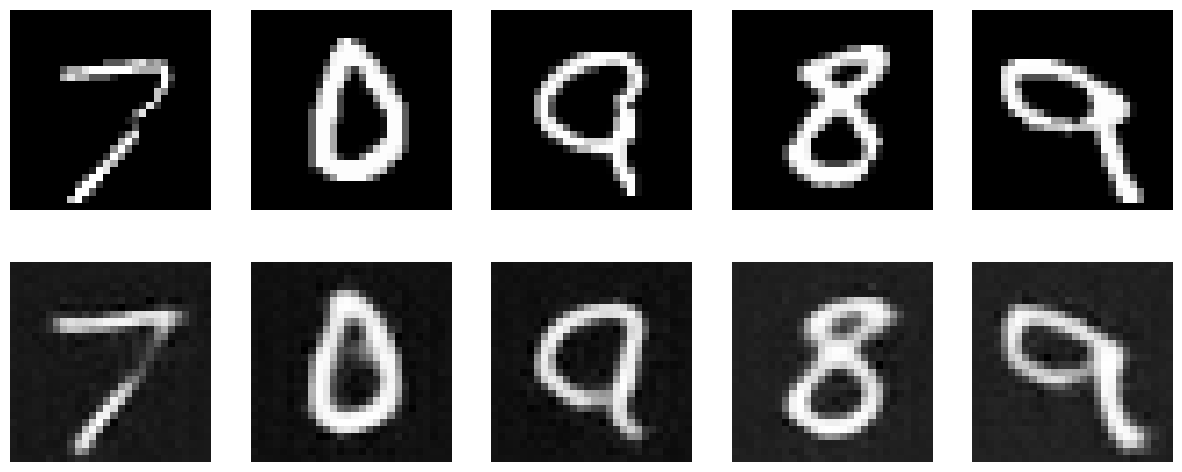


##################################################
[-0.34041527 -0.19134338]
[1.0623437 0.5664387]
[0.30722913 0.21995717]
VAE-MLP Epoch [2/15], Loss: 0.0005826028880973657
[[[ 3.25324736e-03  7.64836371e-03 -5.34355582e-04  5.21738548e-03
    8.18204507e-03  9.59527865e-03 -5.35219850e-04  8.08854681e-03
    9.00566112e-03  2.24165246e-03  2.57328153e-04 -2.48716259e-03
   -7.29407836e-03  1.65420619e-03  7.82742922e-04 -4.71922988e-03
   -3.00335721e-03 -1.39336195e-03  4.17765789e-03  8.12113285e-05
   -1.30905141e-03  1.59519184e-02 -3.80873651e-04  7.72247743e-03
    1.05251661e-02 -3.86930560e-03 -7.28976494e-03 -1.83065347e-02]
  [ 6.04875479e-03  1.01908045e-02  4.71584732e-03  4.99136327e-03
    1.17465965e-02  1.50323361e-02  5.74382767e-03  4.00447194e-03
    1.67414546e-02  4.19468200e-03  9.25066043e-03 -5.05127944e-03
    1.15002543e-02 -1.17225142e-03  7.83821568e-03  1.89273583e-03
    1.26377176e-02 -2.37891562e-02  2.73502935e-02 -3.27564590e-02
   -1.93276107e-02  2

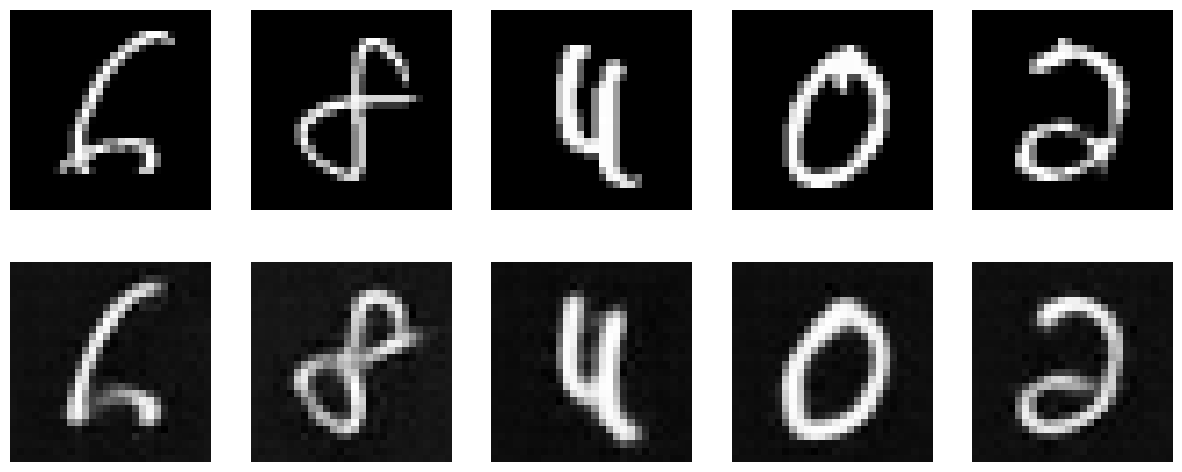


##################################################
[-0.36152452 -0.19307241]
[1.1002747  0.51903653]
[0.36745197 0.23036213]
VAE-MLP Epoch [3/15], Loss: 0.0005462278819332521
[[[ 7.17363134e-03 -5.63964189e-04  9.70333524e-04  2.12053629e-03
    1.78411603e-04 -7.67730002e-04 -1.62277231e-03  1.54340139e-03
   -8.95000761e-04 -1.67766050e-03 -5.29214740e-05  4.50026197e-03
   -2.32051639e-03  5.51882014e-03 -2.56949104e-03  3.82867828e-03
    7.56122055e-04  4.58749151e-03 -1.09925866e-04  5.85673749e-03
    1.67427806e-03  1.48013129e-03  6.85541006e-03  3.99746839e-03
    5.81082888e-03 -2.72972207e-03  5.35243098e-03  2.83625699e-03]
  [ 1.30598177e-03  1.04511494e-03  2.12309929e-03  3.80882272e-03
    2.03412492e-03 -2.23793089e-04  1.78770535e-03 -9.45165462e-04
   -3.71150463e-03 -2.82257050e-03  5.03256859e-04  1.03151018e-03
   -4.29329602e-03 -1.47328421e-03 -3.22416797e-03 -6.84857368e-05
   -4.84428508e-03 -1.23669149e-03 -6.88357232e-03 -3.00053344e-03
    7.36535434e-03 

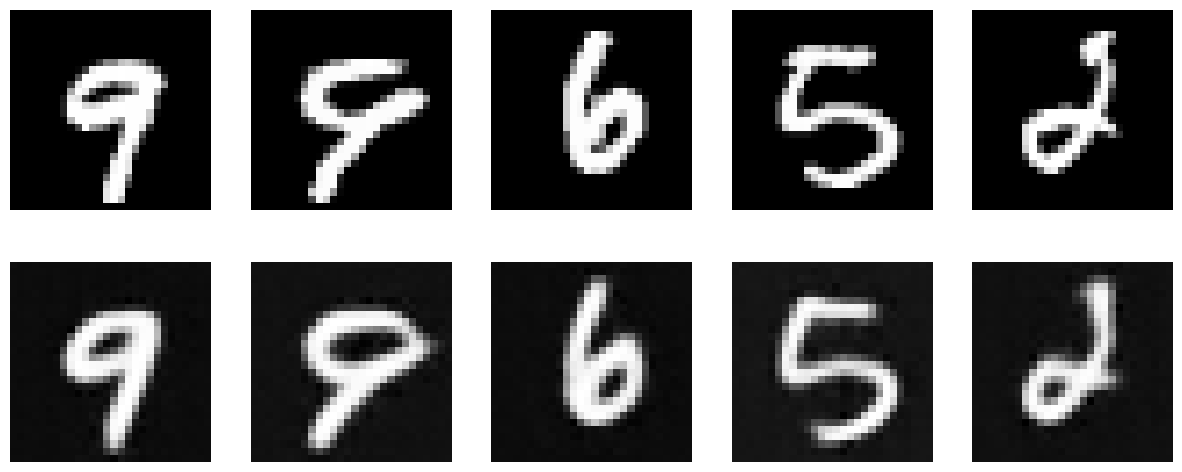


##################################################
[-0.3557973 -0.1838032]
[1.142841   0.49785998]
[0.3611513  0.23271279]
VAE-MLP Epoch [4/15], Loss: 0.0004940021961927414
[[[-5.42309042e-03  8.14870000e-05 -7.46555510e-04 -2.61224946e-03
   -2.48106057e-03  1.07845282e-02 -5.17718436e-04  4.11016401e-03
    4.06893343e-03 -8.19079403e-04 -4.09321440e-03  9.42431018e-03
    9.21942294e-03  5.47608454e-03  7.48772314e-03  5.94523270e-03
   -5.58679691e-03  1.12644956e-02 -1.89736998e-03  2.84959353e-03
   -2.80708820e-03  9.36973281e-03  3.16378172e-03  2.57156789e-04
    1.14551885e-03  5.71993459e-03  1.59270177e-03  6.82389596e-03]
  [ 1.17093325e-04  4.57352214e-03  1.94716209e-03 -1.39325857e-06
    2.69846711e-03  6.84051728e-03  1.17234504e-02 -1.92706799e-03
    1.10632284e-02 -8.68141651e-05  1.71270240e-02  5.98947238e-03
    2.13759812e-03  1.17880311e-02 -2.27615237e-05 -1.93183625e-03
    3.95975448e-03  4.03585332e-03  9.59276862e-04  3.82207305e-04
    1.16229057e-06  4

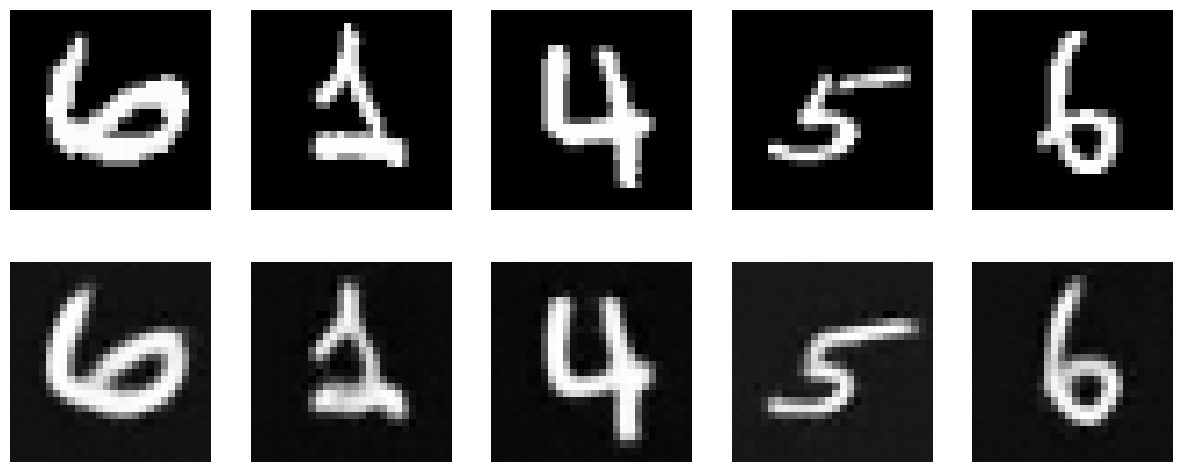


##################################################
[-0.34596285 -0.18999167]
[1.1818806  0.46608543]
[0.3561014  0.23113747]
VAE-MLP Epoch [5/15], Loss: 0.0004911931048768262
[[[-7.19441334e-03  2.68090516e-04 -1.15454523e-03 -4.85587772e-03
   -3.17583652e-03 -1.97346625e-03 -2.43633497e-03 -9.34932090e-04
   -8.17842036e-03 -5.19566238e-05 -1.15154637e-03  5.35204948e-04
    1.07730133e-03 -9.73794318e-04 -1.79603125e-03 -2.25588679e-03
    1.46030530e-03 -1.35352754e-03 -2.03415845e-03 -4.05848399e-03
    1.88617187e-03  6.84659812e-04  8.68178904e-05 -8.79965490e-04
   -1.71478838e-04 -9.09145689e-04  2.98878038e-03 -9.10736388e-04]
  [-8.37433909e-04 -2.52552168e-03 -2.19688960e-03  4.01871745e-03
    1.97057542e-03 -6.37663435e-03  8.80669802e-03  2.03663372e-02
    3.64277395e-03 -1.09896222e-02 -6.69000391e-03 -4.14829561e-03
   -3.00873071e-04 -5.31616993e-03  4.31053340e-05 -4.21988312e-03
    4.68995393e-04  2.84662074e-03  2.22933292e-03 -6.72103418e-03
    1.47117197e-03 

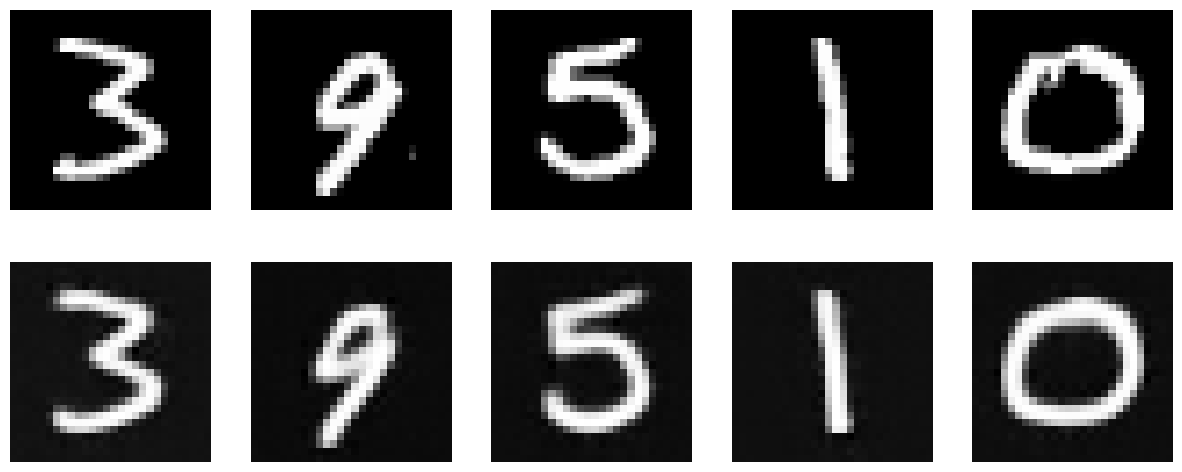


##################################################
[-0.3446606  -0.20148745]
[1.2235379  0.42390305]
[0.3597413  0.23083998]
VAE-MLP Epoch [6/15], Loss: 0.0005020471620062987
[[[ 1.84131949e-03 -1.18524523e-03  2.88617937e-03  2.32879398e-03
    2.67571327e-03 -1.28642772e-03  3.75301111e-03  9.41771723e-04
    3.10491771e-04  2.88002519e-03  4.23423294e-03  1.05060975e-03
    1.48453086e-03  1.96137023e-03  3.47821508e-03  4.50858381e-03
   -7.33367982e-04  8.24175030e-03 -1.47470727e-03  4.17531841e-03
    1.58196560e-03  6.01126486e-03 -2.08201329e-03  4.30294825e-03
    2.73629348e-03  4.83220769e-03  4.15927731e-03  2.14837538e-03]
  [ 2.58917524e-03  1.47198781e-03  5.37576200e-03 -1.15067093e-03
    3.84966610e-03 -1.96937588e-03  2.89888983e-03 -9.05878609e-04
    3.98098072e-03  1.03881175e-03  3.28504969e-03  1.14662899e-03
    4.86443099e-03  5.55978576e-03  4.41100216e-03  2.03113724e-03
    5.96713647e-03  1.02545898e-02  1.01713417e-02  3.82140279e-03
    2.18333700e-03 

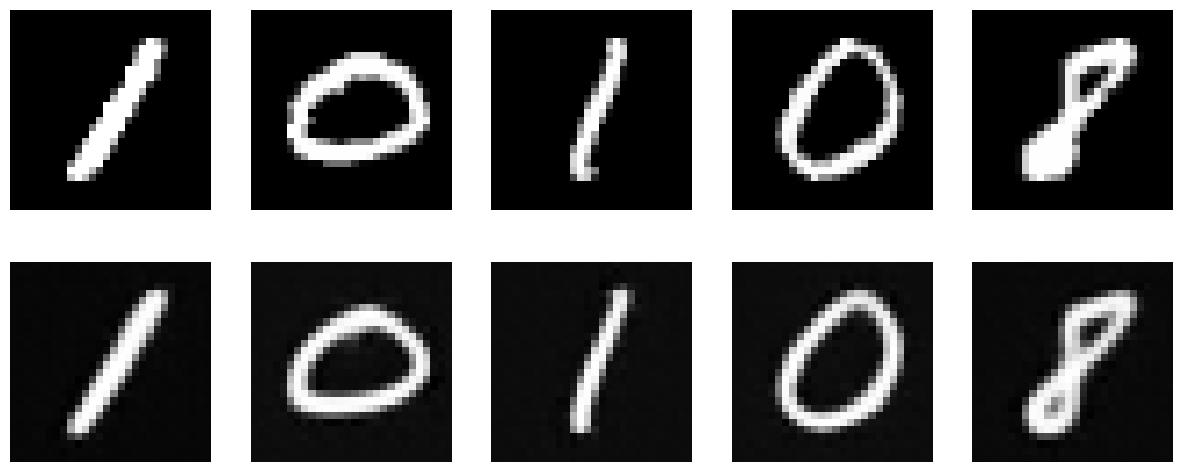


##################################################
[-0.34545827 -0.21697135]
[1.2731142 0.3831285]
[0.36644253 0.22958699]
VAE-MLP Epoch [7/15], Loss: 0.0005319257769112785
[[[ 2.54273415e-04 -1.89983612e-03 -4.83969197e-04 -1.12273311e-03
    4.53626708e-04  1.15216477e-03  8.24387942e-04 -1.59821333e-03
    1.43373478e-03 -3.19554307e-03 -7.05452519e-04  5.60646818e-04
   -3.60500038e-04 -5.49769076e-03 -3.32088303e-03  3.77405406e-04
   -1.00059435e-04 -1.04367016e-02 -5.19940583e-03 -2.46727513e-03
   -2.58121989e-03 -1.26495888e-03 -9.10984119e-04 -1.35290169e-03
    9.40192200e-04 -2.64462596e-03 -3.36925522e-03  3.22107226e-05]
  [-2.77163321e-03 -5.13623422e-03 -2.76518660e-03 -1.87509472e-03
   -1.51100638e-03 -3.70597444e-03 -2.40133051e-03 -1.76239572e-03
    2.91090761e-03 -2.23992951e-03 -1.45408779e-03 -6.35918172e-04
    6.98402408e-04  1.40088908e-02 -1.19187981e-02 -1.00572186e-03
    1.21464385e-02 -2.99411872e-03 -2.91202334e-03  2.64681876e-05
   -4.81736474e-03 -1

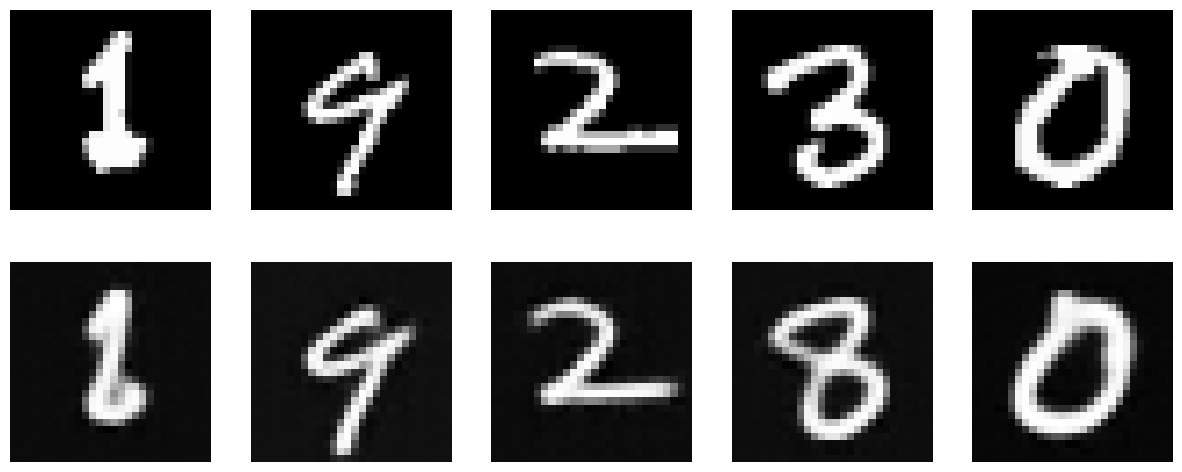


##################################################
[-0.34286028 -0.22952494]
[1.3308551  0.33358297]
[0.38252708 0.24156573]
VAE-MLP Epoch [8/15], Loss: 0.000562721752996246
[[[ 2.02889461e-03  5.31526224e-04  1.33663707e-03  2.69016158e-03
    2.64915568e-03  2.51663849e-04 -6.41982886e-04  2.85069807e-03
    5.52875316e-03  1.61733478e-04  1.19505019e-03  1.17425935e-03
    3.28235258e-03 -5.57551102e-04  3.25646414e-03 -1.19766535e-03
    3.67484638e-03  1.42153352e-04  2.52107182e-03 -7.27500650e-04
    1.35846913e-03 -1.26063824e-04  1.35750615e-03 -8.07564531e-04
    3.06291110e-03  2.00799946e-03 -3.48445028e-05  3.07355076e-04]
  [-1.20863318e-04  6.02157728e-04  2.45229225e-03 -1.93056592e-03
    2.32094666e-03  1.34682574e-03  3.89874796e-03  3.39690596e-05
    5.85519336e-03  2.27908208e-03  5.88201825e-03  5.82837593e-03
    7.14262528e-03  2.26289034e-04  5.38280979e-03  4.58073942e-03
    7.19219167e-03 -1.03181938e-03  1.18155906e-03  1.66736578e-03
    4.56758775e-03  

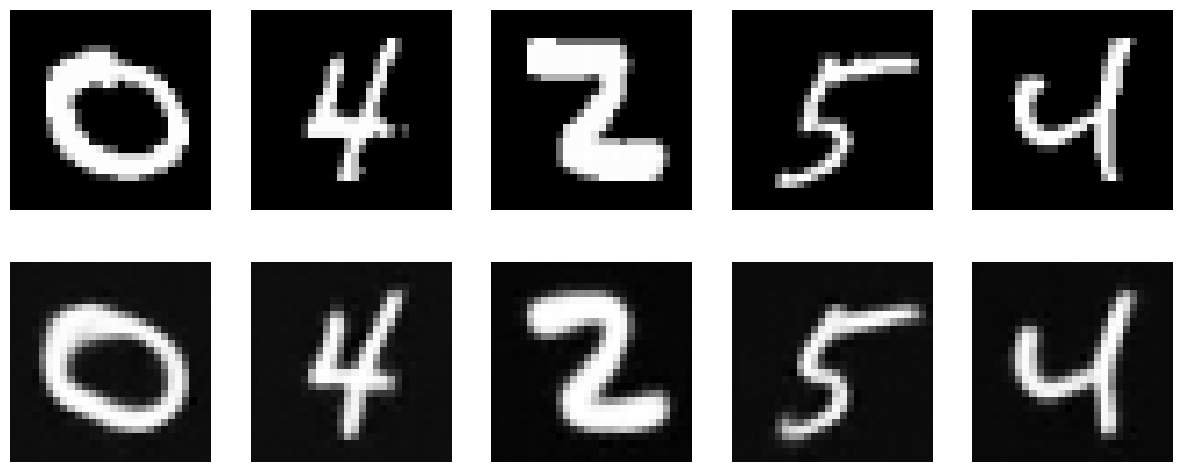


##################################################
[-0.3578472 -0.2435817]
[1.3860569  0.30292585]
[0.3744347  0.24667034]
VAE-MLP Epoch [9/15], Loss: 0.0005929369701072574
[[[-1.12559507e-03  1.93139759e-03  9.63531143e-04 -1.42832380e-03
   -4.16700699e-04 -1.24164857e-04  4.35747206e-05 -1.68563798e-04
    1.00912957e-03 -4.77481604e-04  1.31258764e-03 -1.26934168e-03
    9.12742456e-04  1.49648334e-03  1.00567995e-03 -9.21595609e-04
    9.34062235e-04 -4.87197161e-04  4.84110758e-04 -8.87609785e-04
    1.45576603e-03 -7.09279324e-04  1.34255737e-04 -3.09960917e-04
    8.91856616e-04  2.16355547e-05  2.37960368e-04 -1.43553875e-03]
  [ 1.77141279e-04 -1.12257199e-03 -7.24462676e-04 -1.27793965e-03
   -7.77030189e-04  3.17024672e-03  5.14145941e-05  2.21235678e-04
   -6.07950334e-03  1.99715351e-03  2.10350263e-03  3.19533073e-03
   -6.92264317e-03  2.96917069e-03  1.23534200e-03  2.65216199e-03
   -4.89776814e-03  2.64021801e-03  1.22331118e-03  1.10507989e-03
   -6.39682822e-03  9

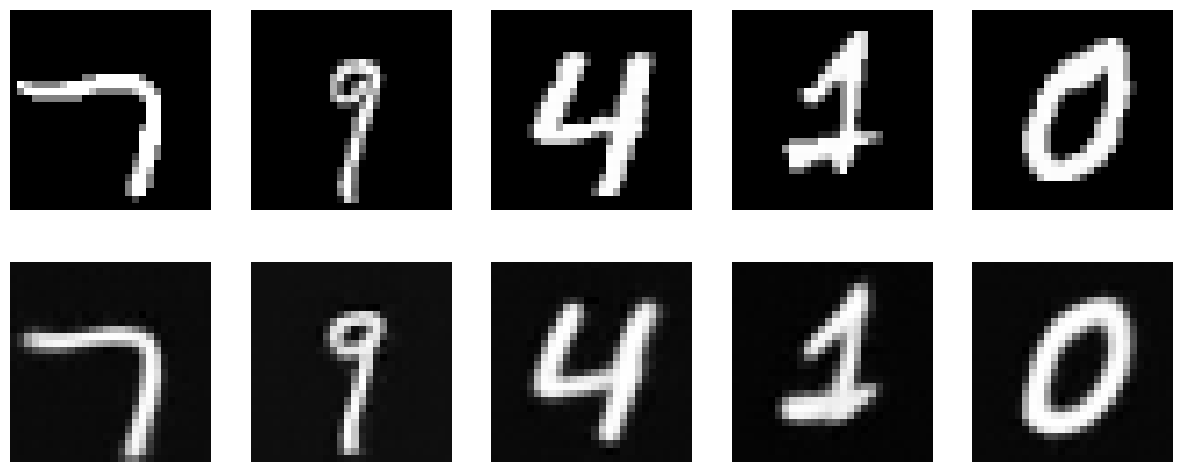


##################################################
[-0.37564257 -0.23817118]
[1.415421   0.27151865]
[0.38028947 0.25719783]
VAE-MLP Epoch [10/15], Loss: 0.000604739021944503
[[[-9.28748108e-04  1.14691816e-03  1.11914473e-03  1.71044376e-04
    1.07010966e-03  4.08972119e-04  1.22038182e-04  3.21406405e-04
    4.04807710e-04 -1.19563320e-03  5.90768585e-04 -2.00951006e-03
   -2.99221370e-03 -8.00114882e-04  1.26011088e-03 -1.58407062e-03
   -7.84066506e-05  7.14528258e-04  1.22851913e-03  8.35672312e-04
    1.93900743e-03  1.00771582e-03  2.77479296e-03 -7.57045927e-04
   -1.42445369e-03  9.20830993e-04  1.72540697e-03 -2.52711587e-04]
  [ 6.72443188e-04 -4.07375366e-04  3.91716108e-04  3.14691104e-04
    1.75801059e-03 -3.89868364e-04  2.50617974e-04  4.88134072e-04
    1.00727996e-03  5.89269621e-04  1.10361306e-03  4.83863009e-03
    5.55825653e-03  2.91255792e-03  2.65455176e-03  2.88604712e-03
    2.34757154e-03 -3.28499521e-03  9.41918604e-03  2.12799339e-03
    2.43073027e-03 

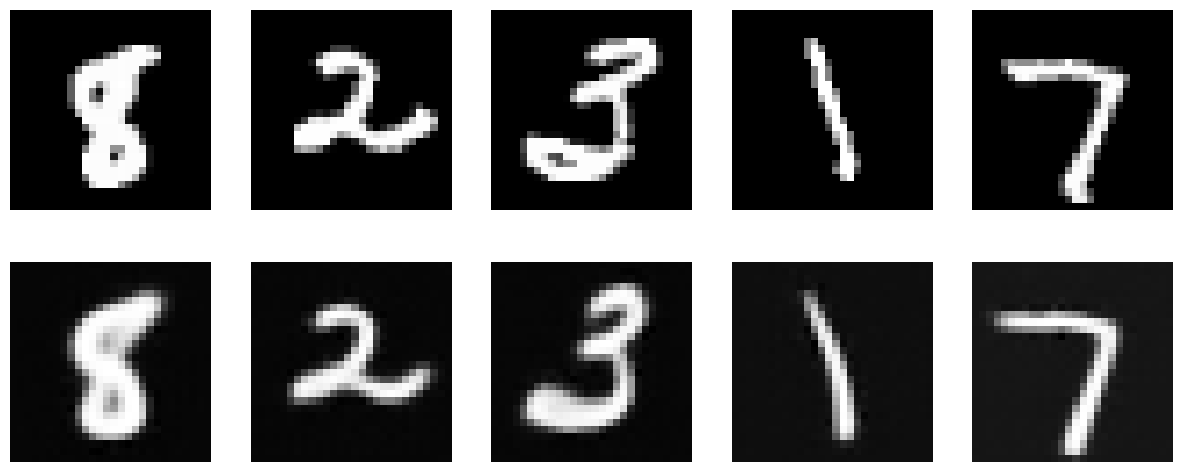


##################################################
[-0.42860016 -0.24850558]
[1.4587337  0.24022482]
[0.35290295 0.27252775]
VAE-MLP Epoch [11/15], Loss: 0.0006468890839566787
[[[ 8.30822450e-04  1.12239830e-03 -1.31528359e-05 -5.66057337e-04
    8.59997468e-04 -1.63025688e-05 -1.17471674e-04 -2.80586071e-04
   -1.01897854e-03 -4.88074933e-04 -3.25635774e-04 -4.08730673e-04
   -3.25103290e-04 -1.05376320e-03 -5.54338971e-04 -2.29307148e-03
   -7.93248008e-04 -2.44512083e-03  1.39748165e-03  2.37341737e-04
   -3.01148510e-04  2.12410698e-04  1.73403474e-03 -2.43294053e-05
    1.47973502e-03  1.59021746e-03  1.57505565e-03 -8.40663502e-04]
  [-6.18651451e-04  3.19066690e-04 -3.42599349e-04  1.05980318e-04
   -1.34618953e-04  6.68317080e-05 -2.20445450e-04  5.69035707e-04
   -1.16119441e-03 -2.00199452e-03 -3.63240810e-03  5.59338310e-04
    1.15671847e-03  1.55470904e-03  6.86914613e-03 -6.51211990e-03
    1.05892180e-03 -2.71017198e-03  2.61045736e-03  1.83407660e-03
    1.05678861e-03

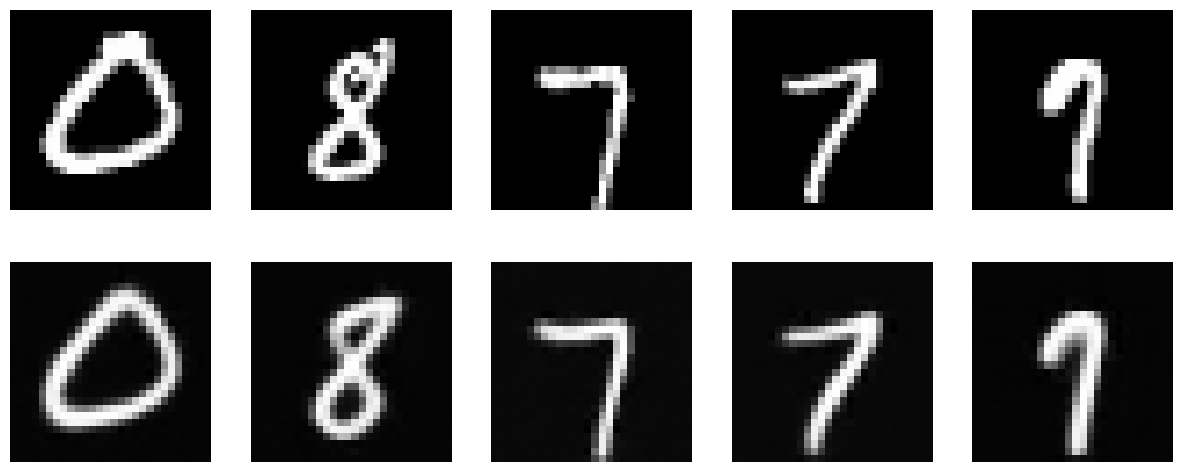


##################################################
[-0.47565895 -0.22641544]
[1.4813564  0.20291772]
[0.34617743 0.3162237 ]
VAE-MLP Epoch [12/15], Loss: 0.0006778488323713343
[[[-3.68577865e-04 -2.69815326e-04 -8.00319307e-04  1.29775610e-04
   -8.03666189e-05 -9.52113245e-04  5.24320640e-05  2.59175664e-04
   -1.13326358e-04 -2.32621096e-06 -1.06185907e-04 -1.32297399e-04
   -1.80186064e-03 -6.47598994e-04 -1.40362885e-03 -6.93698996e-04
   -1.11924717e-03 -1.13999099e-03 -1.30337477e-03 -2.80254986e-04
   -1.82767084e-03 -1.99354137e-03 -1.73223519e-03 -1.40976277e-03
   -1.25635182e-03 -8.03249131e-04 -4.72464337e-04 -7.94161868e-04]
  [-9.77935735e-04 -5.27041673e-04 -7.67289486e-04 -8.49276781e-04
   -1.14668626e-04 -1.65984966e-06  2.49346485e-04 -2.68400018e-03
   -5.25579031e-04 -9.92941204e-05 -3.07449838e-04  1.17843330e-03
   -7.60929484e-04 -2.16609356e-03  4.64889425e-04  1.99610228e-03
    9.27021902e-04  7.89389305e-04 -3.11092893e-03 -1.05749338e-03
    9.59020515e-04

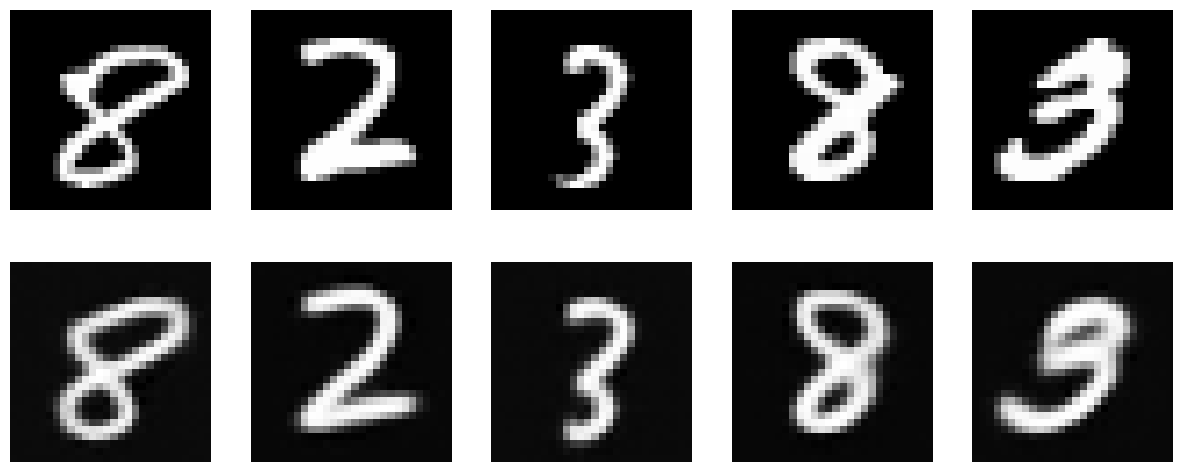


##################################################
[-0.5283798  -0.19912331]
[1.494435   0.18623802]
[0.33638307 0.36681965]
VAE-MLP Epoch [13/15], Loss: 0.000700556037016213
[[[-1.04089582e-03 -3.67498724e-05 -1.05939968e-03 -4.94046079e-04
   -8.64989473e-04 -8.57879291e-04 -8.81357468e-04 -7.99406262e-04
   -7.99568312e-04 -1.67245453e-03 -1.97050604e-03 -2.47392291e-03
   -1.22396112e-03 -6.92348229e-04 -2.13208422e-03 -1.68518804e-03
   -8.26585747e-04 -6.18014892e-04 -9.43049614e-04 -1.92324631e-03
   -6.62932638e-04 -1.12160773e-03 -1.25709362e-03 -1.40182790e-04
   -5.49661054e-04 -6.10045798e-04 -2.79589090e-04 -1.02618930e-03]
  [ 1.83440628e-04  2.18650908e-04 -1.55126676e-04 -5.21849899e-04
    7.70430488e-04  9.53768205e-04  3.92096204e-04 -1.59143109e-03
   -8.14592640e-04 -3.68724228e-03 -2.25771451e-03 -1.36543415e-04
    4.90161648e-04  8.05379066e-04 -6.82370039e-04 -2.28558271e-03
    3.91661277e-04 -1.34152779e-03 -2.59172847e-03 -6.08684216e-03
   -5.04096458e-03 

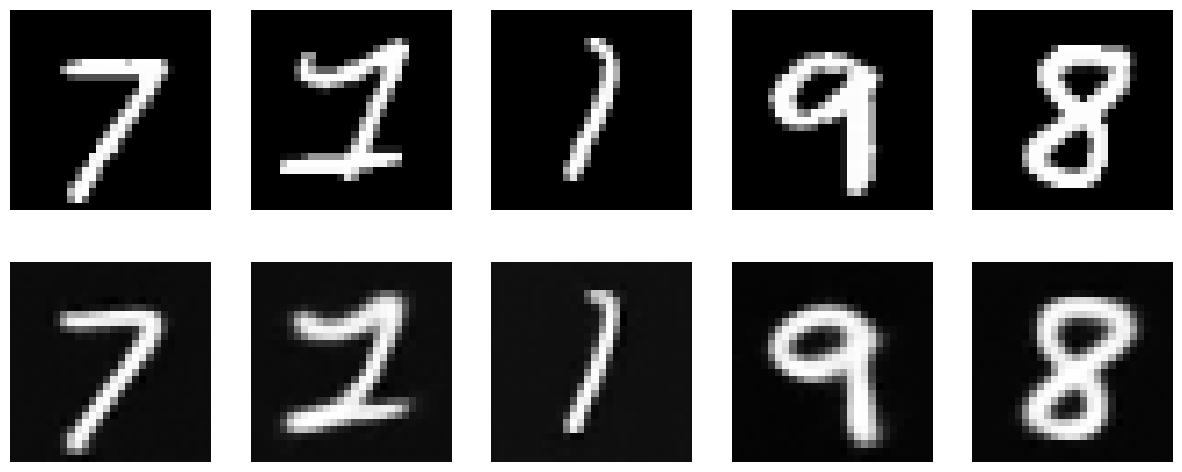


##################################################
[-0.5990225  -0.16950206]
[1.5052325  0.18364659]
[0.28529954 0.43460774]
VAE-MLP Epoch [14/15], Loss: 0.0007434876881539822
[[[-1.27651752e-03 -5.42821072e-04 -9.88860033e-04 -1.00457121e-03
   -1.56090257e-03 -1.30174099e-03 -6.64732070e-04 -1.48829352e-03
   -1.97285460e-03 -1.59717305e-03 -1.00274652e-03 -1.05750666e-03
   -2.01016734e-03 -1.95032579e-03 -4.07541374e-04 -6.90645189e-04
   -2.02956633e-03 -2.31453218e-03 -1.45948457e-03 -4.65235178e-04
   -1.50384335e-03 -1.87242858e-03 -1.22981996e-03 -1.18320761e-03
   -1.25088729e-03 -1.33951078e-03 -2.76355539e-04 -4.23102494e-04]
  [-9.59268946e-04 -1.10509747e-03 -1.73309620e-03 -3.40613304e-04
   -2.53544515e-03 -1.88002537e-03 -2.76129972e-03 -2.50318646e-03
   -1.93779264e-03 -4.97535861e-04 -8.27908923e-04 -1.15675072e-03
   -1.58529007e-03 -1.64729706e-03 -5.20063040e-04  1.17632945e-03
   -1.65711995e-03 -1.65683613e-03 -2.56215362e-03 -1.84293441e-03
   -2.14195391e-03

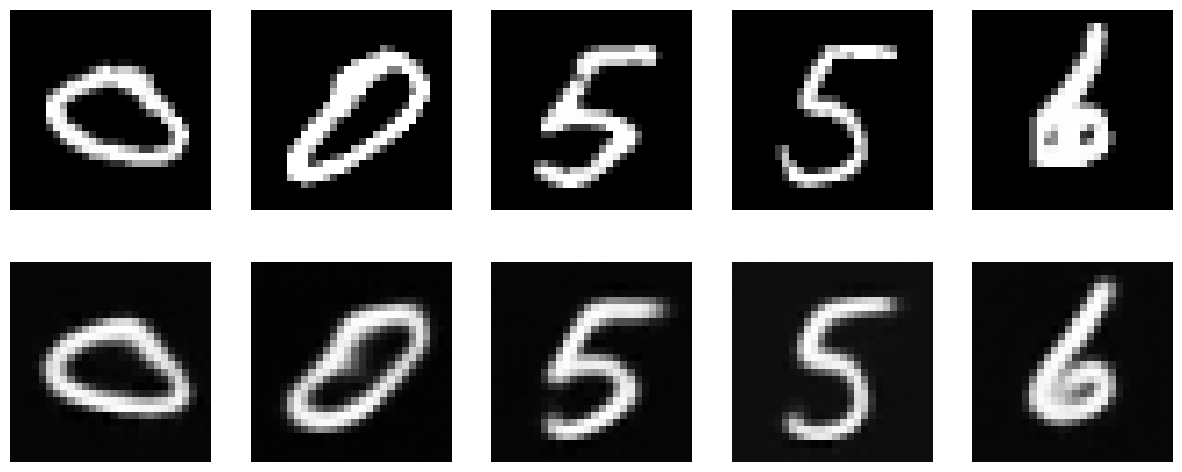


##################################################
[-0.66929495 -0.13966948]
[1.5159166  0.19921748]
[0.26344204 0.5268251 ]
VAE-MLP Epoch [15/15], Loss: 0.0007938475822719435
[[[-1.19453471e-03  9.43227613e-04 -1.24470994e-03  1.33338850e-04
    7.01962155e-04  7.07979430e-04 -2.10644864e-03 -1.81682408e-05
    9.57463810e-04 -2.32122606e-04 -1.42106437e-03  3.04657267e-04
    7.04929698e-05  4.13669244e-04  4.92650259e-04 -9.24457039e-04
    2.18894705e-03  1.78919407e-04  1.90785644e-03  1.71651505e-03
    8.70274380e-04  1.66513084e-03 -8.68659932e-04 -8.96725338e-04
    3.14427074e-04  3.30591109e-04  1.95835950e-04 -1.18935376e-03]
  [ 2.54421029e-05  1.05451129e-03 -1.73776504e-03  1.46594516e-03
   -7.60061957e-04  4.36585367e-04 -1.17169297e-03  3.96689633e-03
    1.26931351e-04 -4.46337945e-04 -4.44199936e-03  8.43819522e-04
   -2.30461266e-03 -7.68515747e-05 -1.50570110e-03  6.99376338e-04
    8.86867987e-04 -5.24726871e-04 -1.11937942e-03 -2.31454754e-03
   -5.41877409e-04

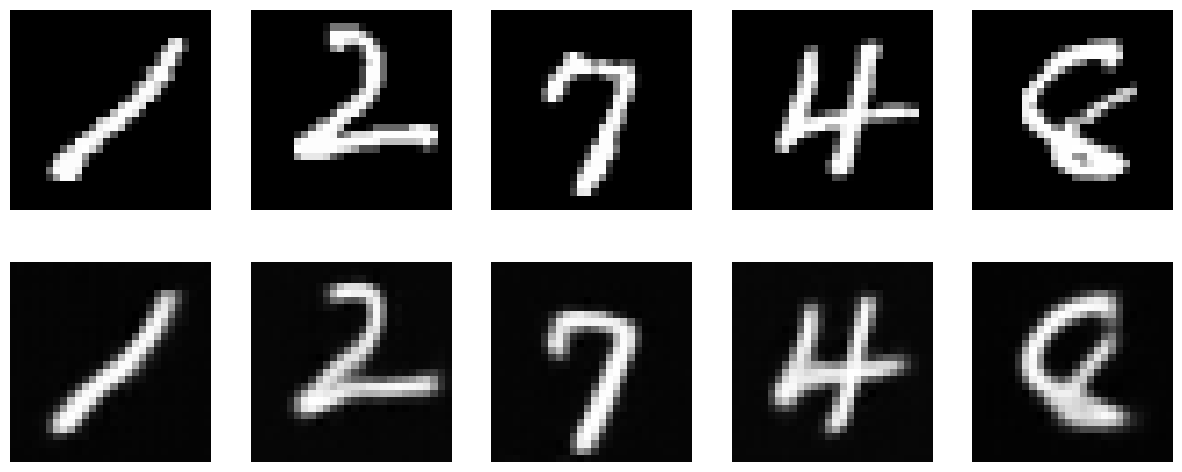

0.0006736583427795104


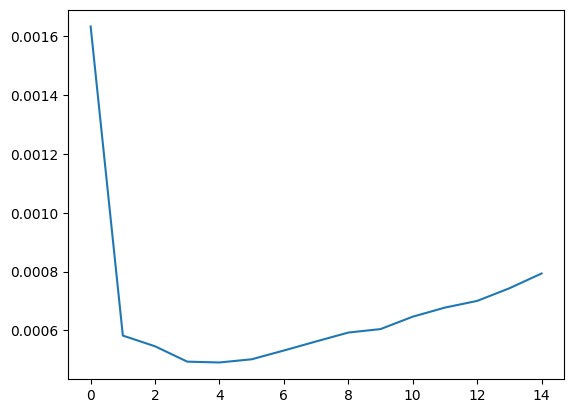

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_one(model, train_loader, num_epochs=15, learning_rate=1e-3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.85)
    images = []
    loss_history = []
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            output = model(data)
            recon, vq_loss = output[0], output[2]
            loss = F.mse_loss(recon, data) + vq_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        codebook = output[3]
        vec1, vec2, vec3 = codebook[0, :], codebook[1, :], codebook[2, :]
        plt.quiver(*vec1, angles='xy', scale_units='xy', scale=1, color='b')
        print(vec1)
        plt.quiver(*vec2, angles='xy', scale_units='xy', scale=1, color='r')
        print(vec2)
        plt.quiver(*vec3, angles='xy', scale_units='xy', scale=1, color='g')
        print(vec3)
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.savefig(f'frame_{epoch}.png')
        plt.close()
        images.append(imageio.imread(f'frame_{epoch}.png'))
        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        data = data.cpu().numpy()
        recon = recon.detach().cpu().numpy()
        fig, axs = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
                axs[0, i].imshow(data[i].squeeze(), cmap='gray')
                axs[0, i].axis('off')
                axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
                axs[1, i].axis('off')
                print(recon[i])
        plt.show()
    plt.plot(range(num_epochs),loss_history)
    print(sum(loss_history)/num_epochs)
    imageio.mimsave('training_vectors.gif', images)




vq = VQVAE(in_channels=1, embedding_dim=2, num_embeddings=3)
train_one(vq, train_loader)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import random

class ColorfulMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, label = self.mnist_dataset[idx]

        img_rgb = img.expand(3, -1, -1)
        color_multipliers = torch.rand(3, dtype=torch.float32)
        img_colorful = img_rgb * color_multipliers[:, None, None]

        return img_colorful, label

transform = transforms.Compose([transforms.ToTensor()])
train_dataset_mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train_dataset_colorful = ColorfulMNISTDataset(train_dataset_mnist)

train_loader_colorful = DataLoader(train_dataset_colorful, batch_size=64, shuffle=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_three(model, train_loader, num_epochs=15, learning_rate=1e-3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.85)
    loss_history = []
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            output = model(data)

            recon, vq_loss = output[0], output[2]
            loss = F.mse_loss(recon, data) + vq_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        data = data.cpu().numpy()
        recon = recon.detach().cpu().numpy()

        fig, axs = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
        # Display original RGB image
              axs[0, i].imshow(data[i].transpose(1, 2, 0))  # Transpose channels
              axs[0, i].axis('off')

        # Display reconstructed RGB image
              axs[1, i].imshow(recon[i].transpose(1, 2, 0))  # Transpose channels
              axs[1, i].axis('off')

        plt.show()


    plt.plot(range(num_epochs),loss_history)
    print(sum(loss_history)/num_epochs)



##################################################


VAE-MLP Epoch [1/15], Loss: 1.6821762231403652


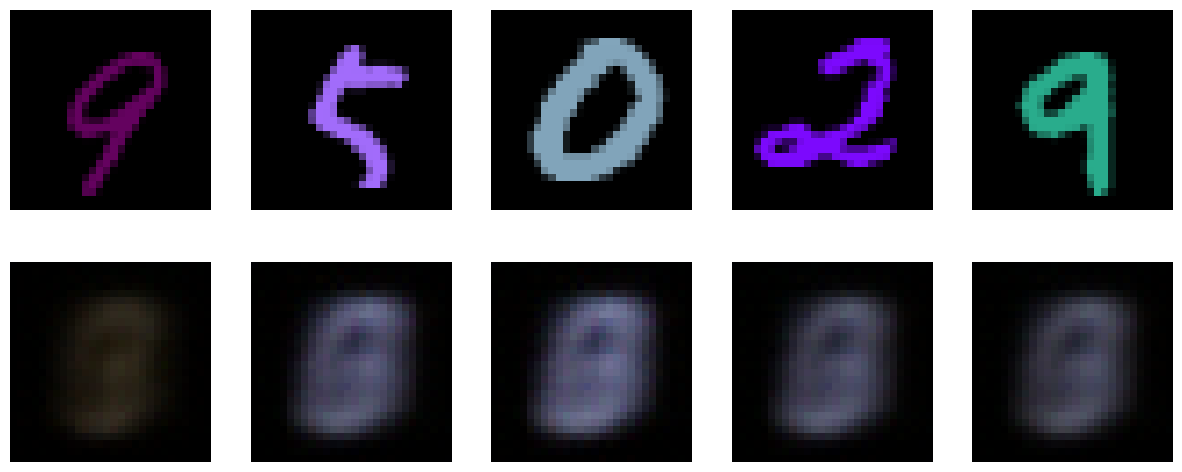


##################################################


VAE-MLP Epoch [2/15], Loss: 0.0004087379541558524


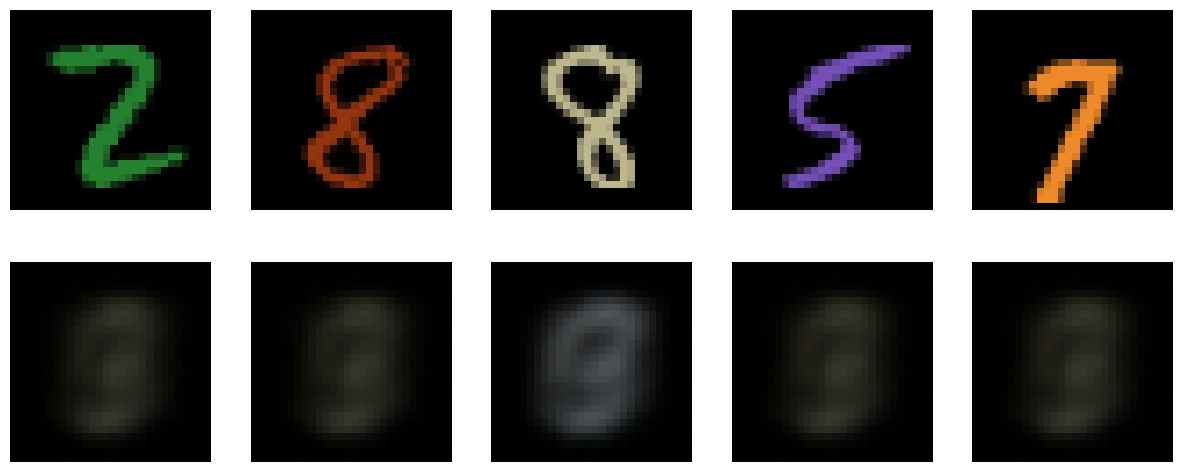


##################################################


VAE-MLP Epoch [3/15], Loss: 0.0003982688846066594


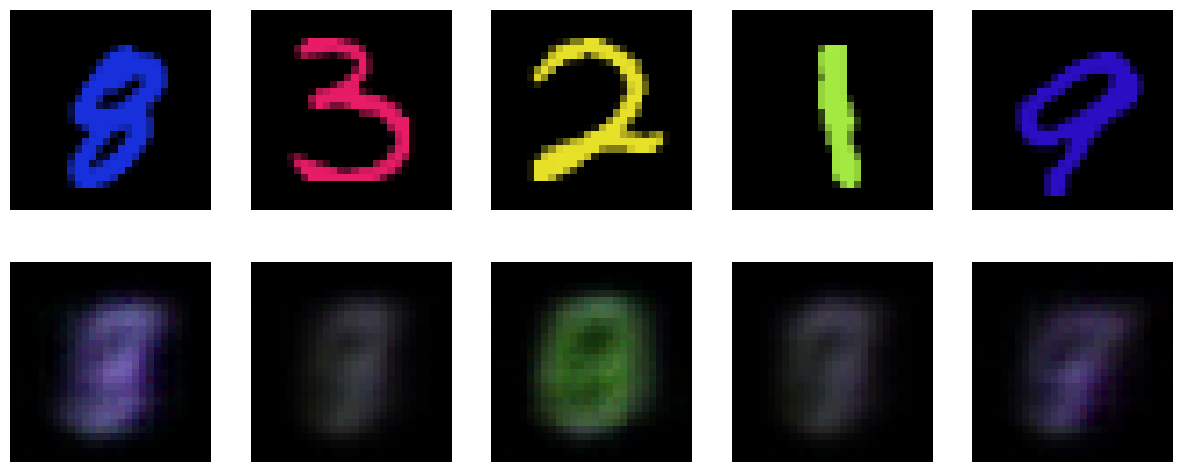


##################################################


VAE-MLP Epoch [4/15], Loss: 0.0003947116317848364


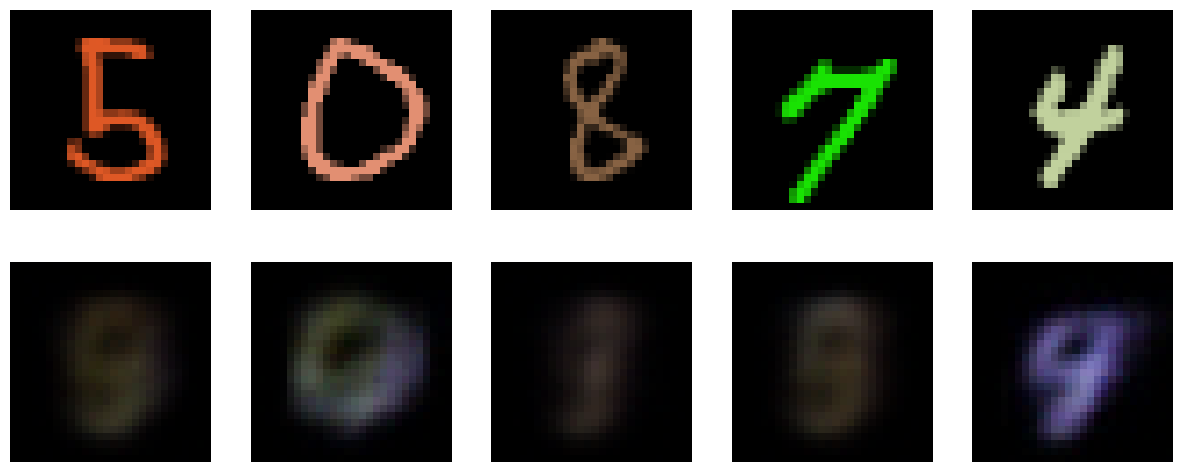


##################################################
VAE-MLP Epoch [5/15], Loss: 0.0007169806321151554


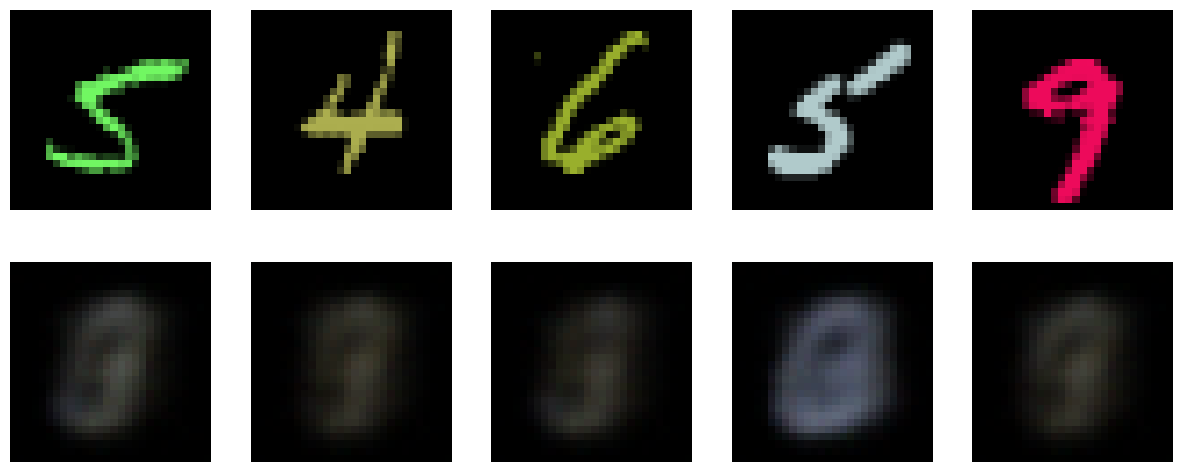


##################################################


VAE-MLP Epoch [6/15], Loss: 0.00037620906277249257


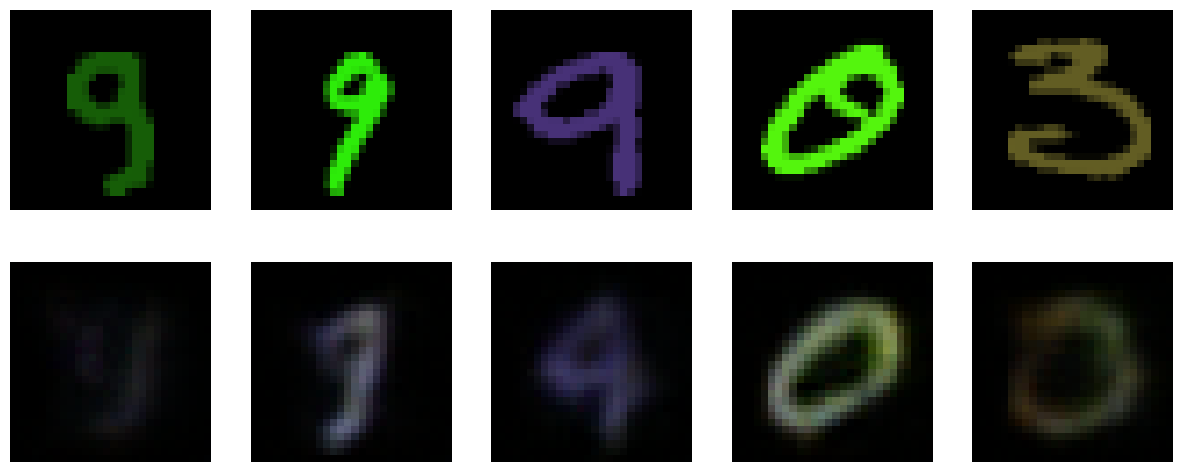


##################################################


VAE-MLP Epoch [7/15], Loss: 0.00032433069019267955


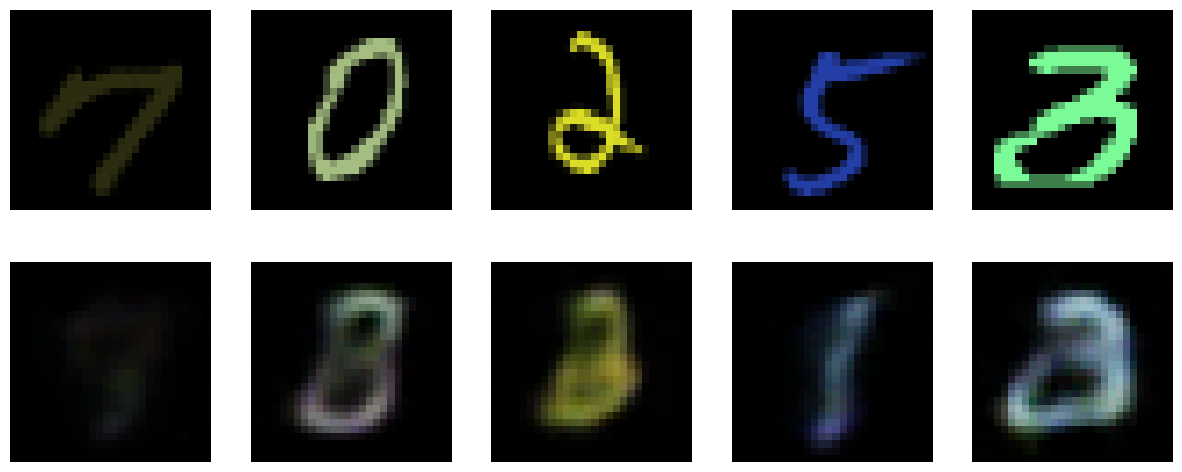


##################################################


VAE-MLP Epoch [8/15], Loss: 0.00032335624285042283


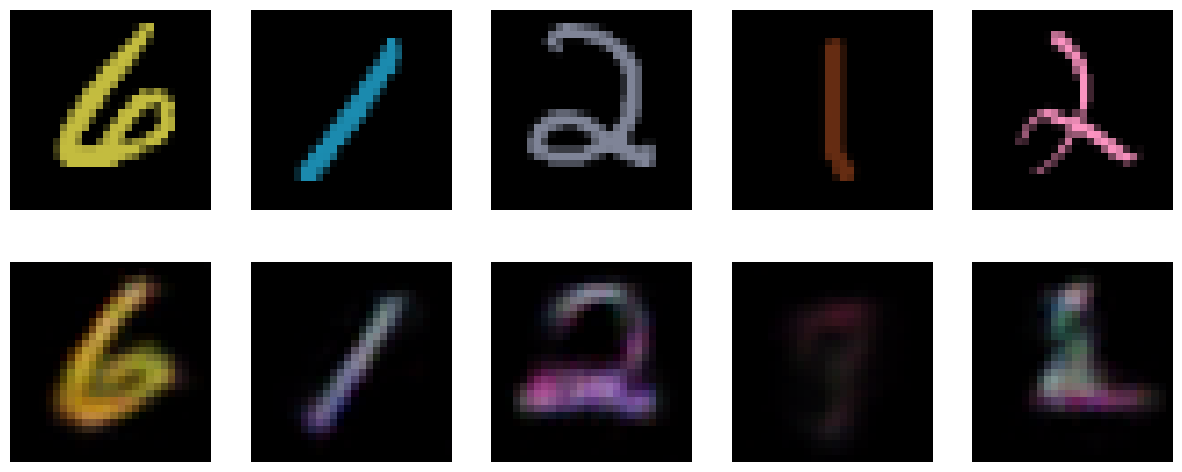


##################################################


VAE-MLP Epoch [9/15], Loss: 0.00030743685003059606


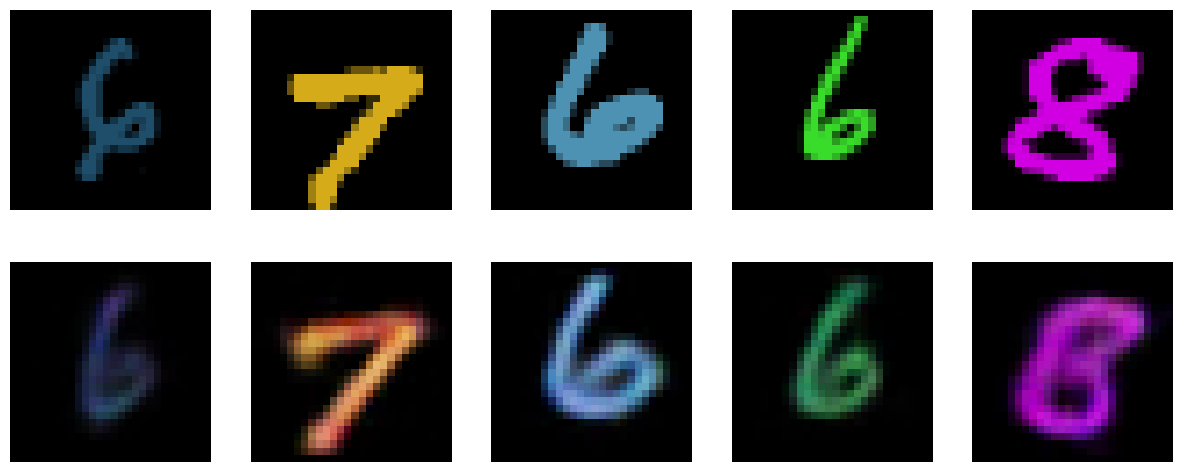


##################################################
VAE-MLP Epoch [10/15], Loss: 0.000280482239012296


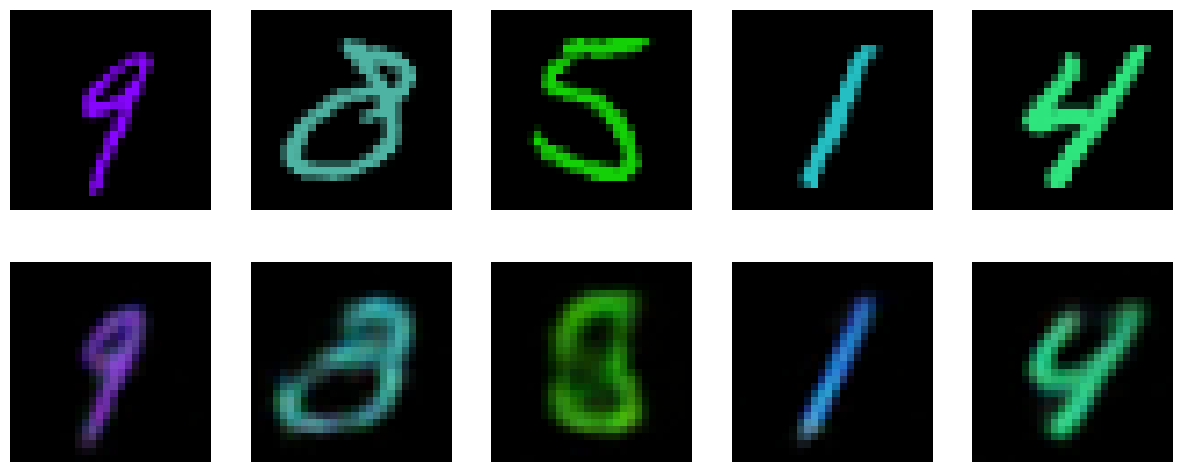


##################################################


VAE-MLP Epoch [11/15], Loss: 0.00026663679373450575


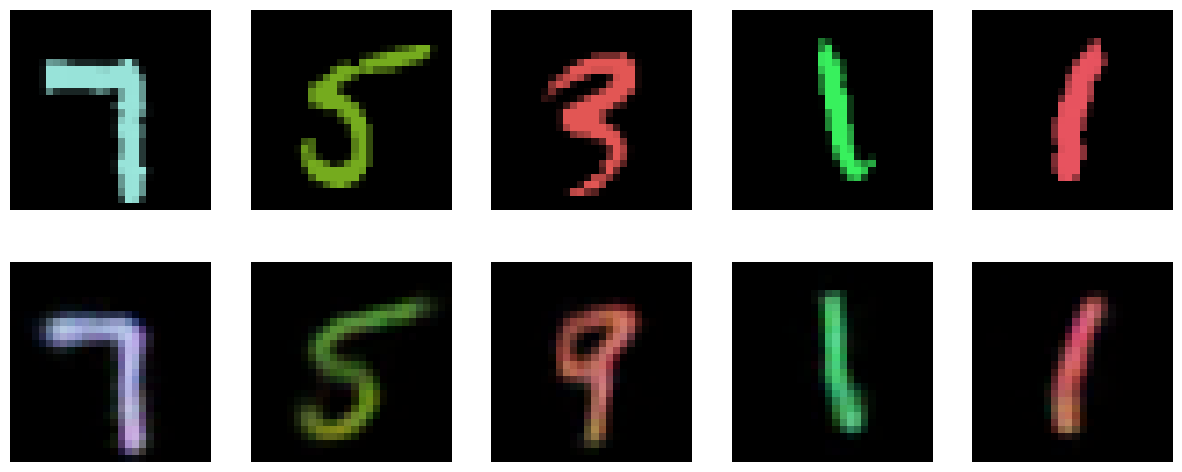


##################################################


VAE-MLP Epoch [12/15], Loss: 0.0002676961086535205


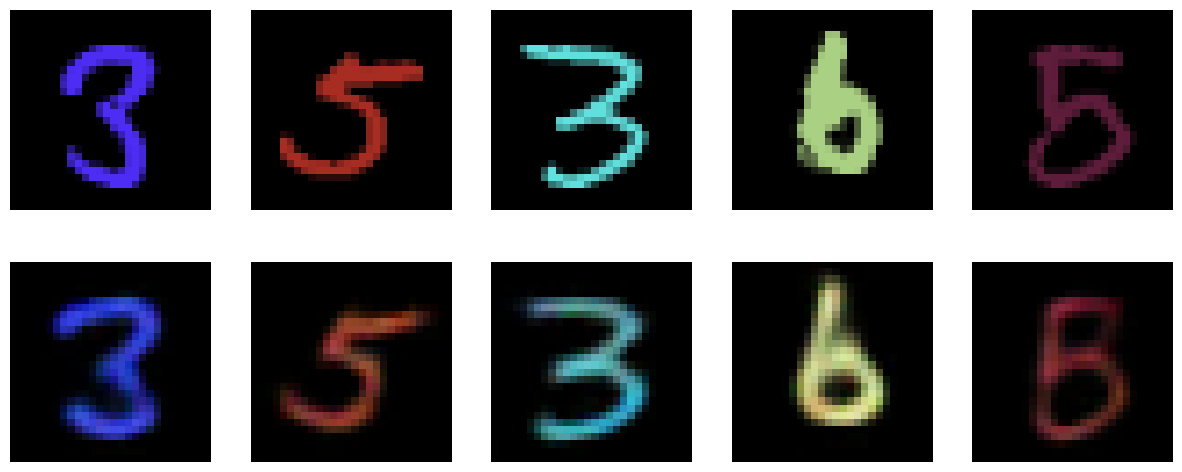


##################################################


VAE-MLP Epoch [13/15], Loss: 0.0002761230234832813


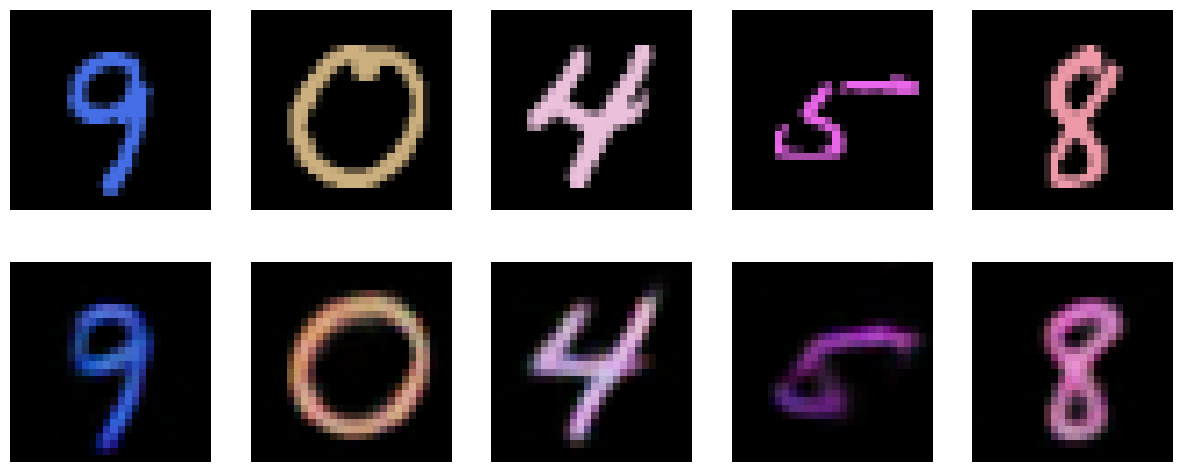


##################################################


VAE-MLP Epoch [14/15], Loss: 0.00021496514659374952


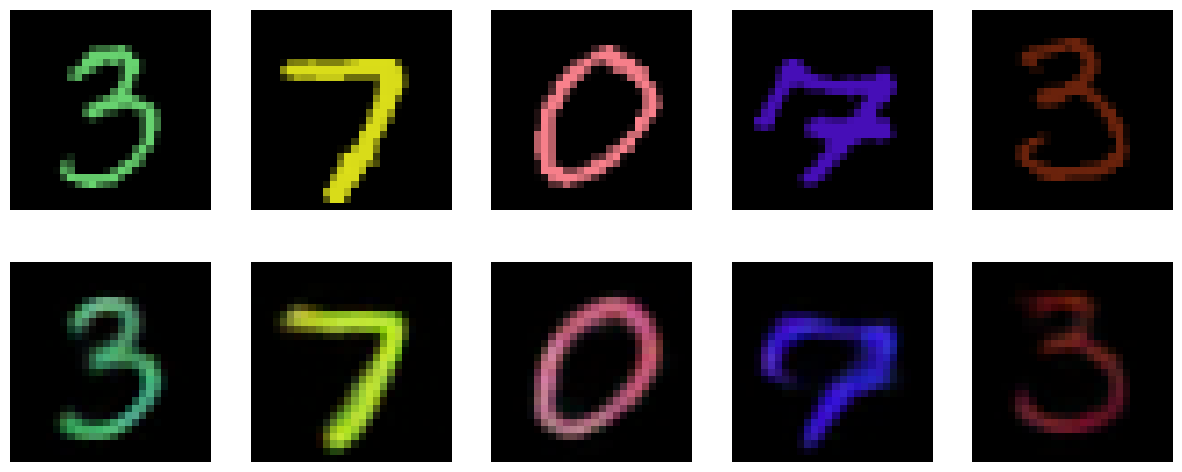


##################################################
VAE-MLP Epoch [15/15], Loss: 0.00018333114076716204


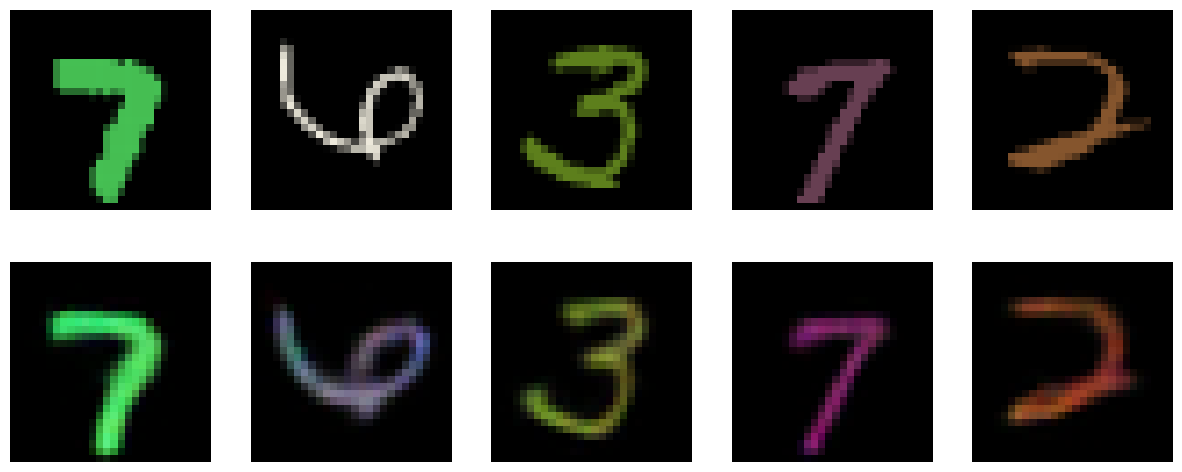

0.11246103263607458


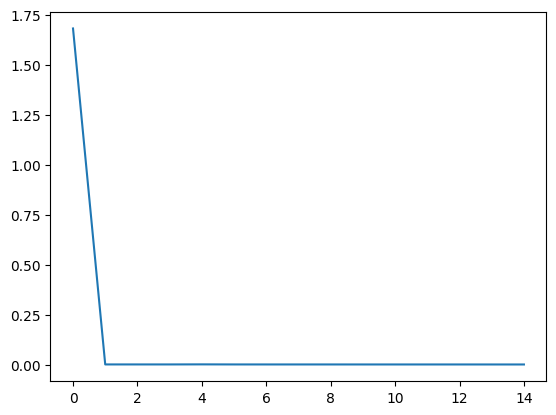

In [ ]:
vq_vae_5_embeddings = VQVAE_modified(in_channels=3, embedding_dim=2, num_embeddings=5)
train_three(vq_vae_5_embeddings, train_loader_colorful)



##################################################


VAE-MLP Epoch [1/15], Loss: 0.00023200623836213102


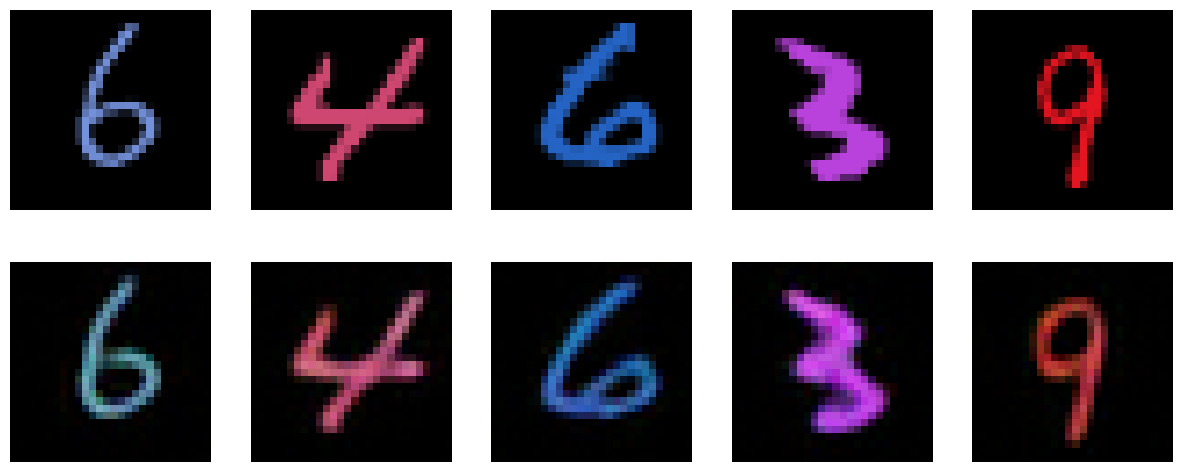


##################################################


VAE-MLP Epoch [2/15], Loss: 7.701941698323935e-05


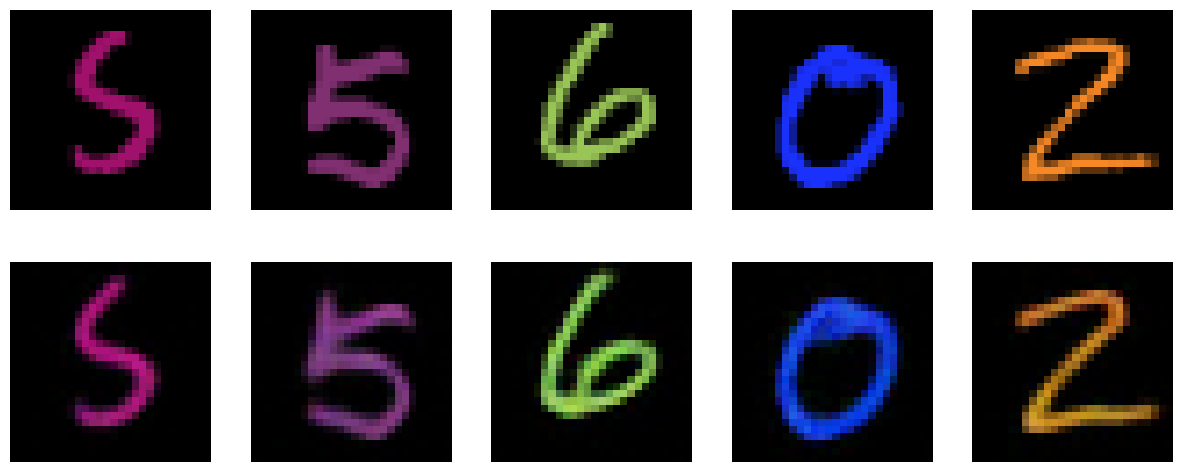


##################################################


VAE-MLP Epoch [3/15], Loss: 6.284409598835433e-05


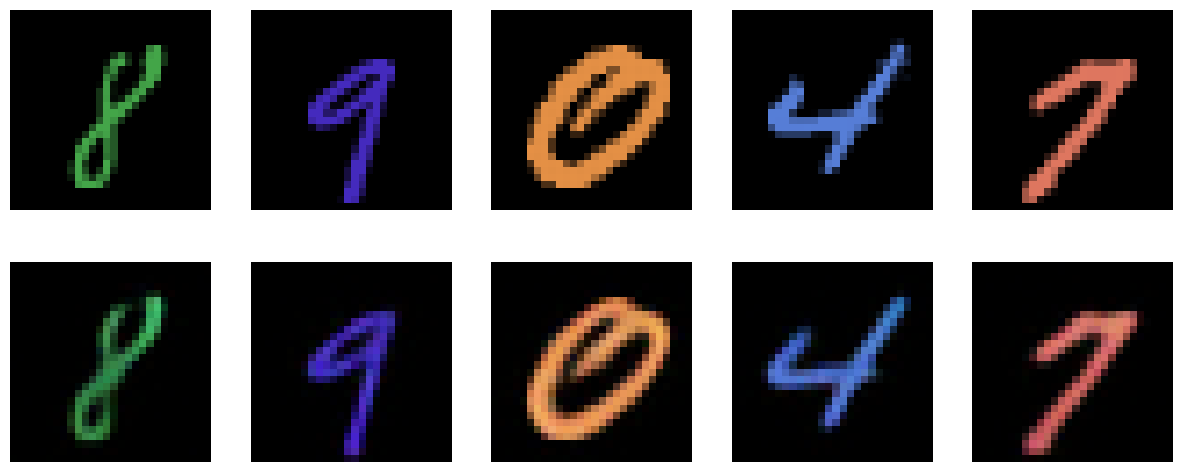


##################################################


VAE-MLP Epoch [4/15], Loss: 5.461920560725654e-05


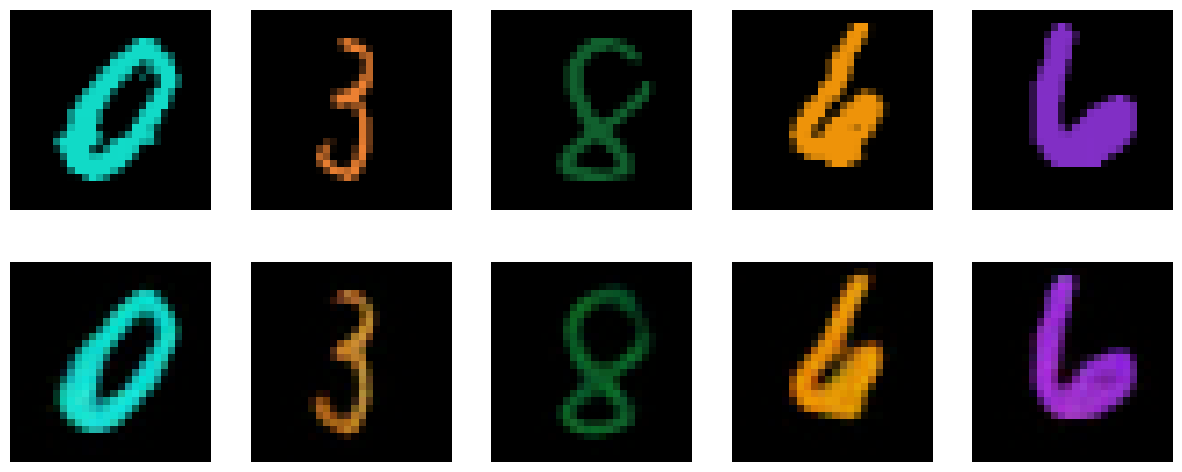


##################################################
VAE-MLP Epoch [5/15], Loss: 5.308800307102501e-05


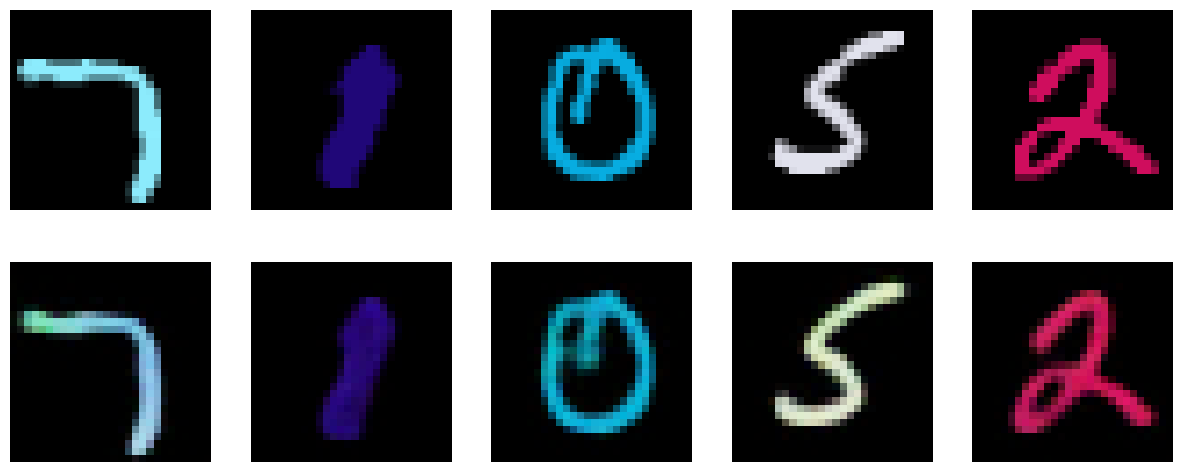


##################################################


VAE-MLP Epoch [6/15], Loss: 5.186830738869806e-05


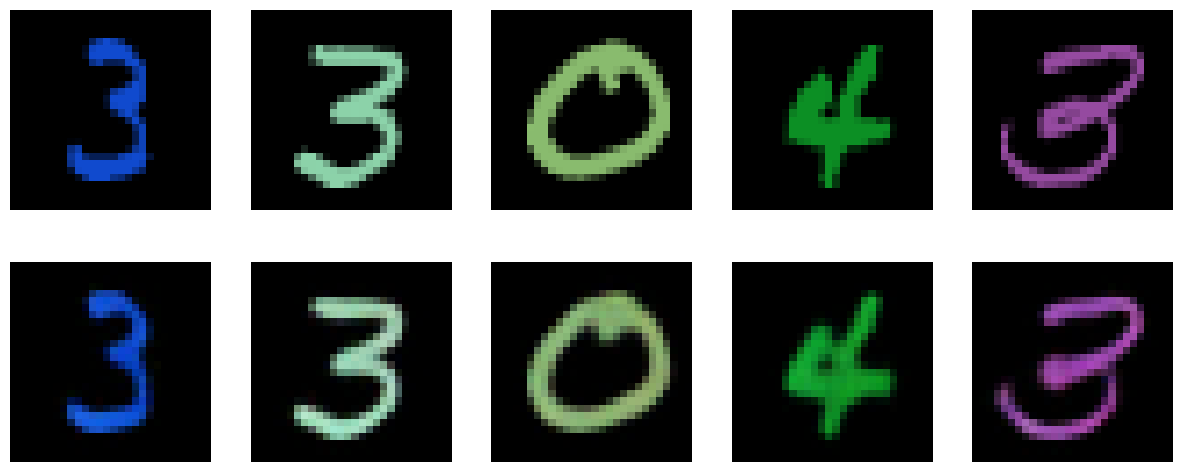


##################################################


VAE-MLP Epoch [7/15], Loss: 5.082419614385193e-05


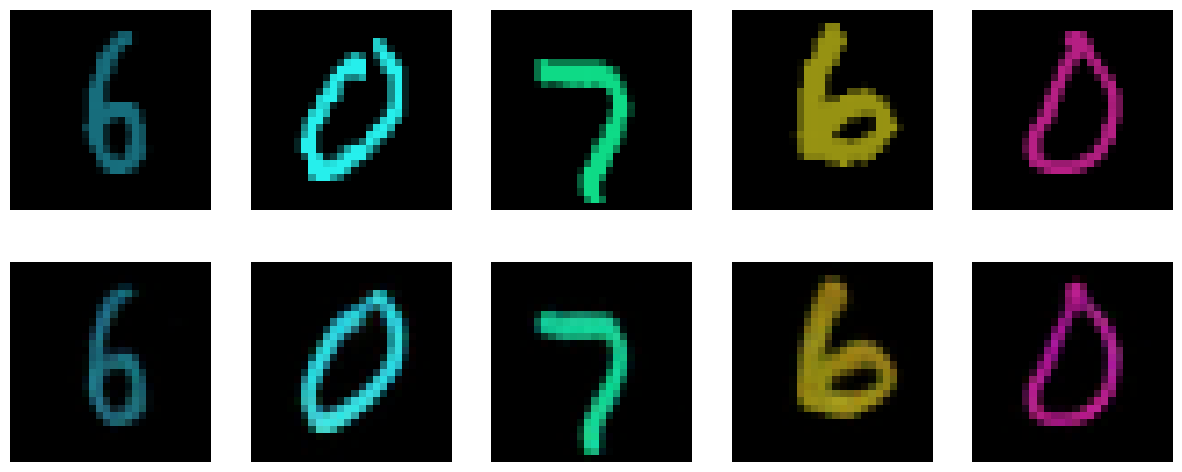


##################################################


VAE-MLP Epoch [8/15], Loss: 4.985433074180037e-05


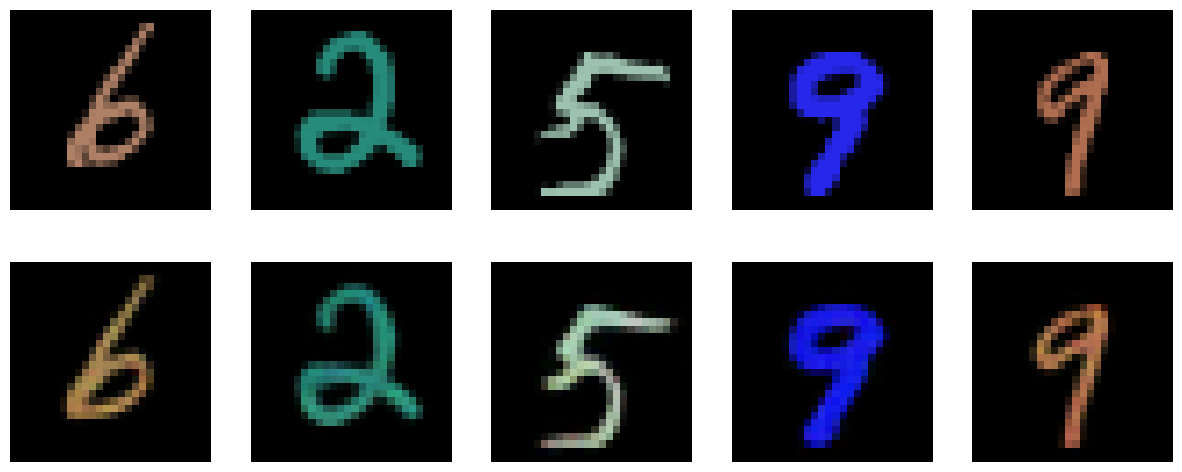


##################################################


VAE-MLP Epoch [9/15], Loss: 4.8316488155008606e-05


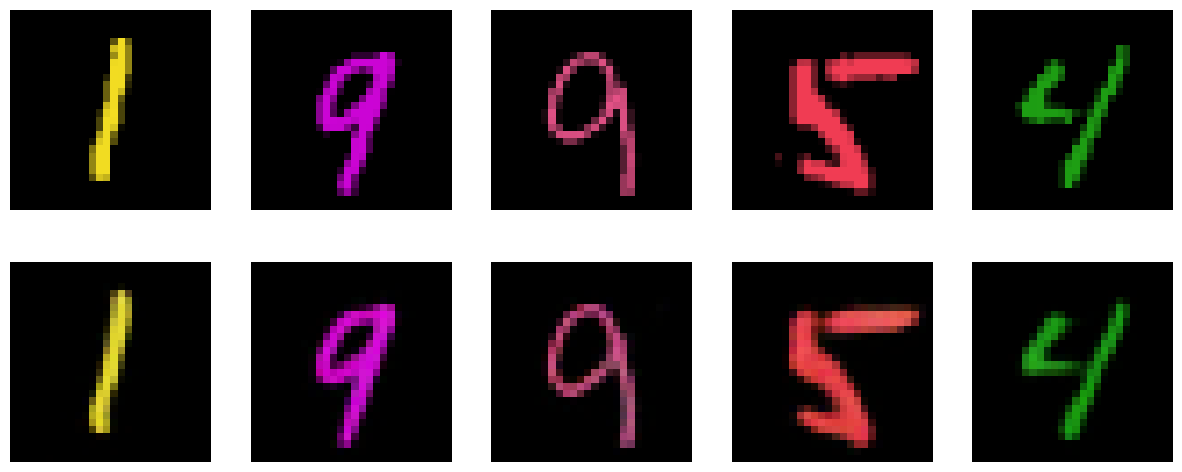


##################################################
VAE-MLP Epoch [10/15], Loss: 4.767202892107889e-05


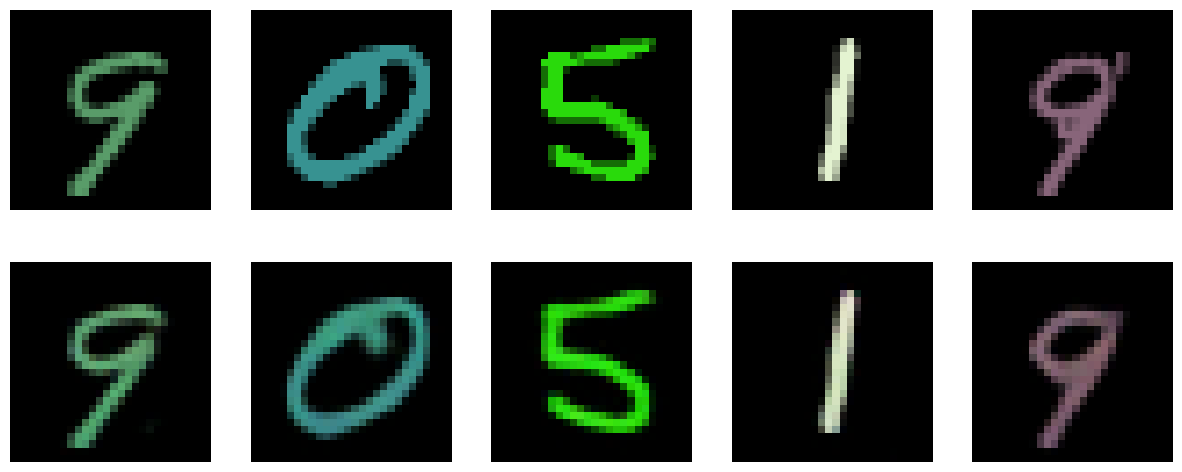


##################################################


VAE-MLP Epoch [11/15], Loss: 4.695266838728761e-05


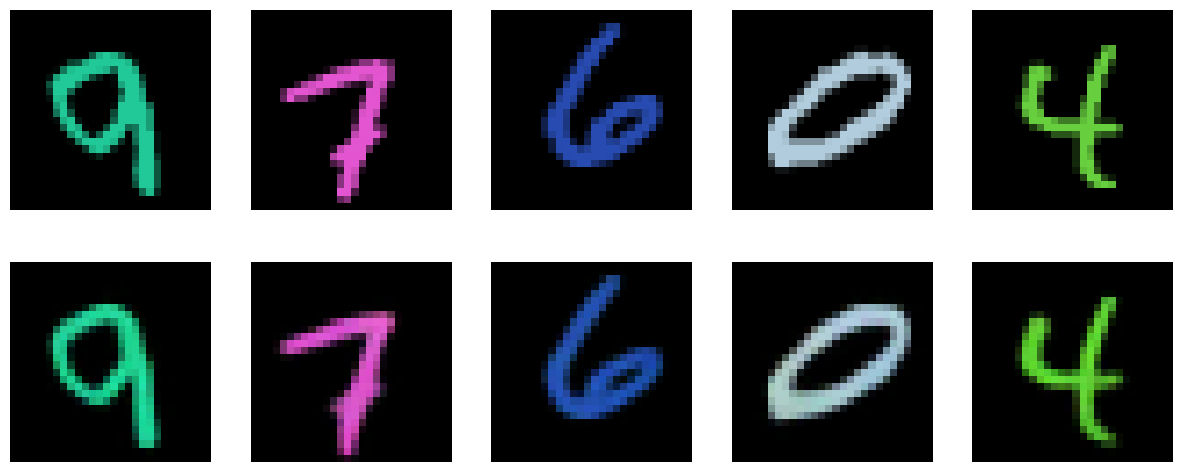


##################################################


VAE-MLP Epoch [12/15], Loss: 4.6681889115522305e-05


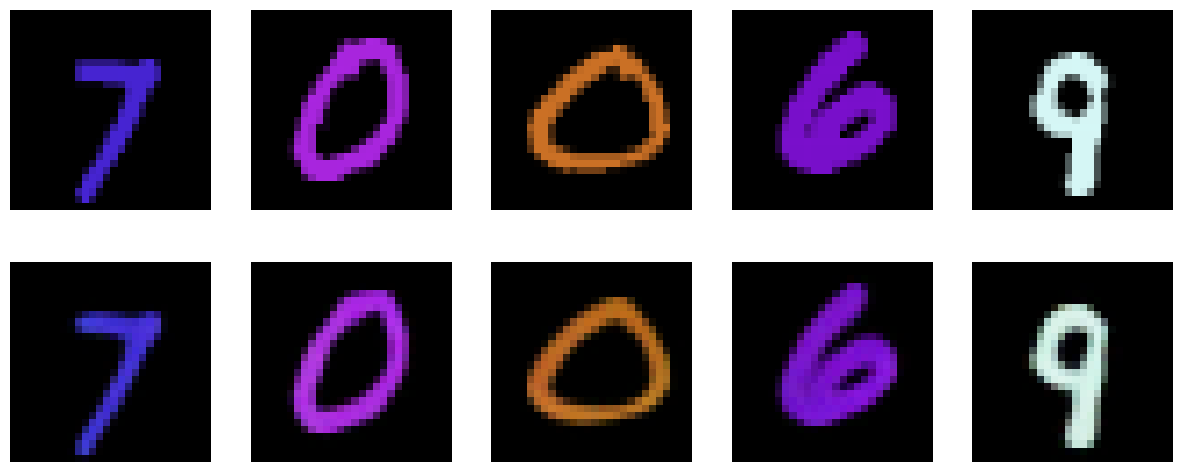


##################################################


VAE-MLP Epoch [13/15], Loss: 4.6129281826627754e-05


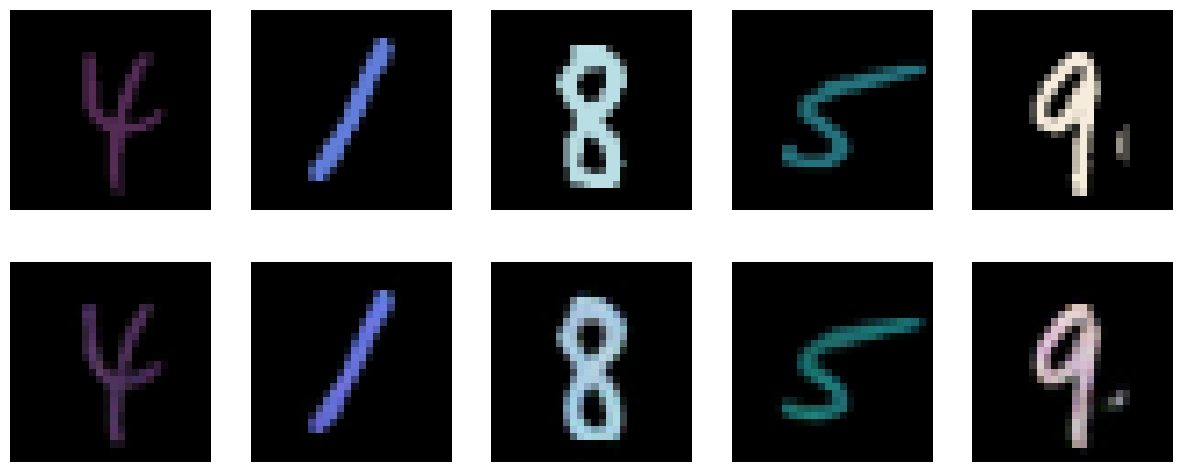


##################################################


VAE-MLP Epoch [14/15], Loss: 4.583977817092091e-05


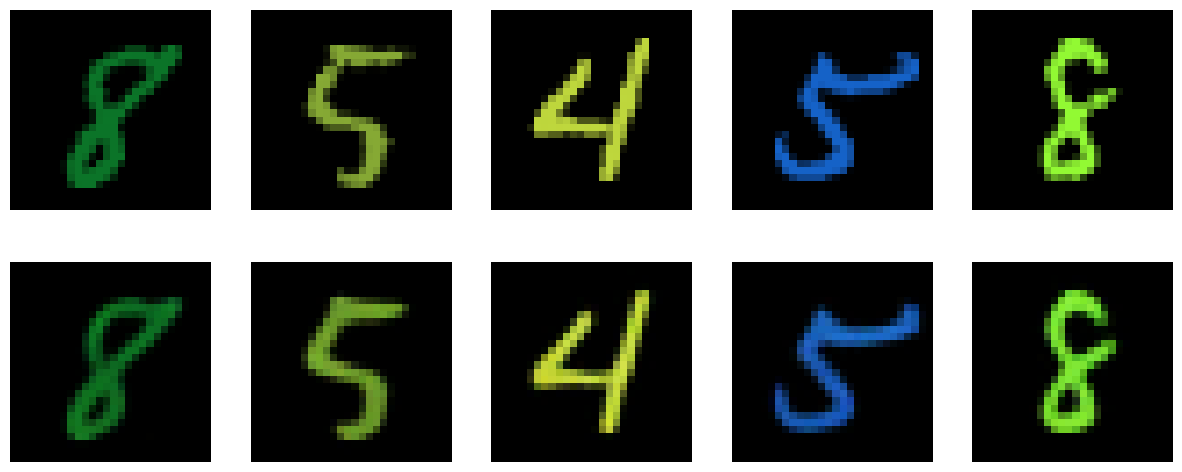


##################################################
VAE-MLP Epoch [15/15], Loss: 4.5421701887001595e-05


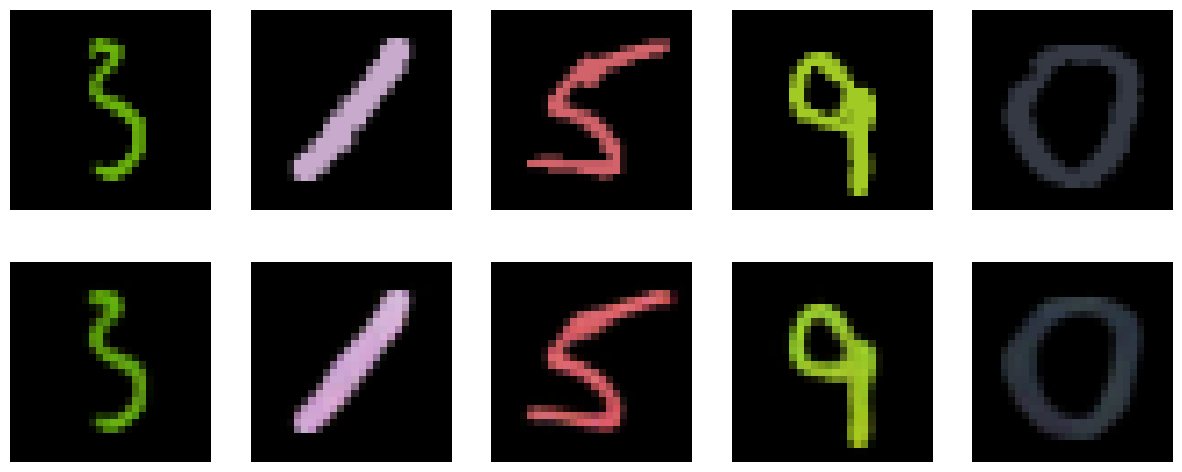

6.394250871665362e-05


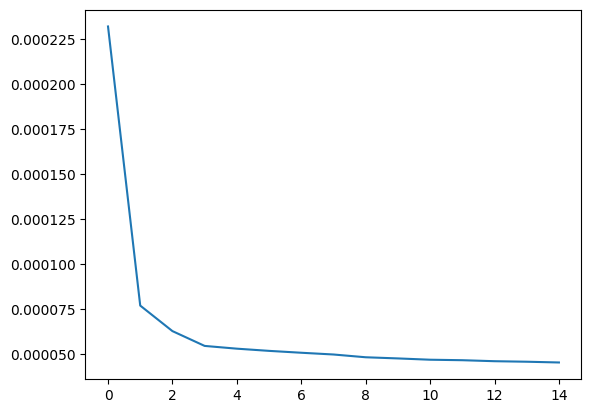

In [ ]:
vq_vae_5_embeddings = VQVAE_modified(in_channels=3, embedding_dim=2, num_embeddings=10)
train_three(vq_vae_5_embeddings, train_loader_colorful)



##################################################


VAE-MLP Epoch [1/15], Loss: 0.00037643317863500367


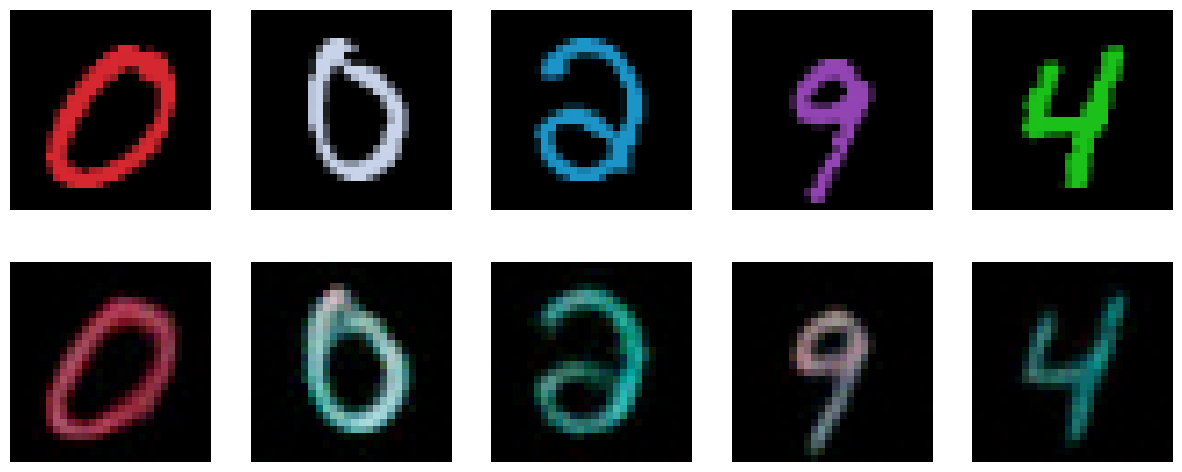


##################################################


VAE-MLP Epoch [2/15], Loss: 7.79023469464543e-05


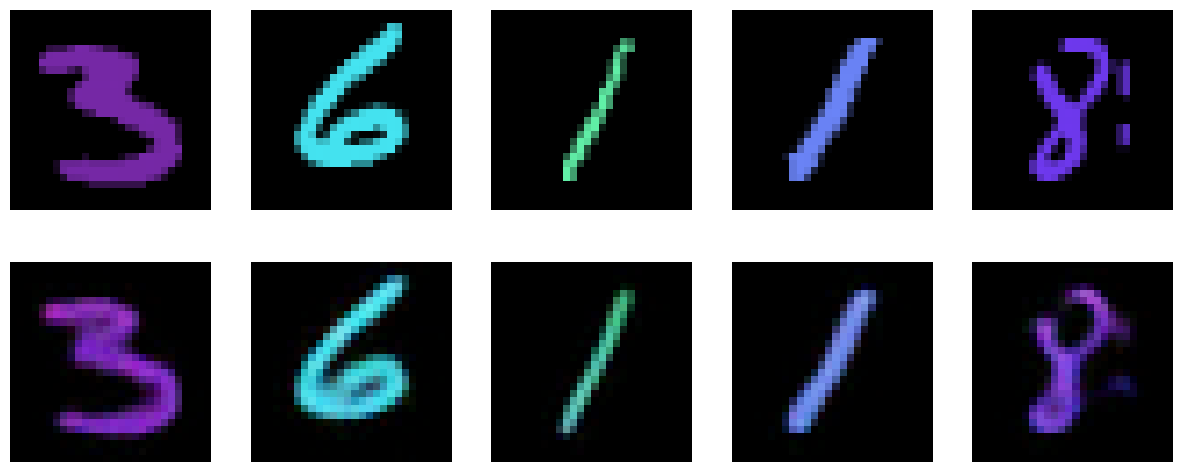


##################################################


VAE-MLP Epoch [3/15], Loss: 4.221657855280986e-05


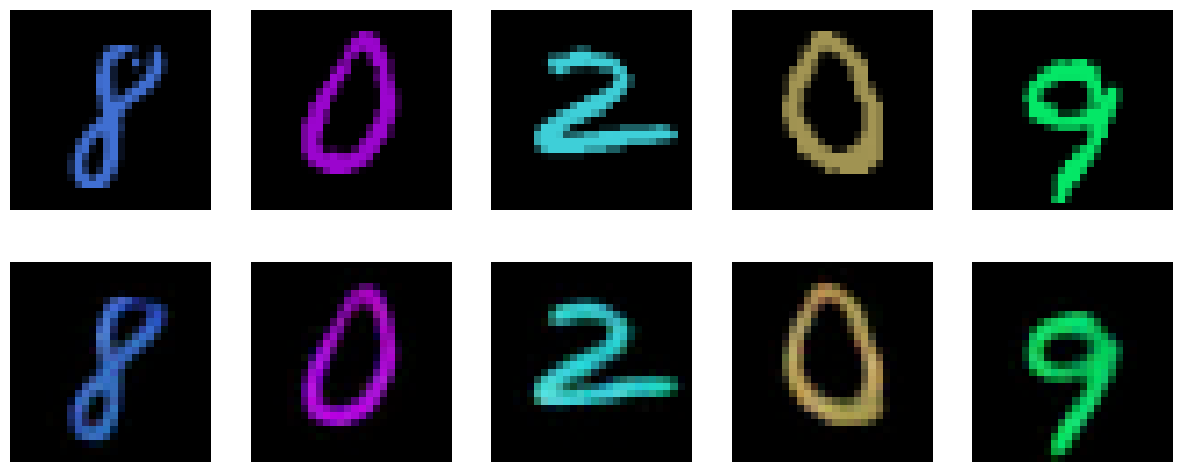


##################################################


VAE-MLP Epoch [4/15], Loss: 3.556726089057823e-05


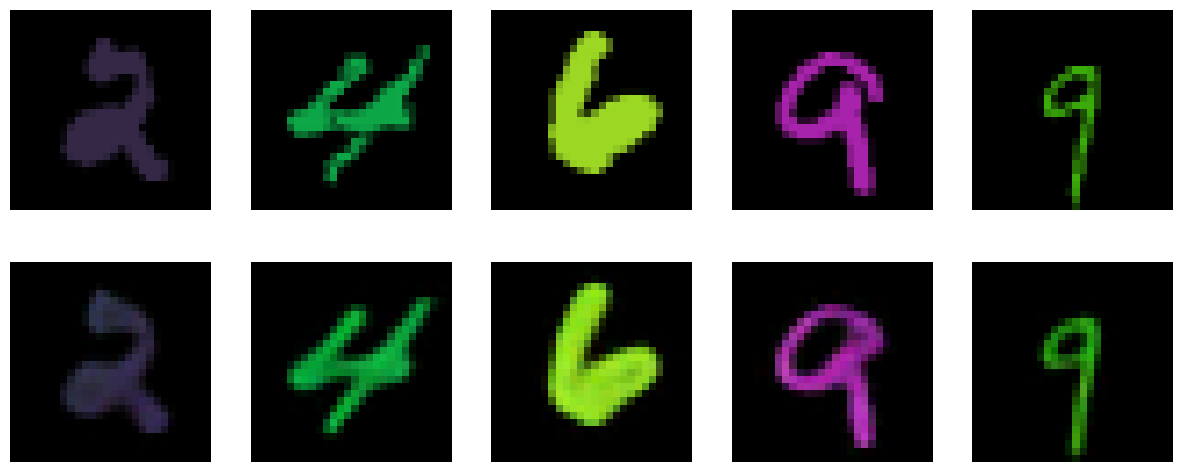


##################################################
VAE-MLP Epoch [5/15], Loss: 3.3492640134257576e-05


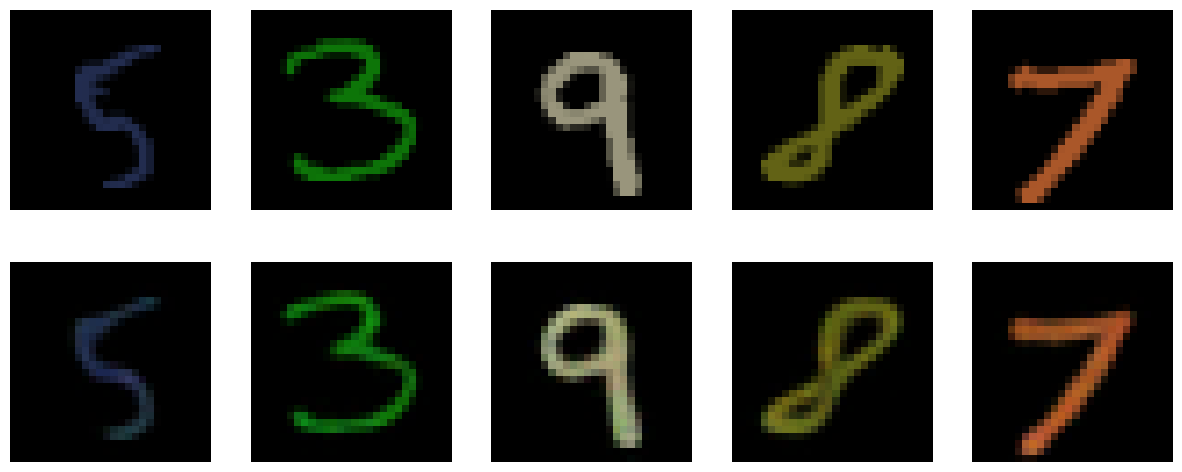


##################################################


VAE-MLP Epoch [6/15], Loss: 3.063732906981992e-05


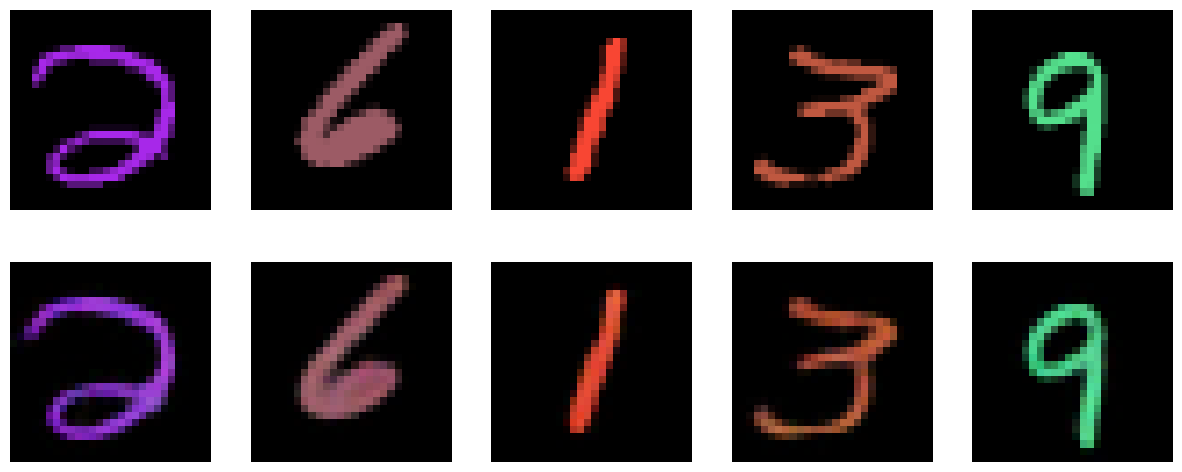


##################################################


VAE-MLP Epoch [7/15], Loss: 2.99110771525496e-05


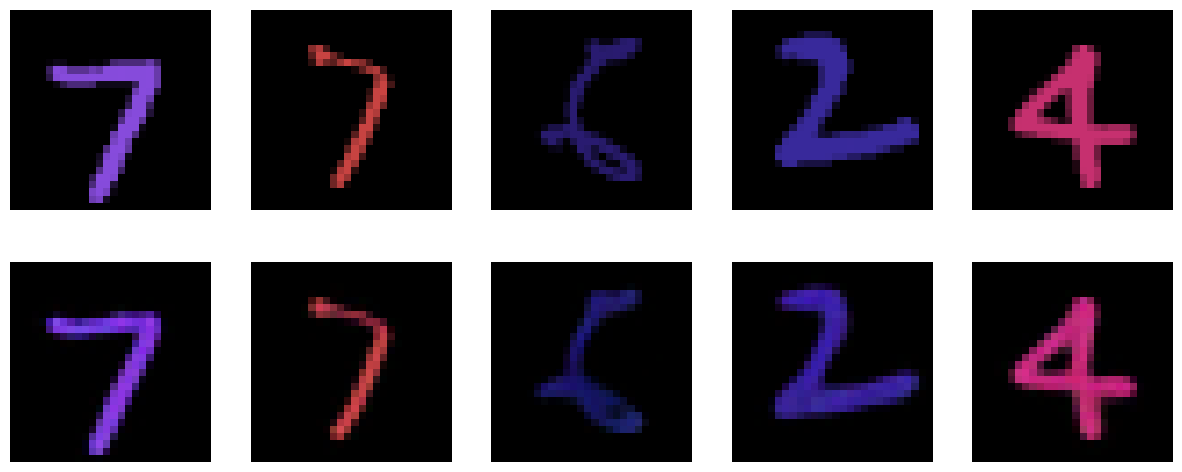


##################################################


VAE-MLP Epoch [8/15], Loss: 2.9469841780761878e-05


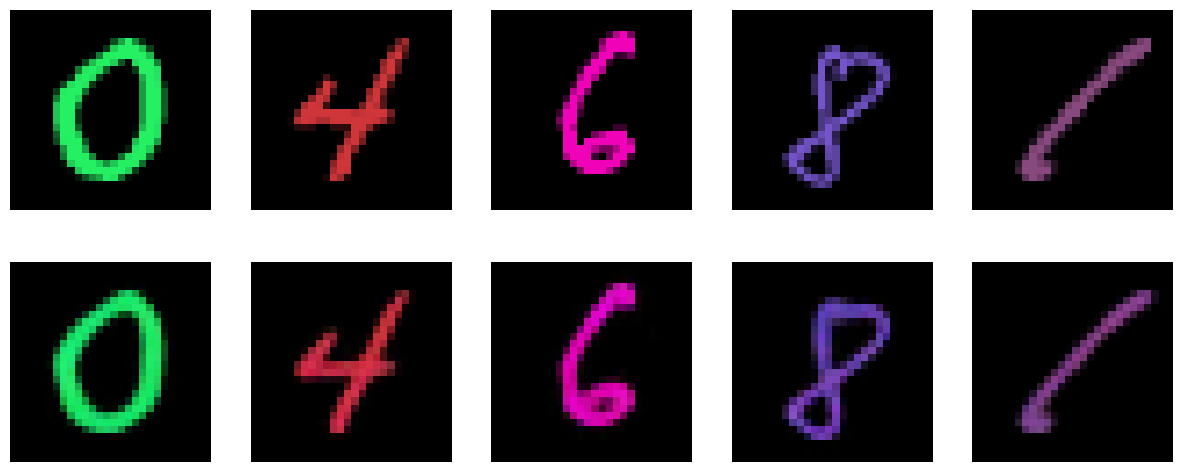


##################################################


VAE-MLP Epoch [9/15], Loss: 2.864672833820805e-05


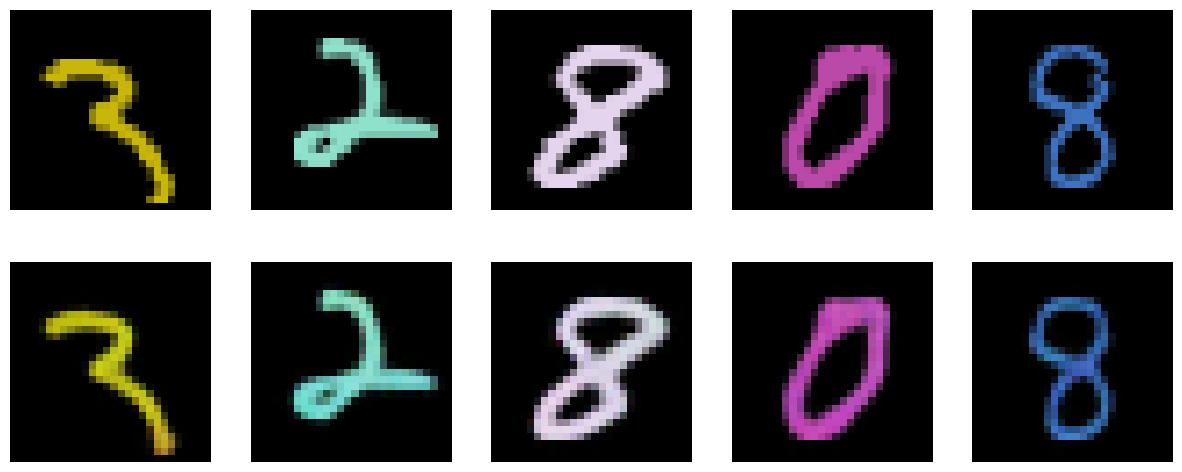


##################################################


VAE-MLP Epoch [10/15], Loss: 2.849772840272635e-05


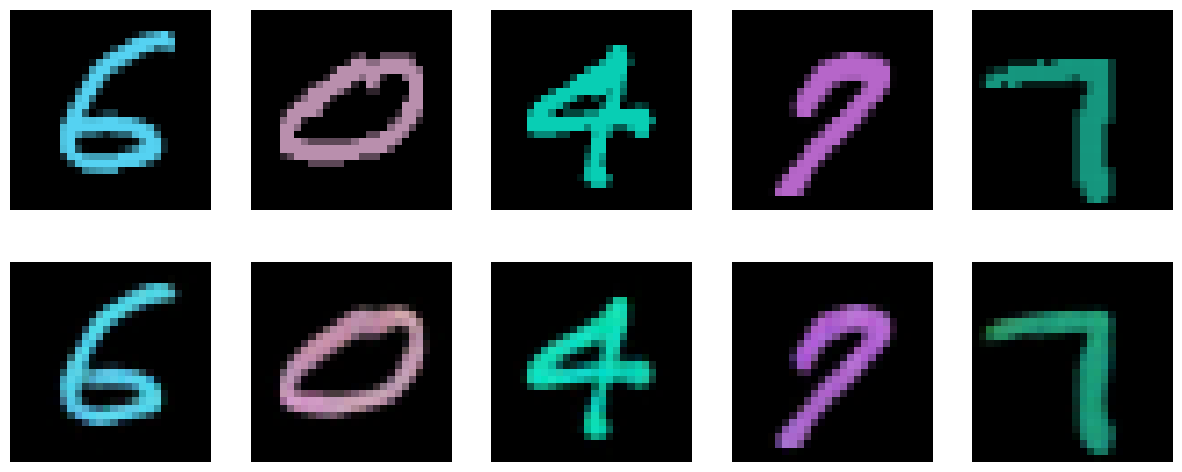


##################################################
VAE-MLP Epoch [11/15], Loss: 2.8200059935140114e-05


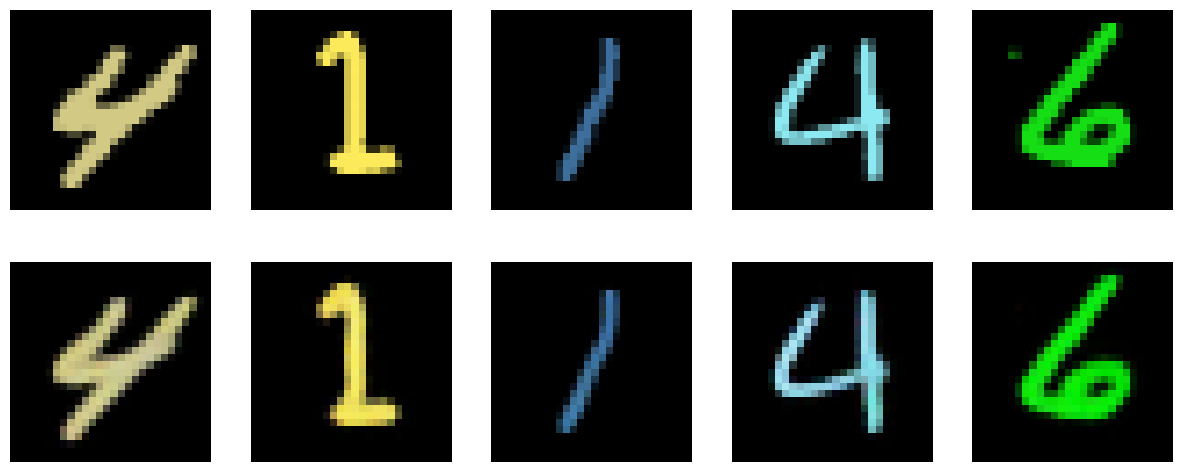


##################################################


VAE-MLP Epoch [12/15], Loss: 2.7727108768885955e-05


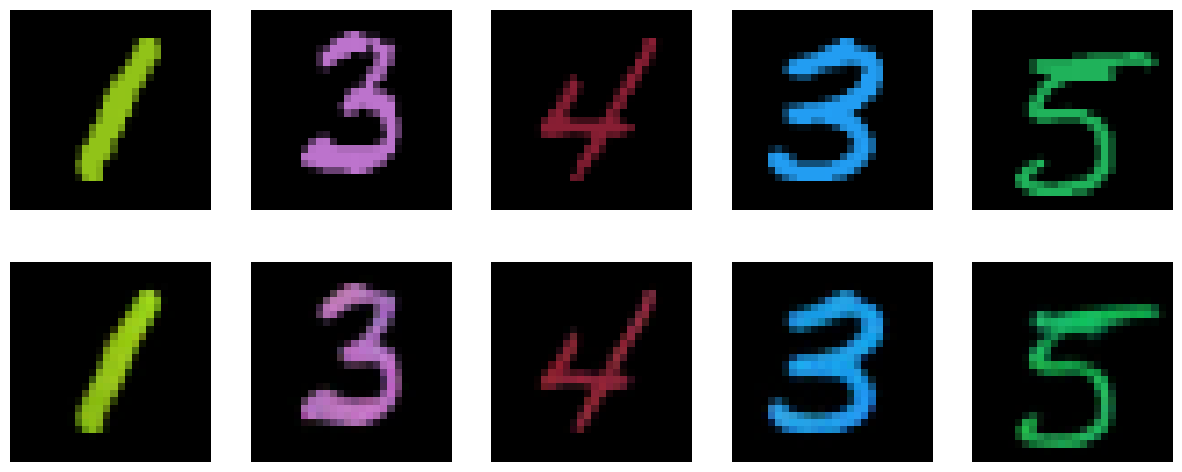


##################################################


VAE-MLP Epoch [13/15], Loss: 2.7371700218645856e-05


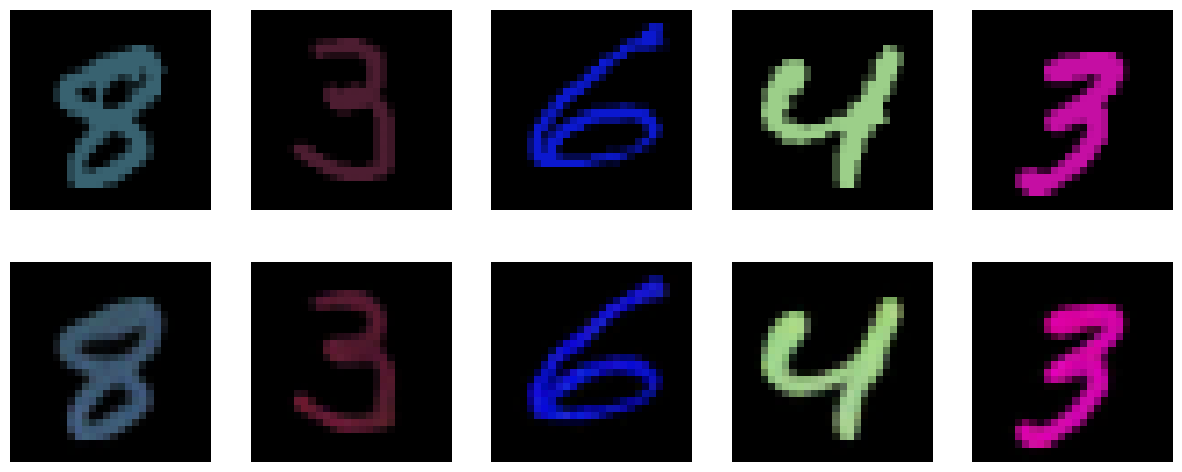


##################################################


VAE-MLP Epoch [14/15], Loss: 2.5464073601566877e-05


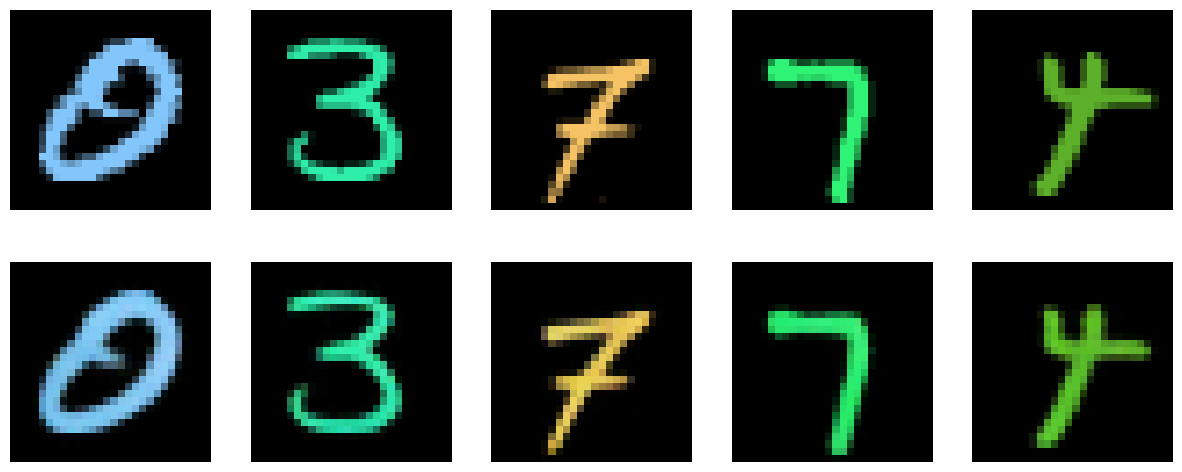


##################################################


VAE-MLP Epoch [15/15], Loss: 2.5340298881443837e-05


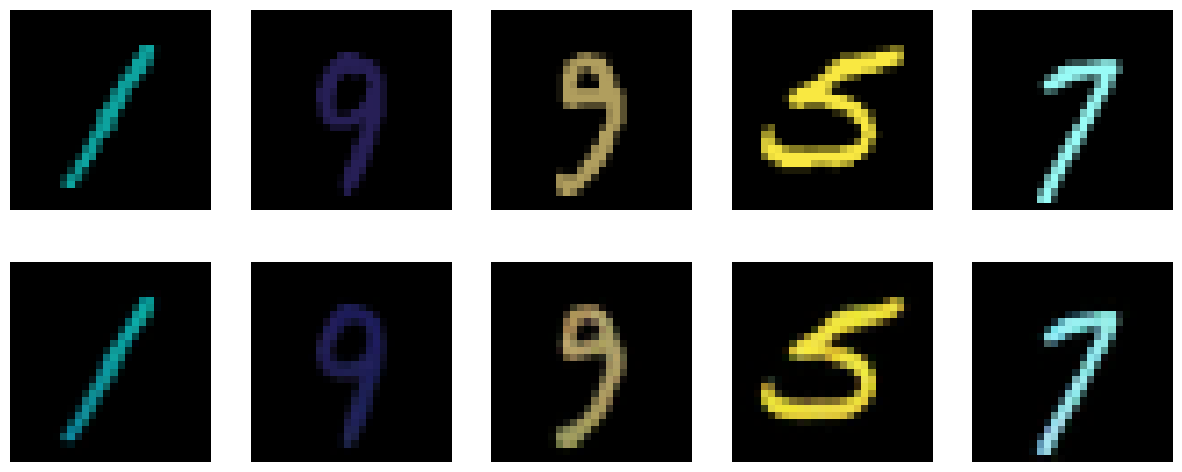

5.64585300872568e-05


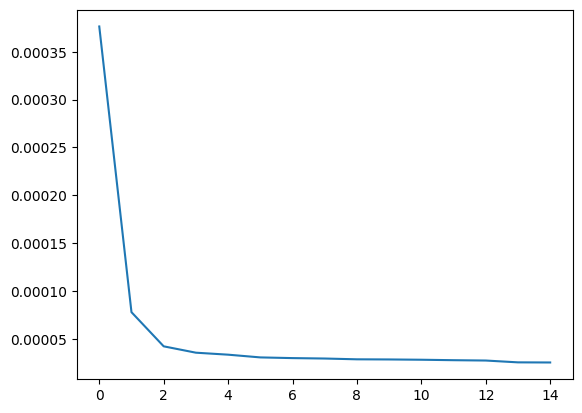

In [ ]:
vq_vae_5_embeddings = VQVAE_modified(in_channels=3, embedding_dim=2, num_embeddings=20)
train_three(vq_vae_5_embeddings, train_loader_colorful)



##################################################
VAE-MLP Epoch [1/15], Loss: 0.00039810077122723065


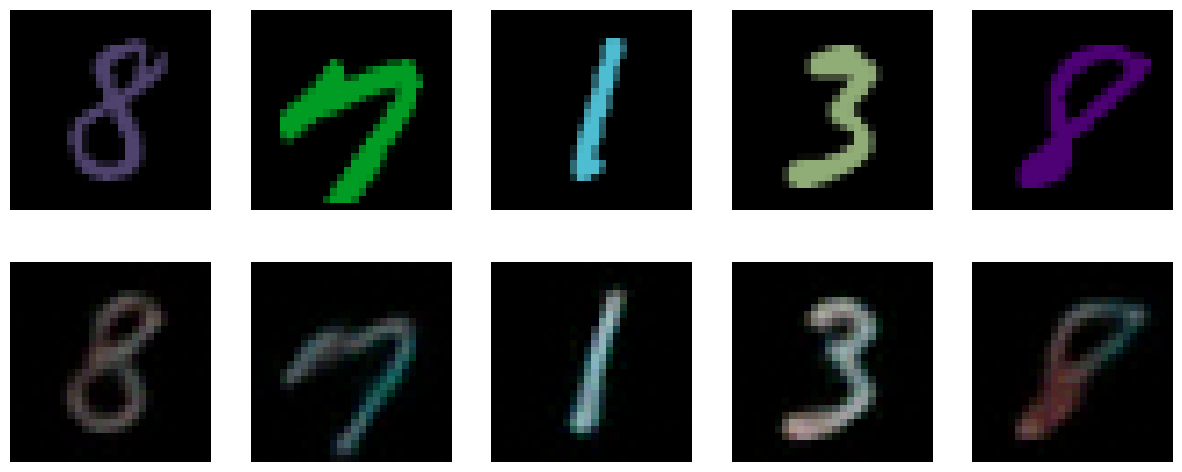


##################################################


VAE-MLP Epoch [2/15], Loss: 0.00010899483675214772


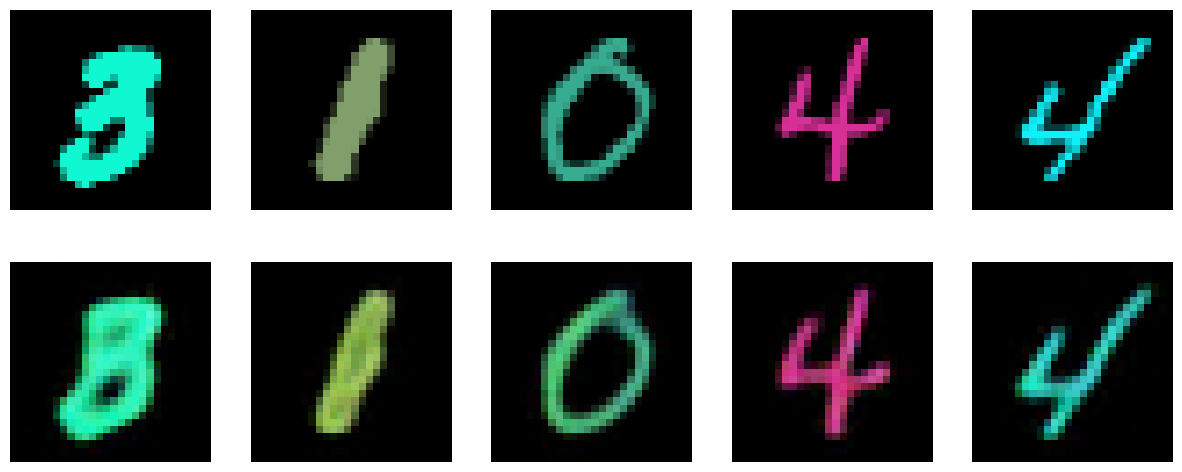


##################################################


VAE-MLP Epoch [3/15], Loss: 4.090769602335058e-05


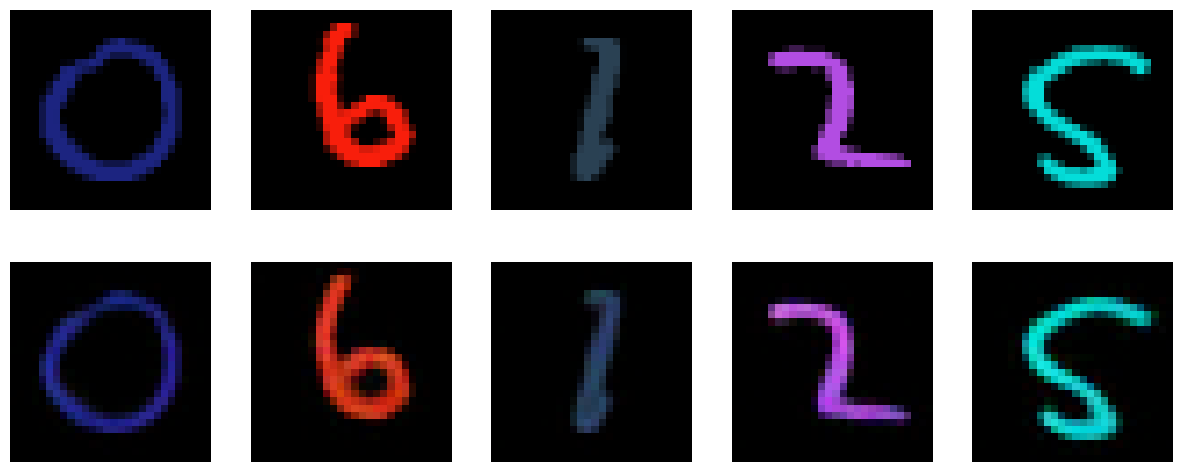


##################################################


VAE-MLP Epoch [4/15], Loss: 2.9125836357707157e-05


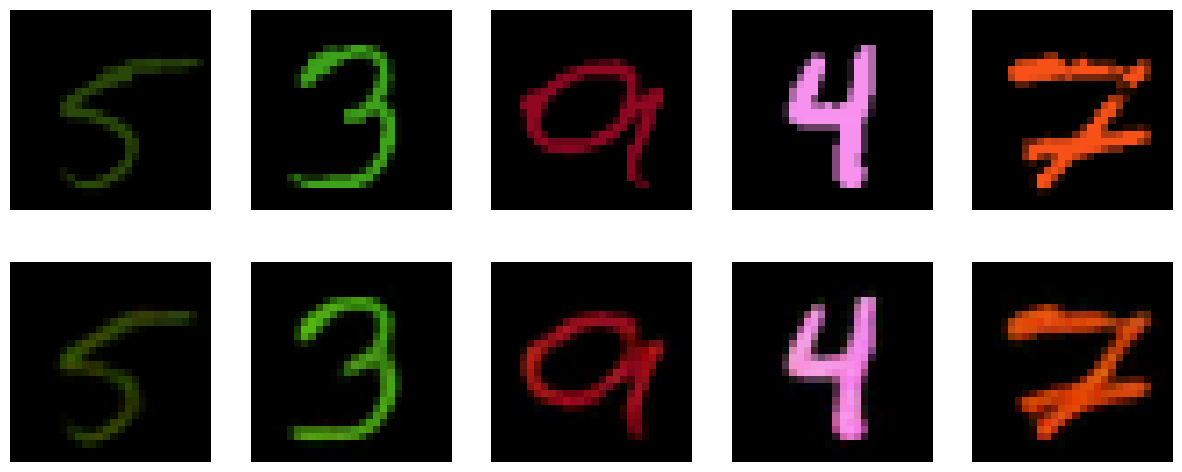


##################################################
VAE-MLP Epoch [5/15], Loss: 2.5479435627736772e-05


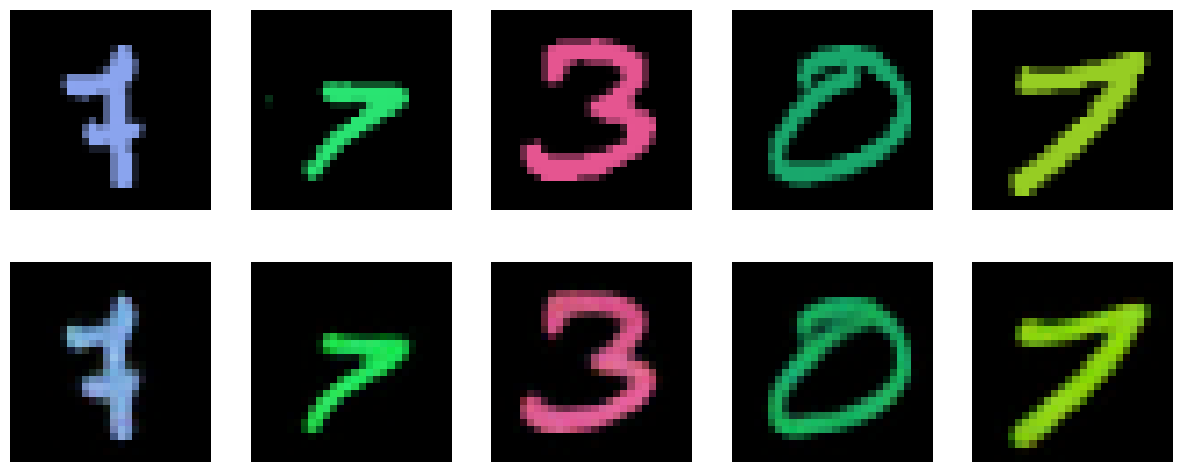


##################################################
VAE-MLP Epoch [6/15], Loss: 2.2433655088146526e-05


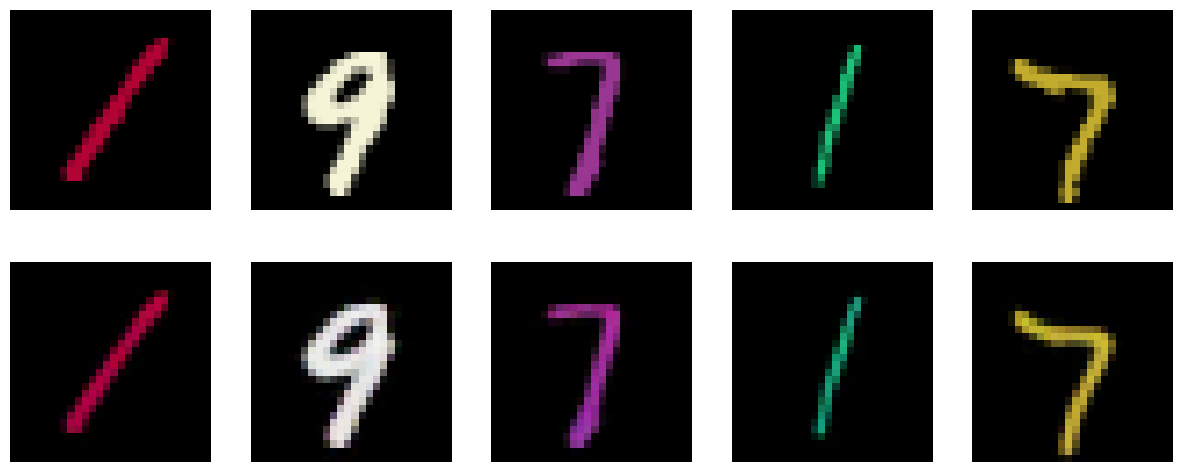


##################################################


VAE-MLP Epoch [7/15], Loss: 2.1050064182297016e-05


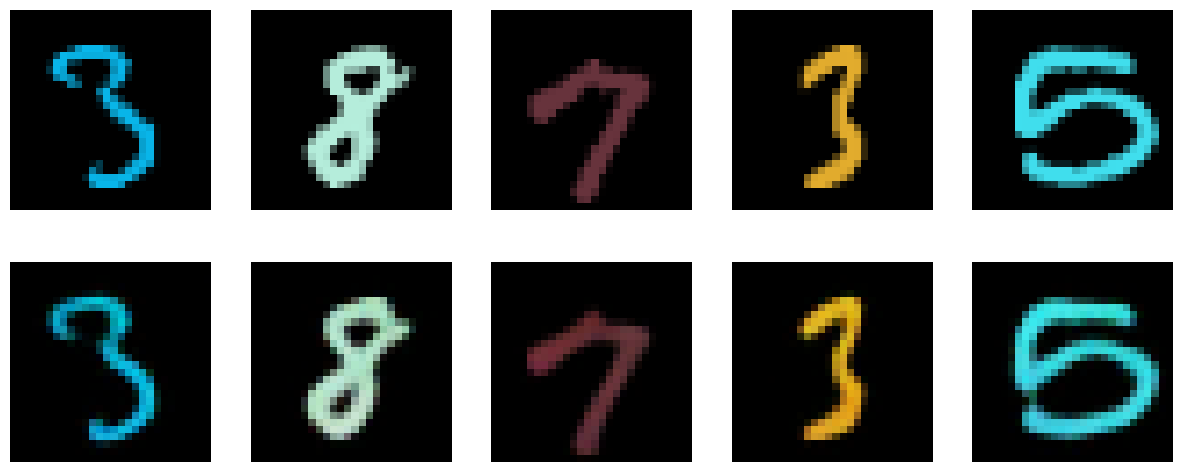


##################################################


VAE-MLP Epoch [8/15], Loss: 1.9572204132176316e-05


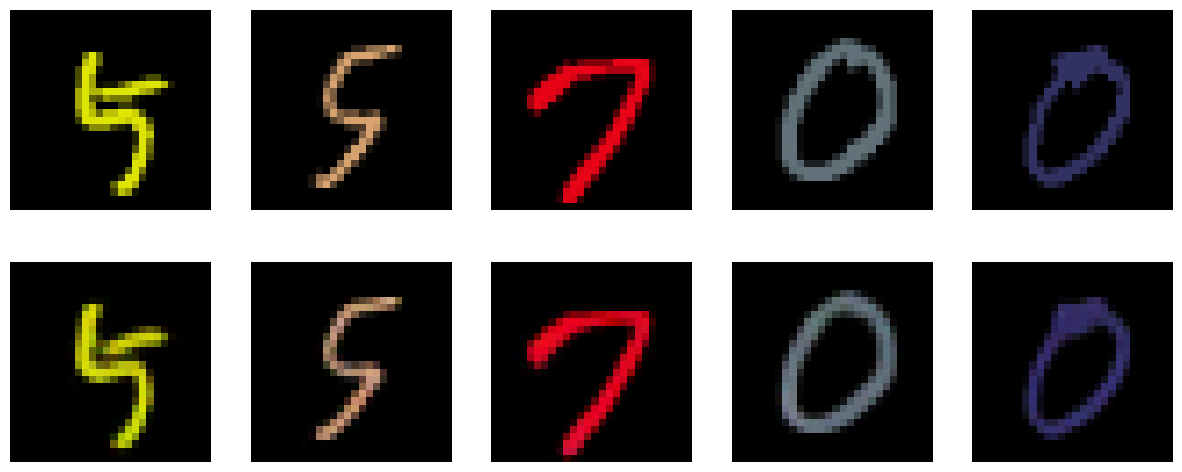


##################################################


VAE-MLP Epoch [9/15], Loss: 1.8289323513939356e-05


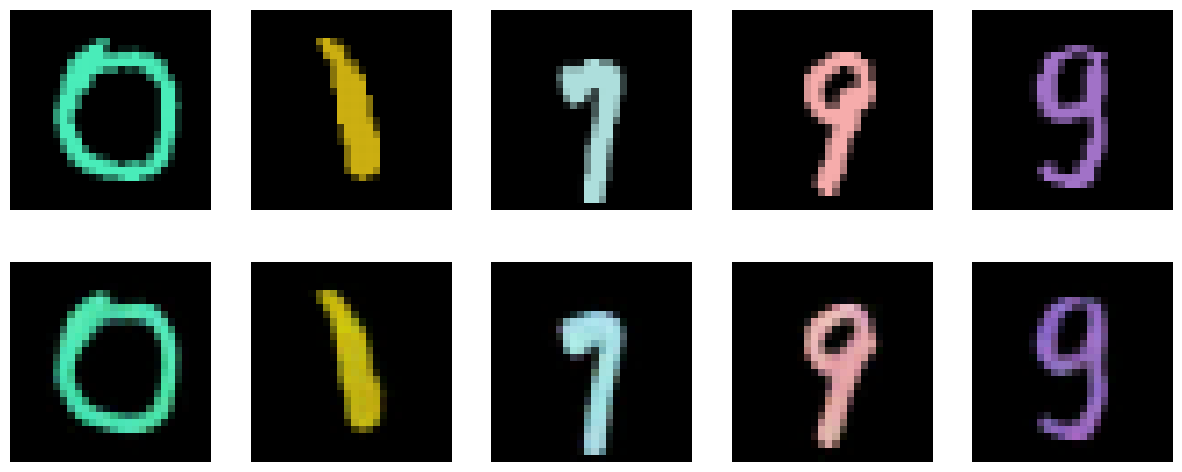


##################################################


VAE-MLP Epoch [10/15], Loss: 1.7984041420277208e-05


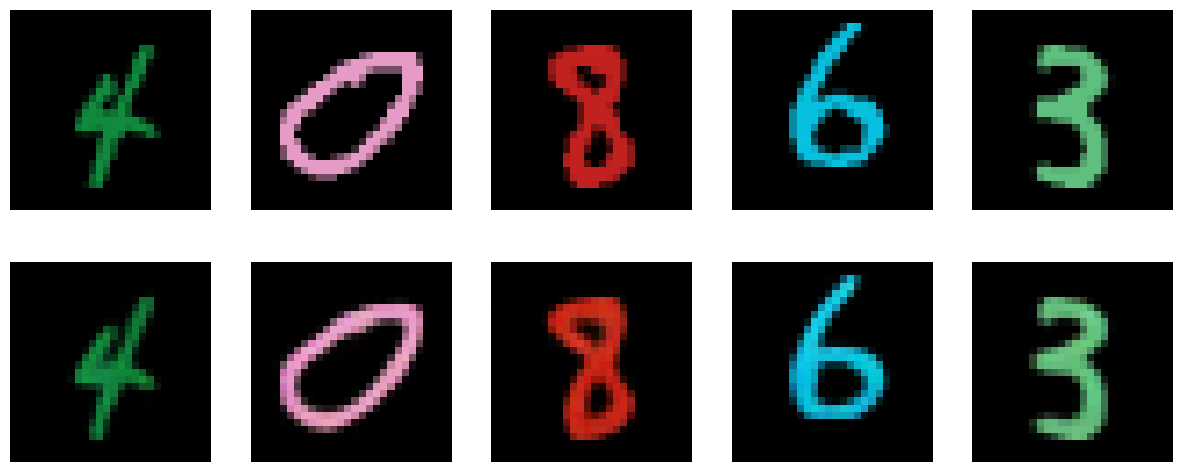


##################################################
VAE-MLP Epoch [11/15], Loss: 1.788337351560282e-05


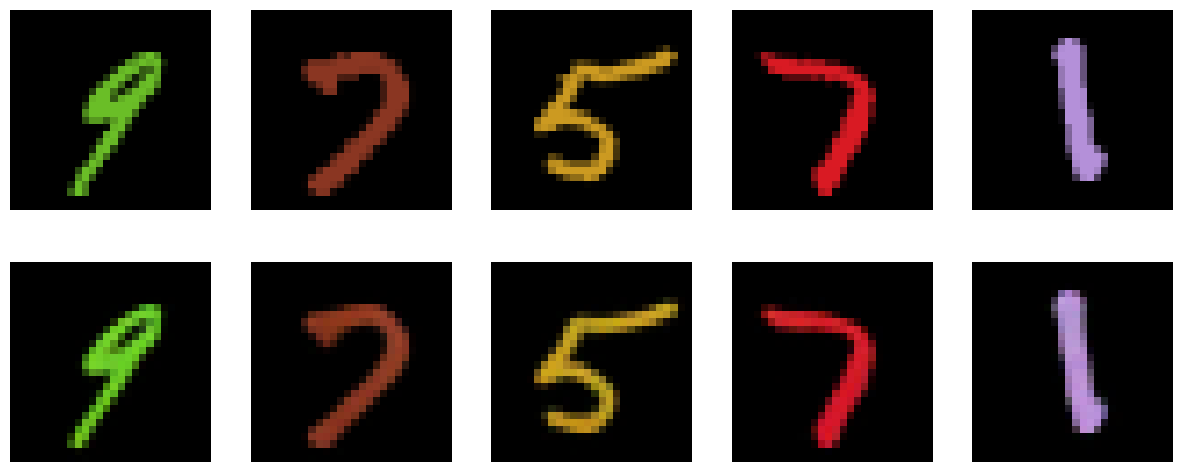


##################################################


VAE-MLP Epoch [12/15], Loss: 1.7711038945708424e-05


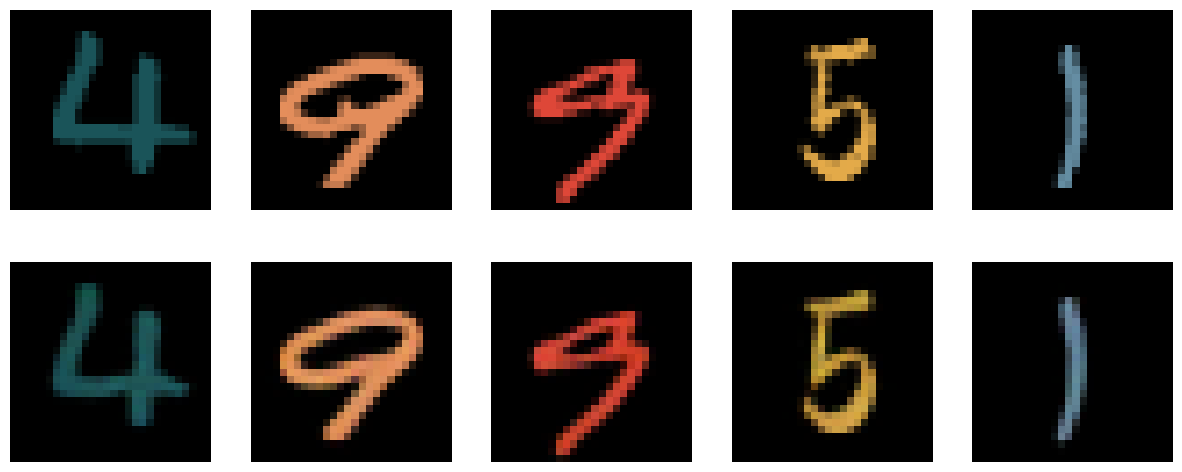


##################################################


VAE-MLP Epoch [13/15], Loss: 1.7828708976351967e-05


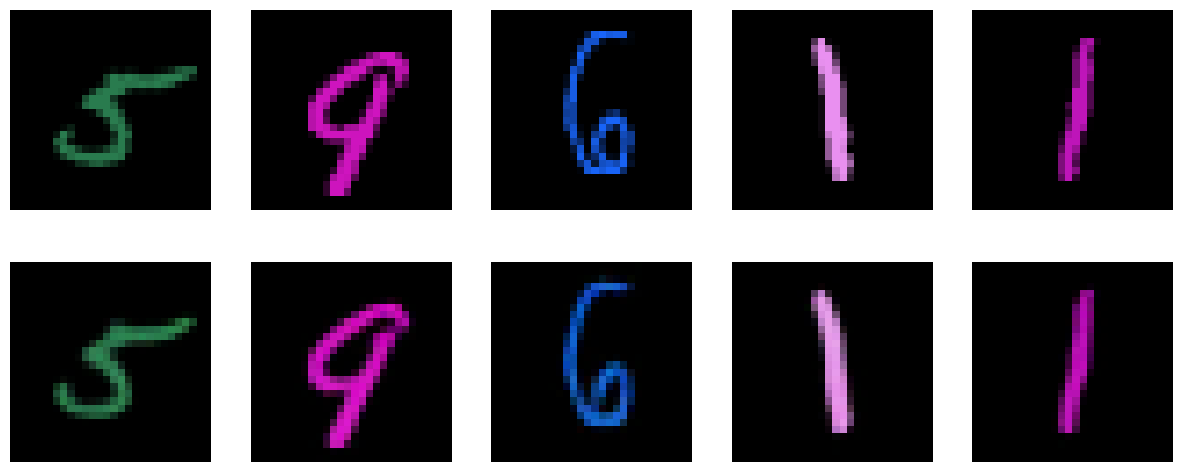


##################################################


VAE-MLP Epoch [14/15], Loss: 1.7804572370368987e-05


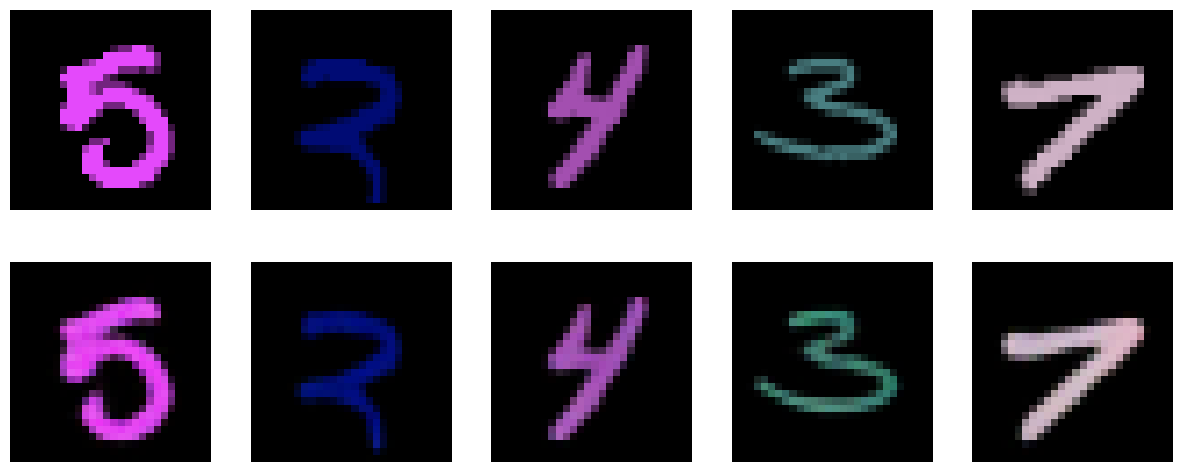


##################################################


VAE-MLP Epoch [15/15], Loss: 1.784174707815206e-05


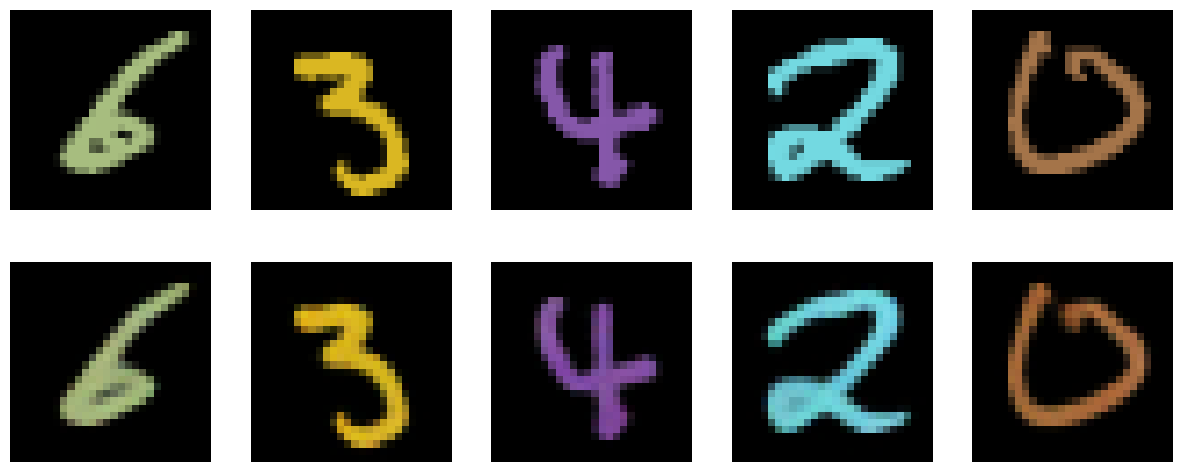

5.273382034741291e-05


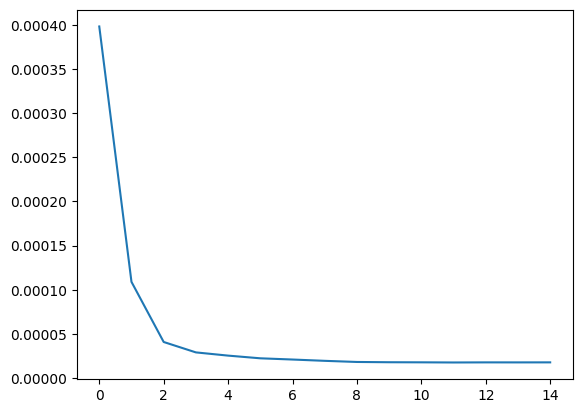

In [ ]:
vq_vae_5_embeddings = VQVAE_modified(in_channels=3, embedding_dim=2, num_embeddings=30)
train_three(vq_vae_5_embeddings, train_loader_colorful)



##################################################
VAE-MLP Epoch [1/15], Loss: 0.007306436598828683


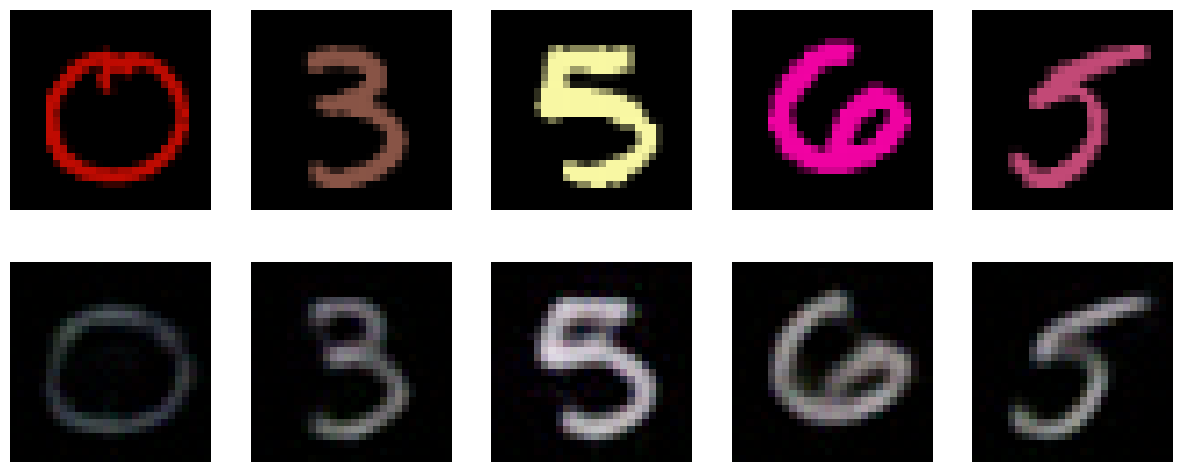


##################################################


VAE-MLP Epoch [2/15], Loss: 9.836003919675325e-05


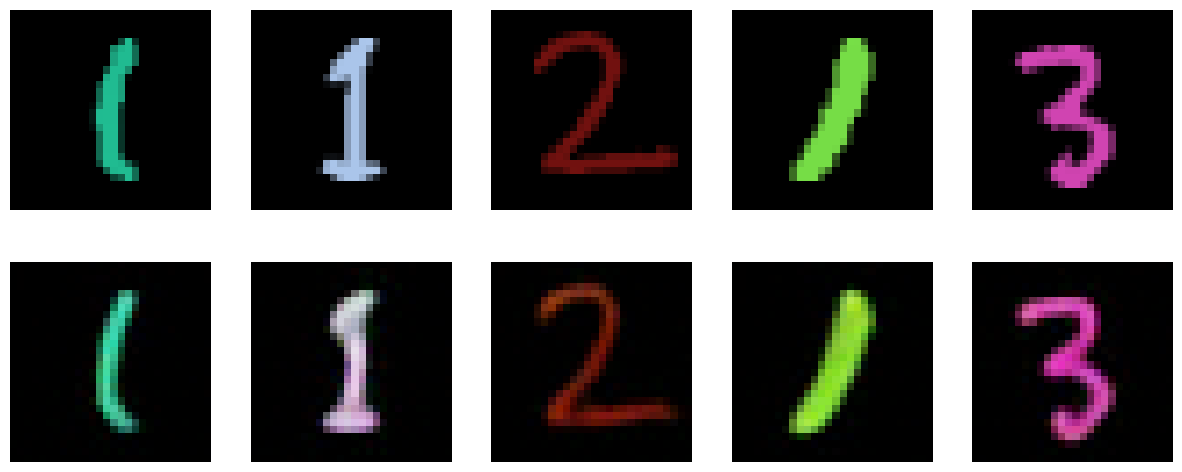


##################################################


VAE-MLP Epoch [3/15], Loss: 3.9094495909133306e-05


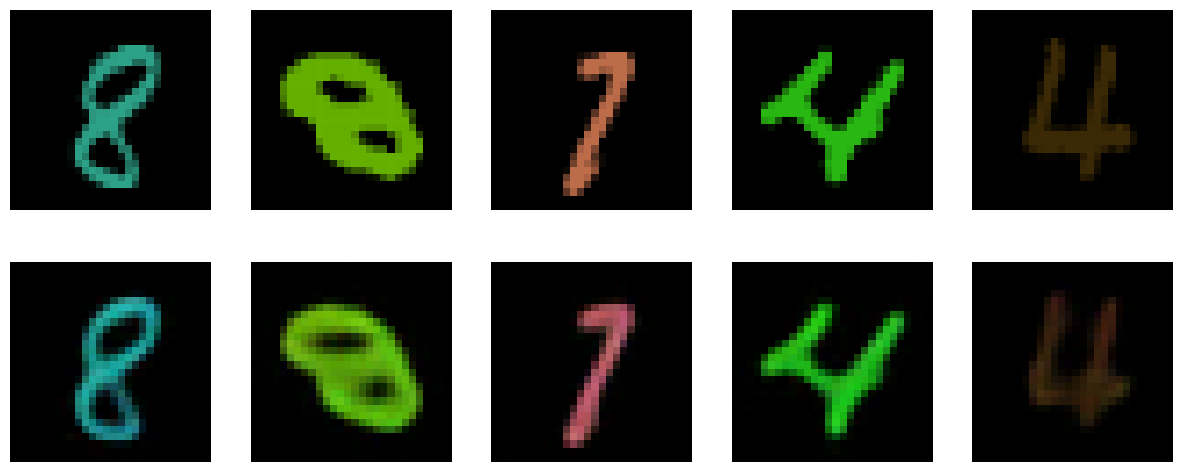


##################################################


VAE-MLP Epoch [4/15], Loss: 3.0326445002962526e-05


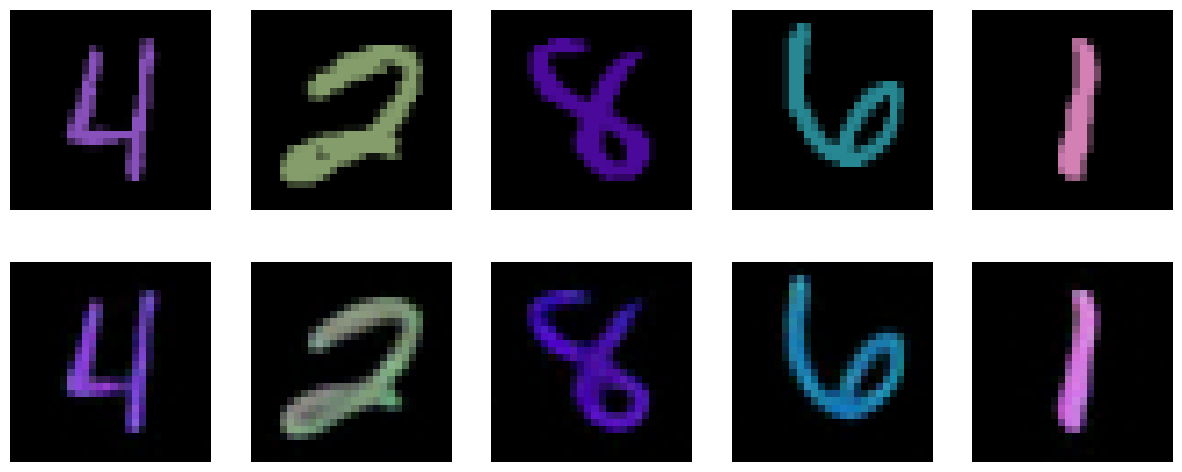


##################################################


VAE-MLP Epoch [5/15], Loss: 2.637540561069424e-05


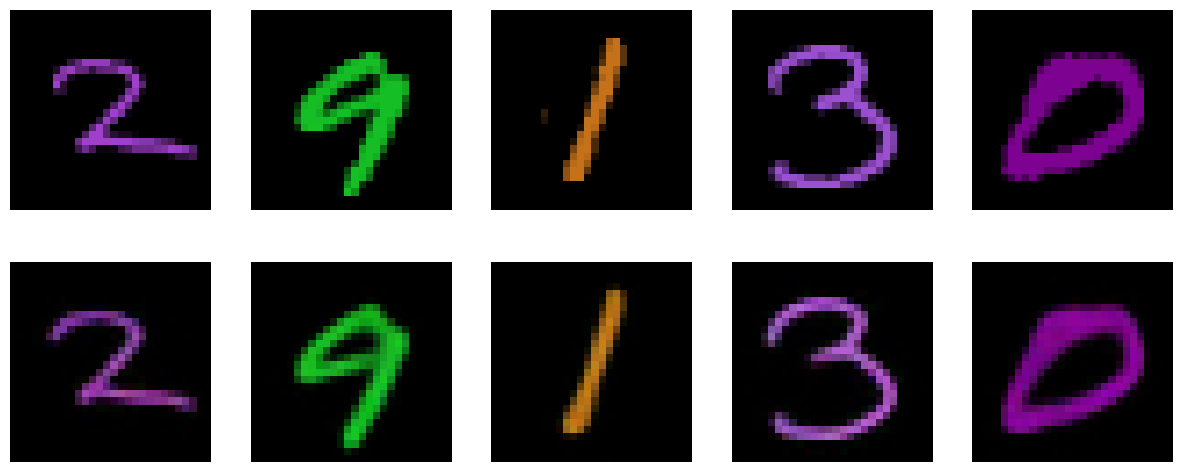


##################################################


VAE-MLP Epoch [6/15], Loss: 2.5003525952342897e-05


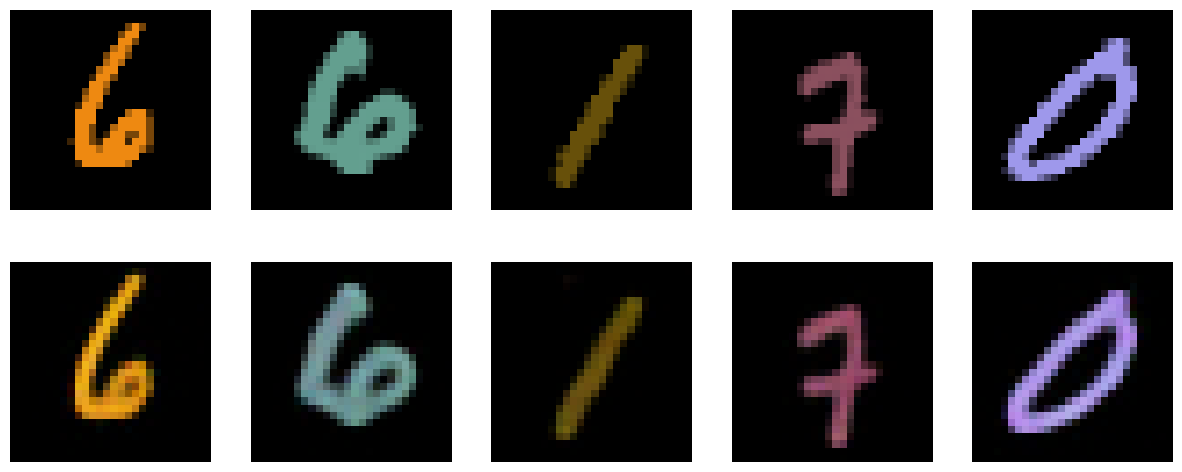


##################################################


VAE-MLP Epoch [7/15], Loss: 2.2808067017467692e-05


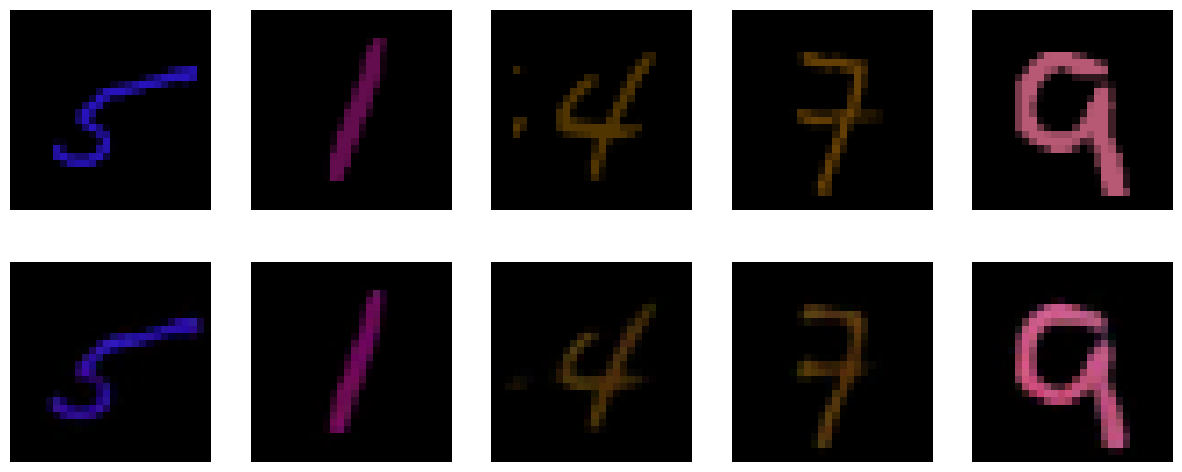


##################################################


VAE-MLP Epoch [8/15], Loss: 2.2144398260085534e-05


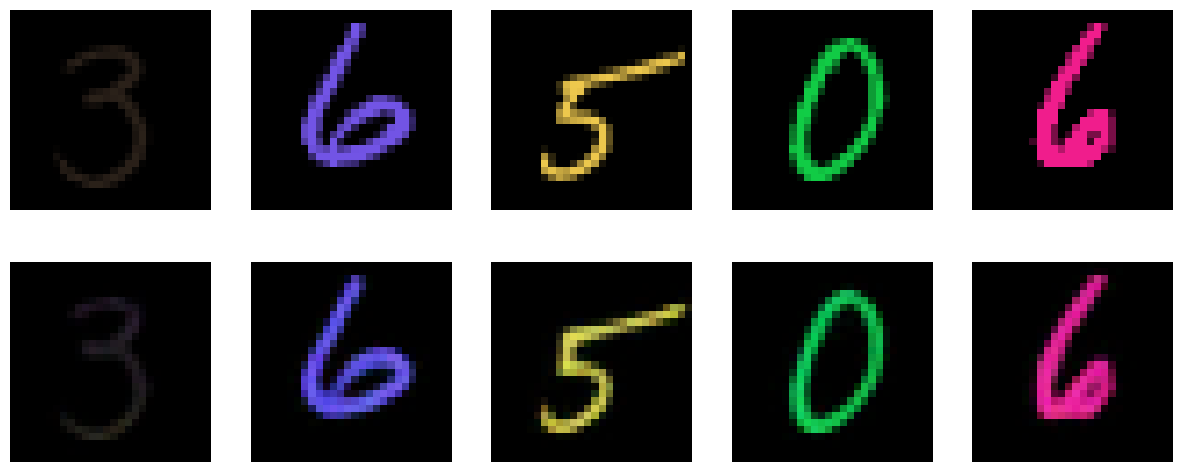


##################################################


VAE-MLP Epoch [9/15], Loss: 2.1393791503699808e-05


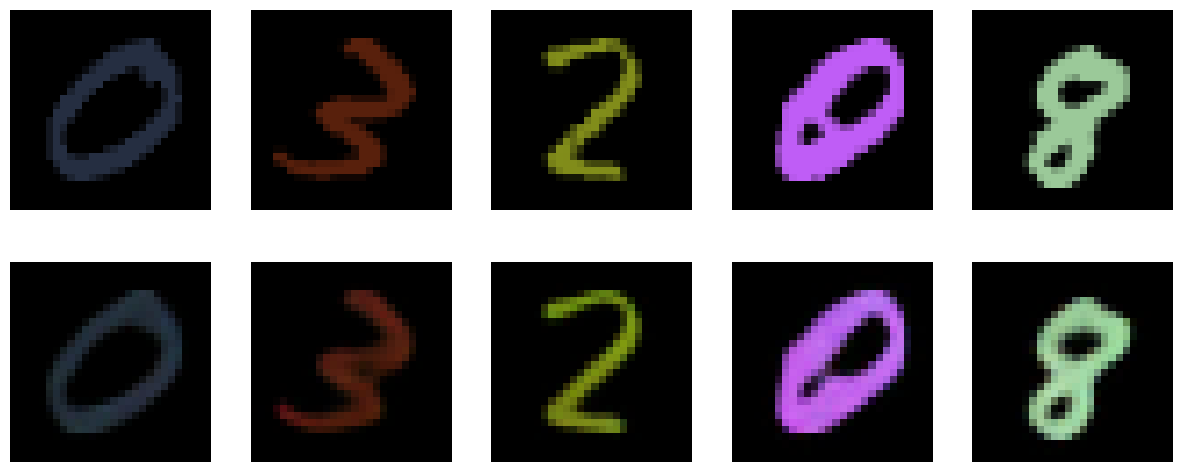


##################################################


VAE-MLP Epoch [10/15], Loss: 1.930142921919469e-05


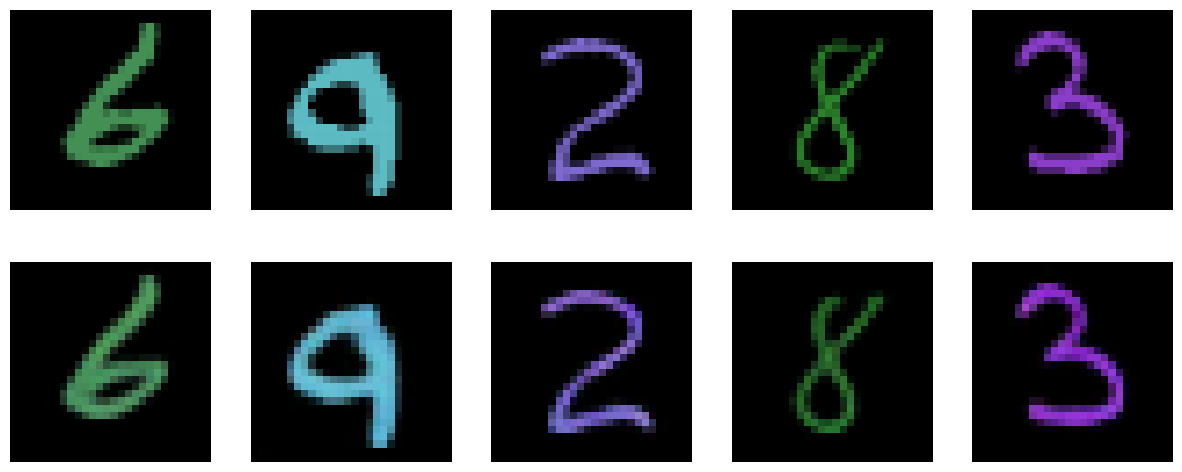


##################################################


VAE-MLP Epoch [11/15], Loss: 1.9183140940731392e-05


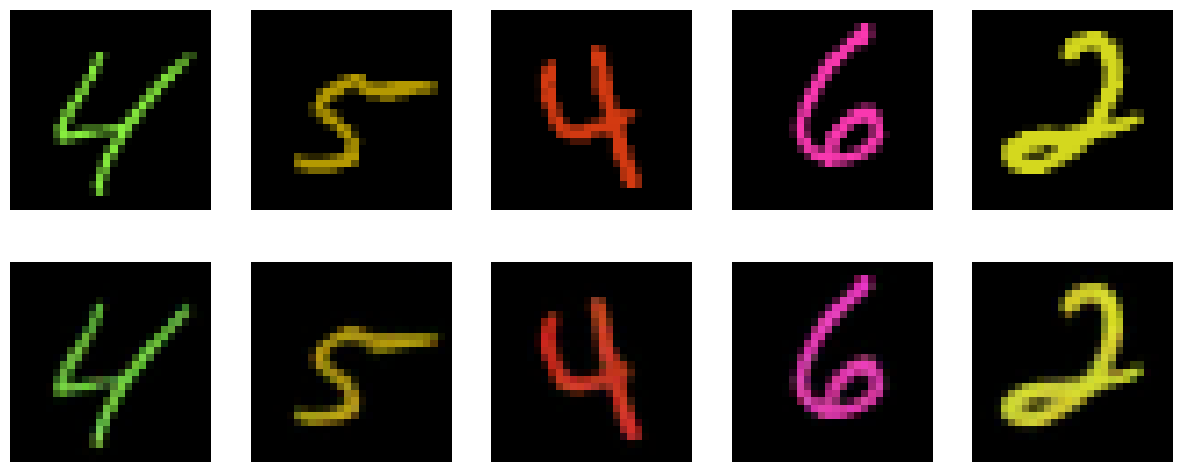


##################################################
VAE-MLP Epoch [12/15], Loss: 1.8898822686363323e-05


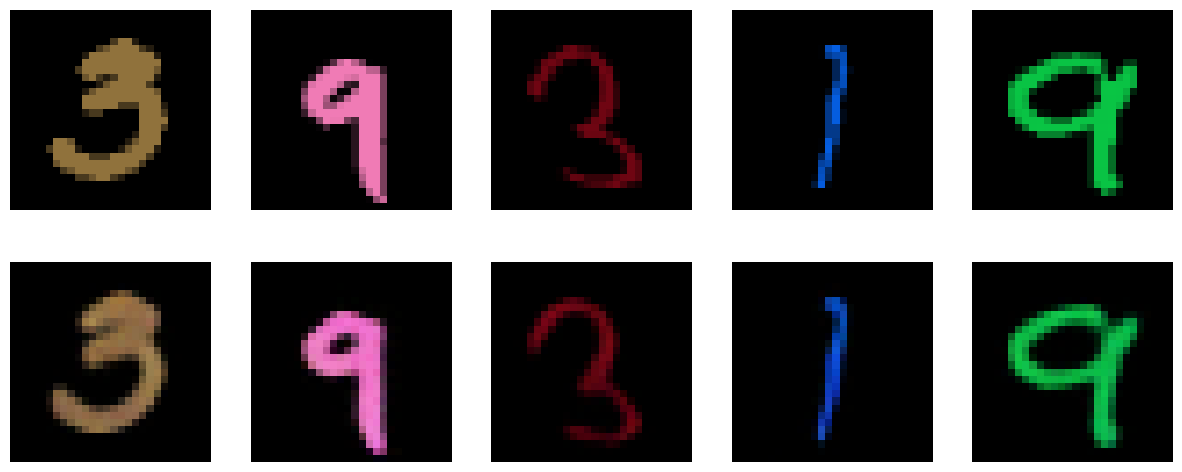


##################################################


VAE-MLP Epoch [13/15], Loss: 1.8417410118854604e-05


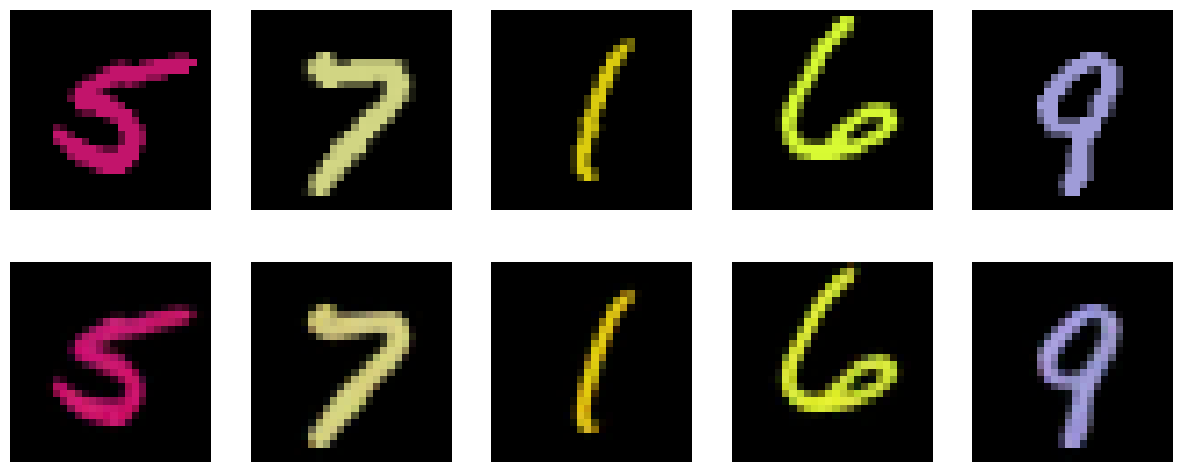


##################################################


VAE-MLP Epoch [14/15], Loss: 1.812265401822515e-05


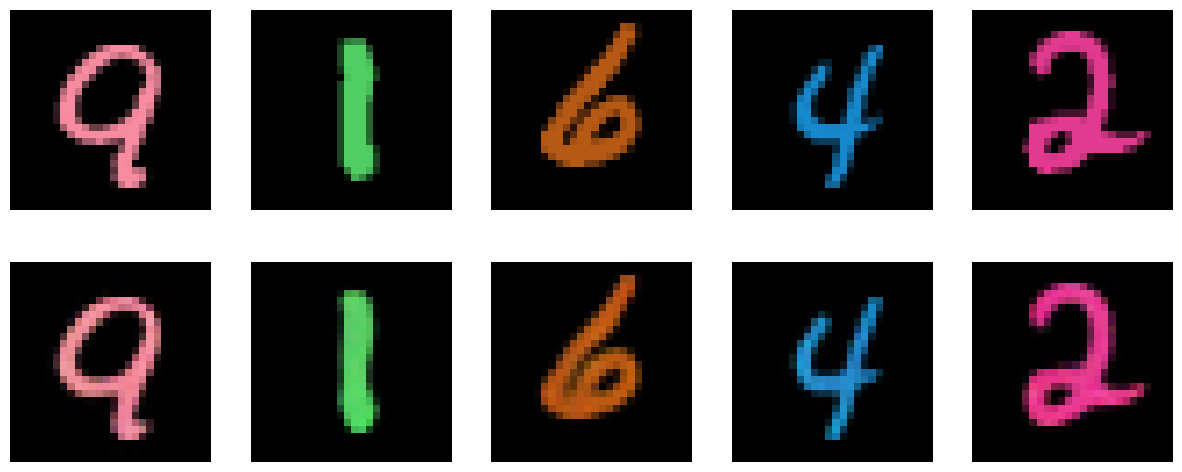


##################################################


VAE-MLP Epoch [15/15], Loss: 1.7595435028003218e-05


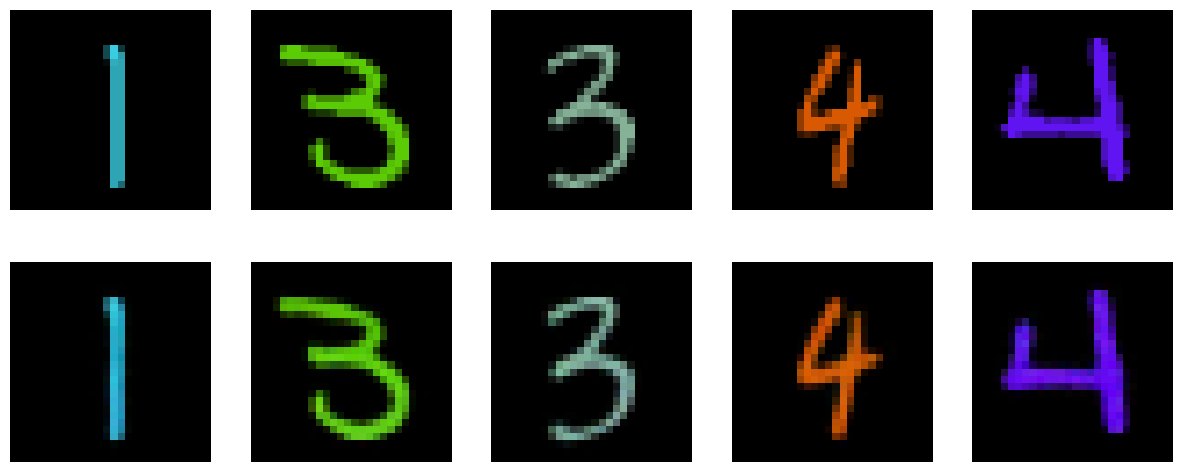

0.0005135641106195462


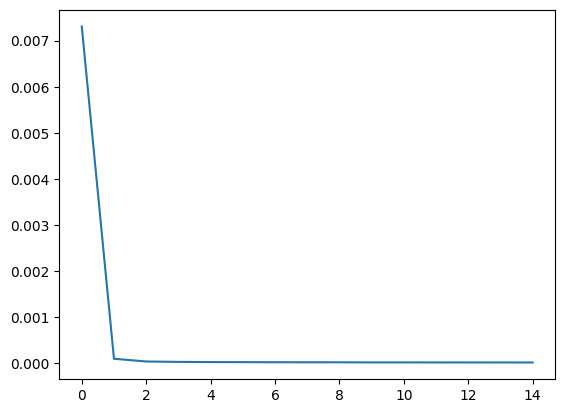

In [ ]:
vq_vae_5_embeddings = VQVAE_modified(in_channels=3, embedding_dim=2, num_embeddings=40)
train_three(vq_vae_5_embeddings, train_loader_colorful)



##################################################


VAE-MLP Epoch [1/15], Loss: 0.00021314986429642885


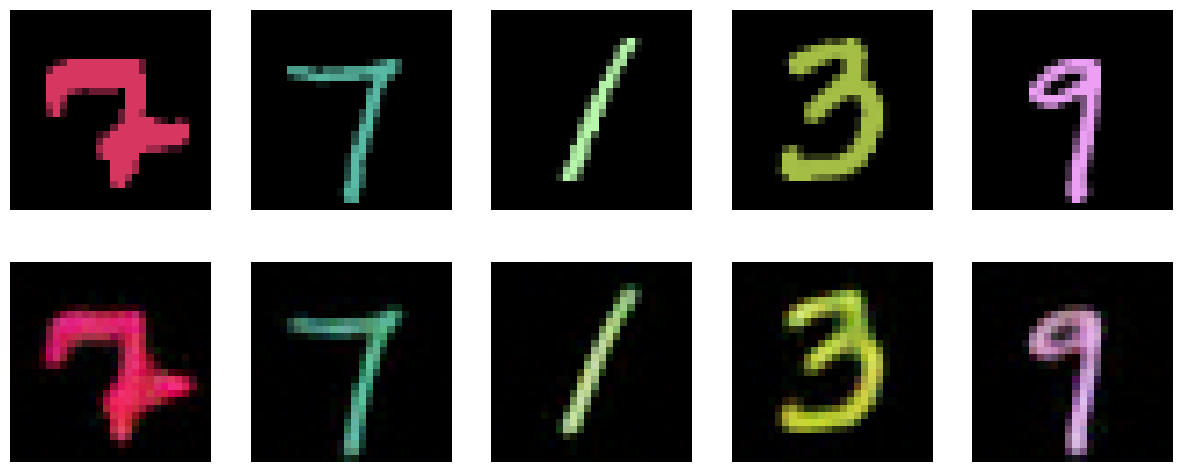


##################################################


VAE-MLP Epoch [2/15], Loss: 3.609620043619846e-05


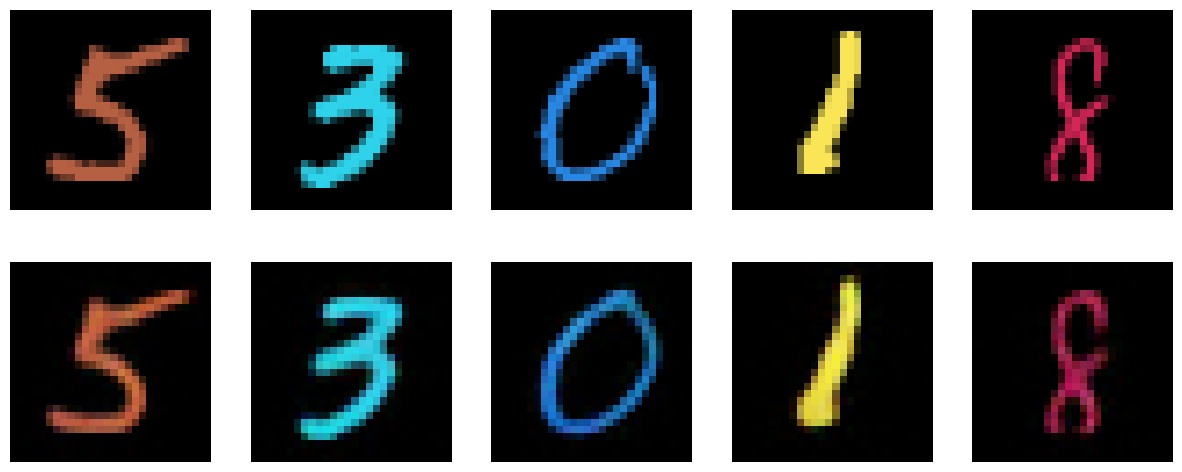


##################################################


VAE-MLP Epoch [3/15], Loss: 2.6212901633698494e-05


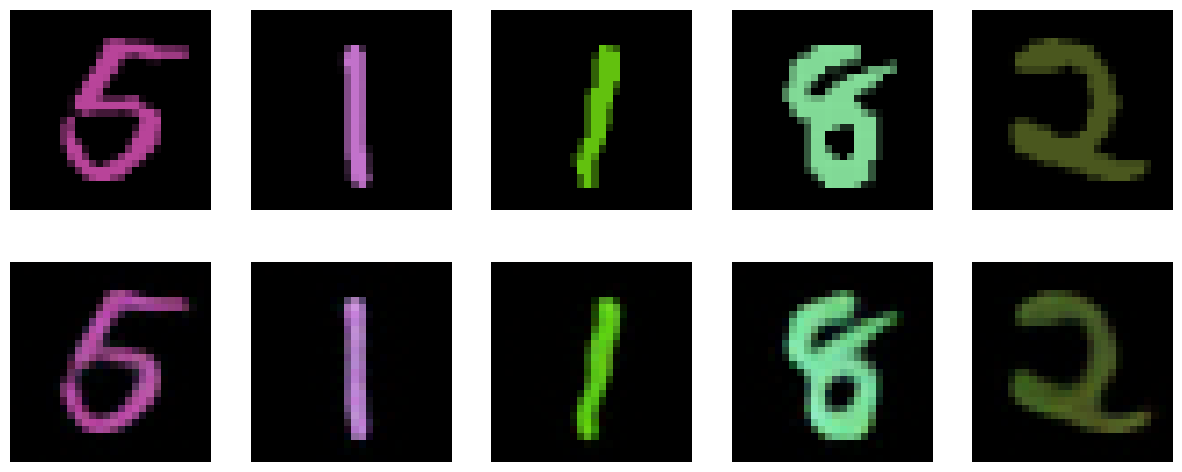


##################################################


VAE-MLP Epoch [4/15], Loss: 2.2521005165375147e-05


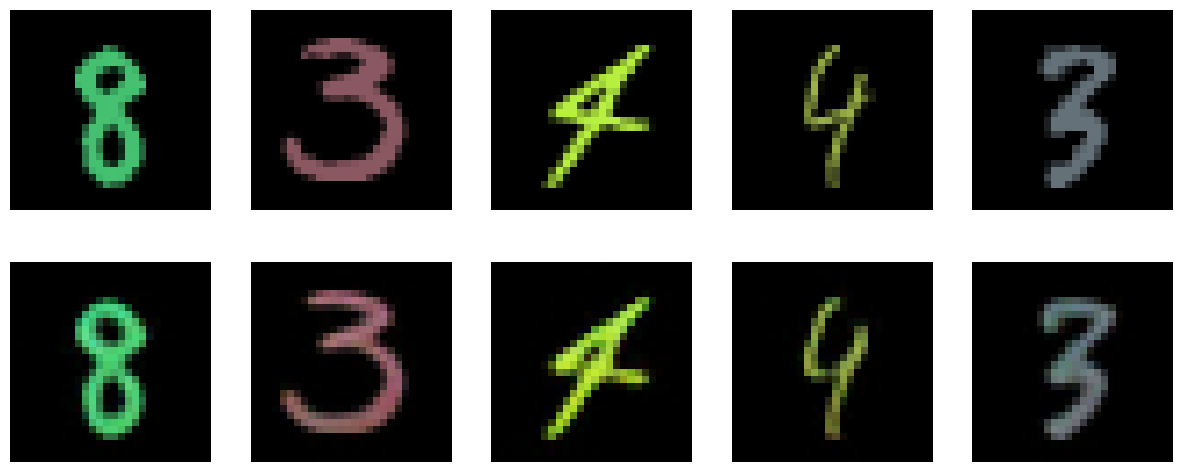


##################################################


VAE-MLP Epoch [5/15], Loss: 2.0050140903913414e-05


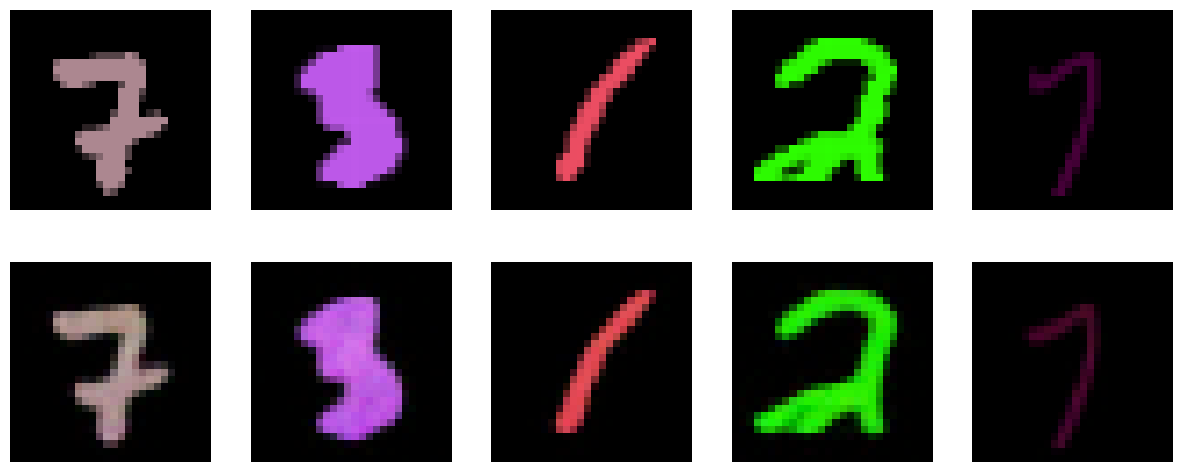


##################################################
VAE-MLP Epoch [6/15], Loss: 1.8922121959622017e-05


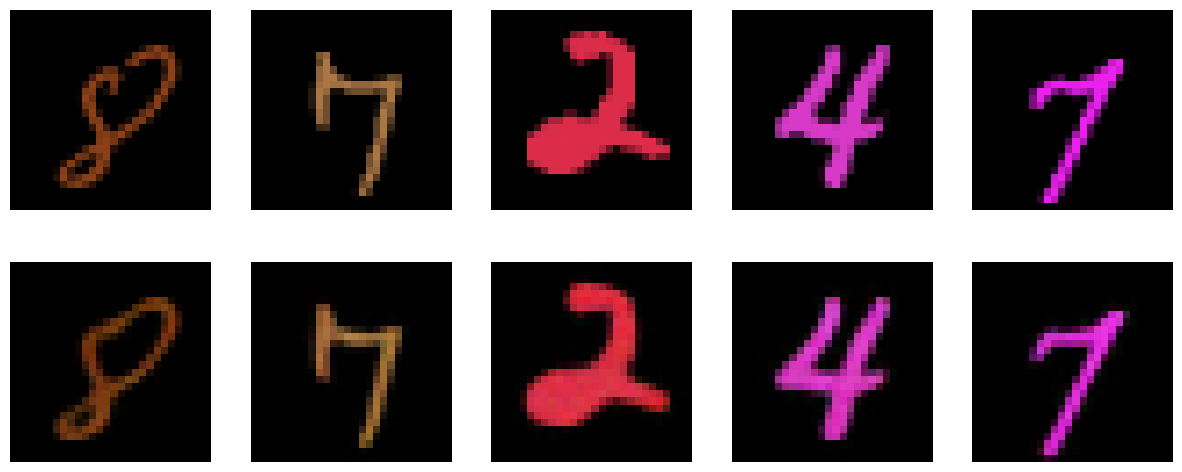


##################################################
VAE-MLP Epoch [7/15], Loss: 1.798590767236116e-05


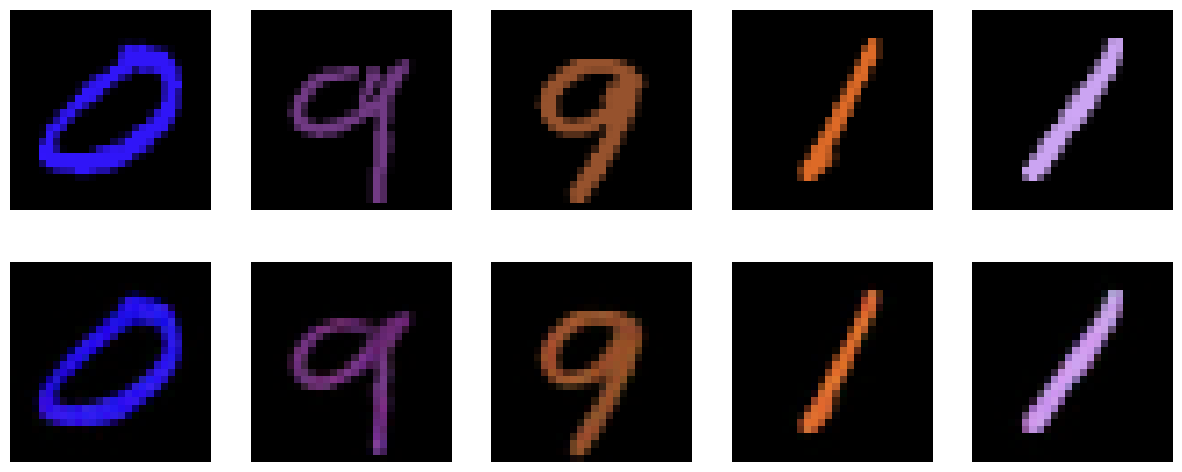


##################################################
VAE-MLP Epoch [8/15], Loss: 1.739576353187052e-05


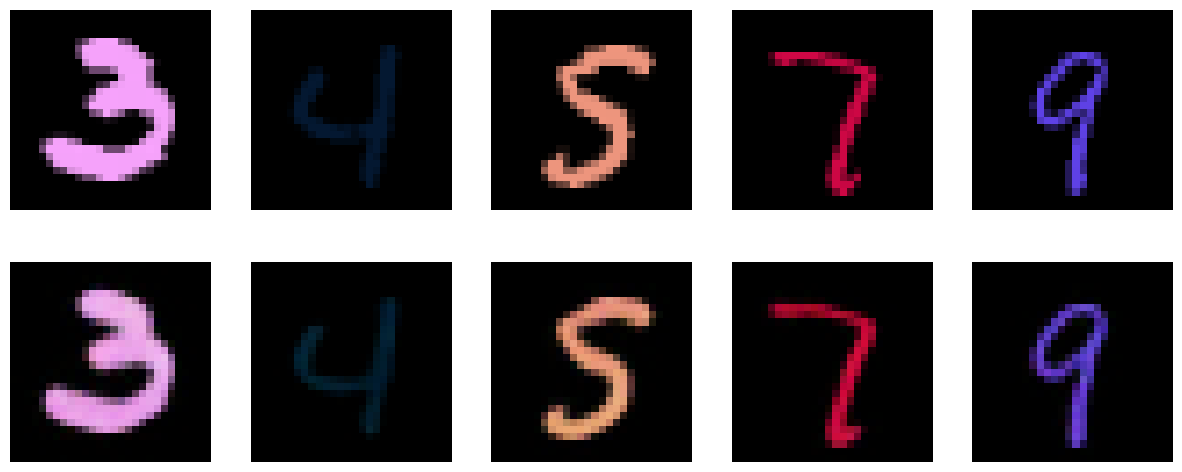


##################################################


VAE-MLP Epoch [9/15], Loss: 1.6025671006840034e-05


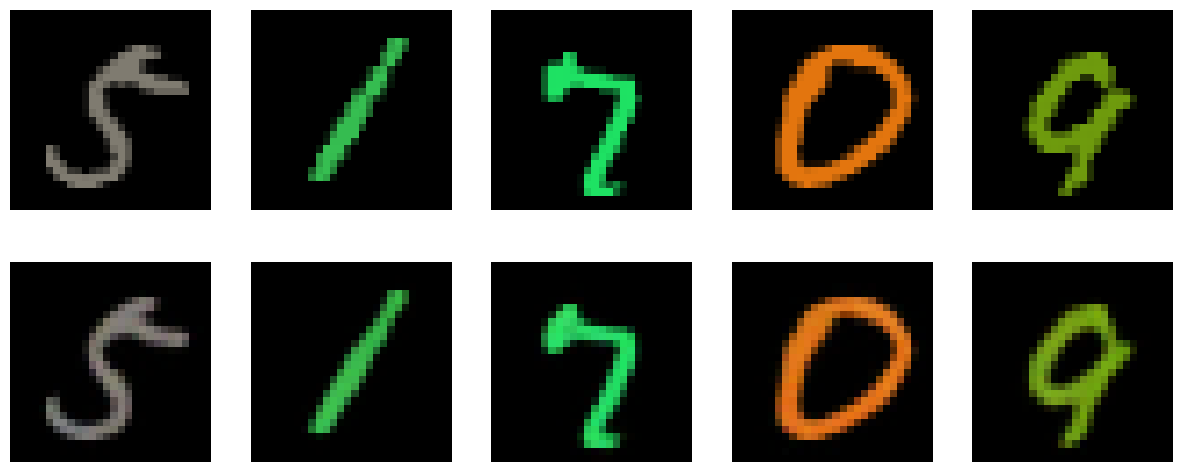


##################################################


VAE-MLP Epoch [10/15], Loss: 1.5636136468189458e-05


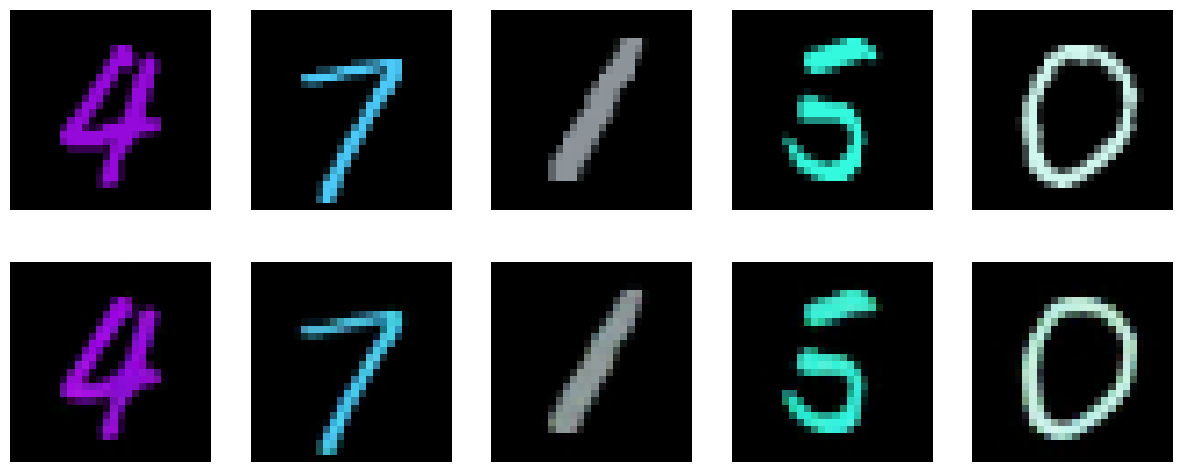


##################################################


VAE-MLP Epoch [11/15], Loss: 1.535753974749241e-05


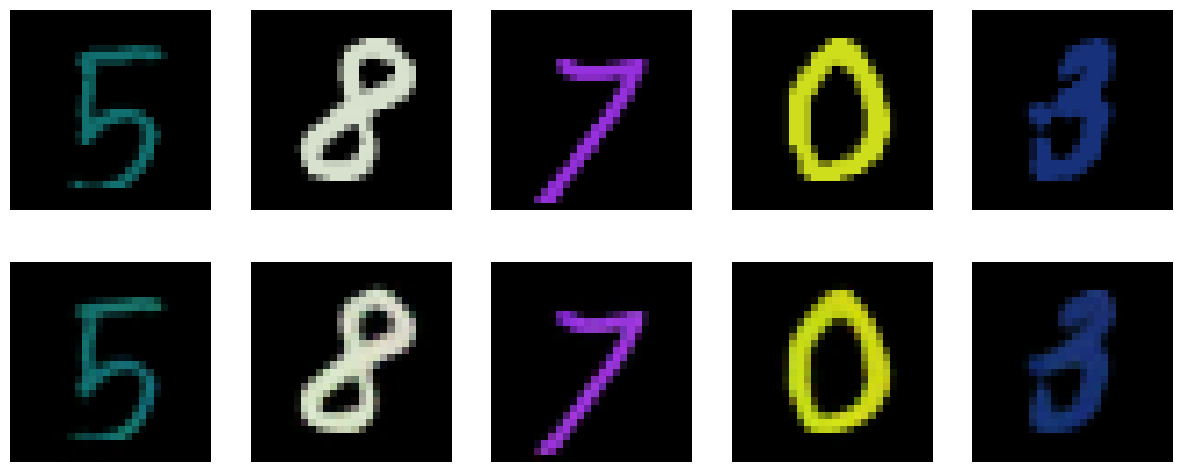


##################################################
VAE-MLP Epoch [12/15], Loss: 1.5068272731150501e-05


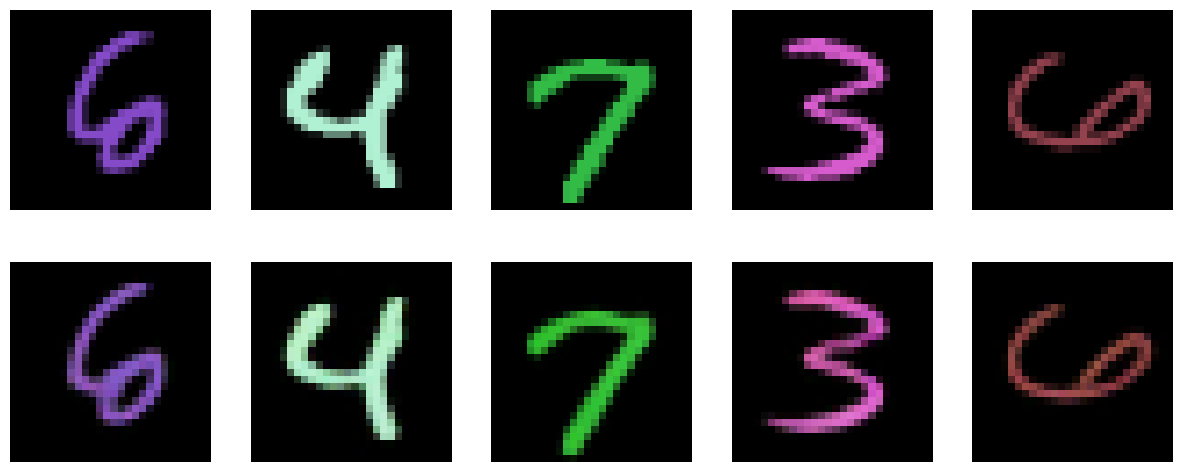


##################################################


VAE-MLP Epoch [13/15], Loss: 1.472698567667976e-05


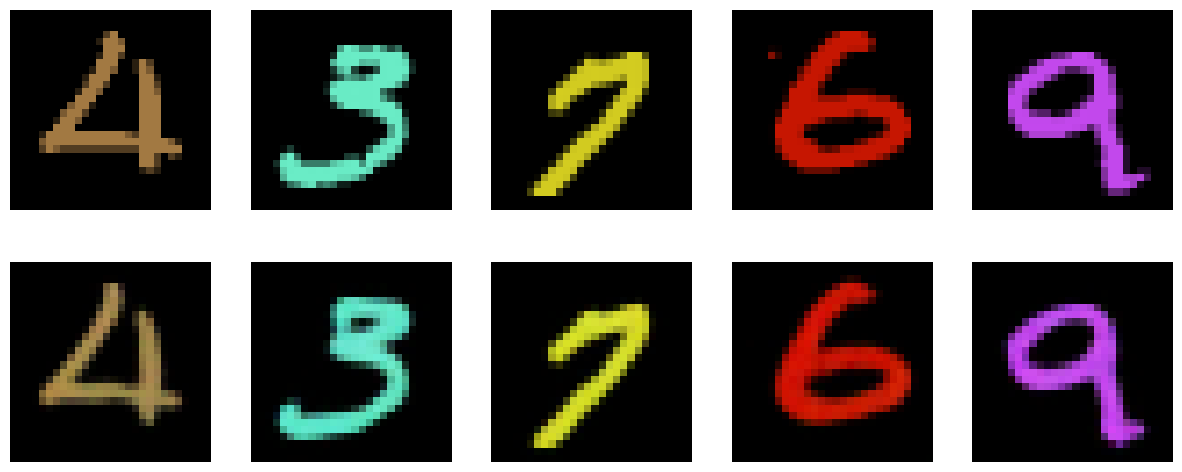


##################################################


VAE-MLP Epoch [14/15], Loss: 1.4473913321853615e-05


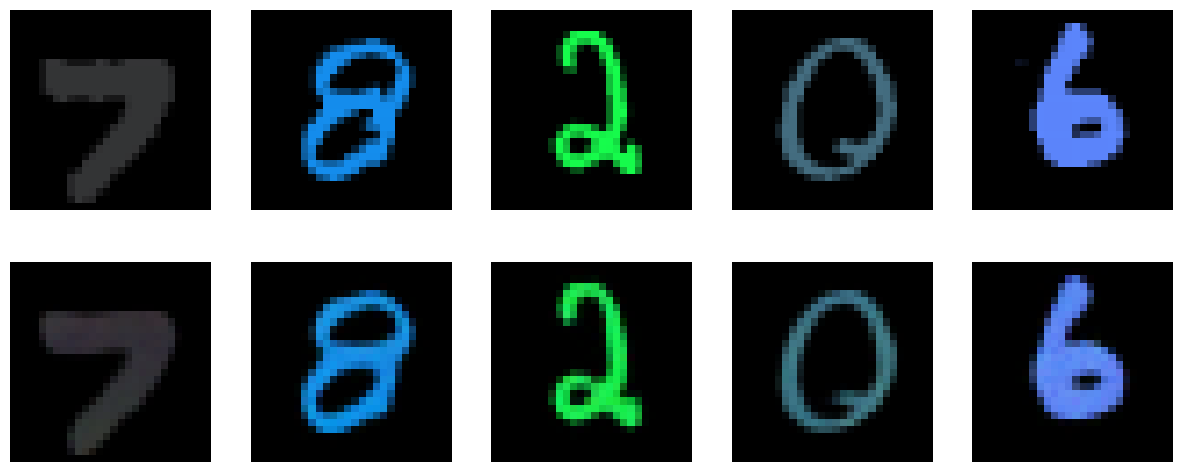


##################################################


VAE-MLP Epoch [15/15], Loss: 1.4411399272891382e-05


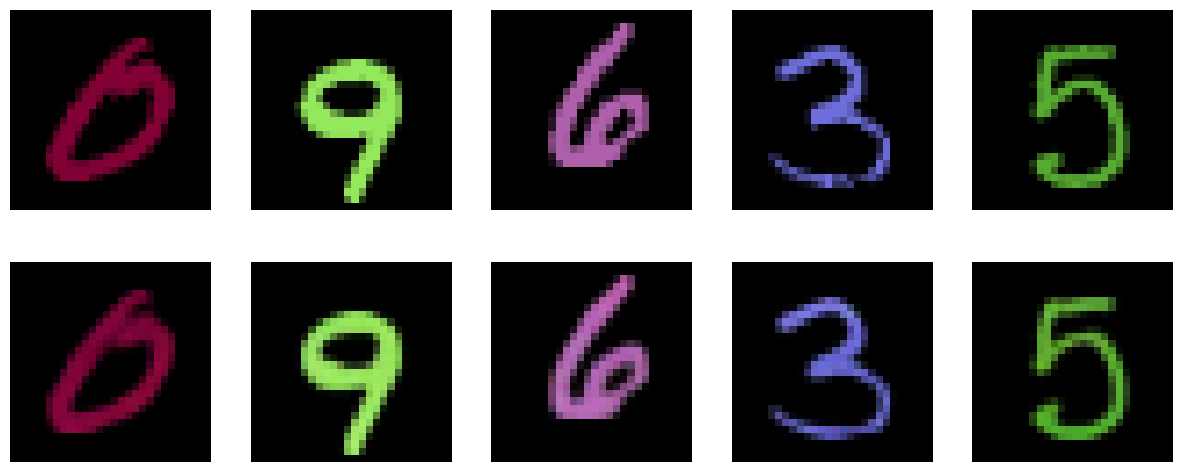

3.186892158830435e-05


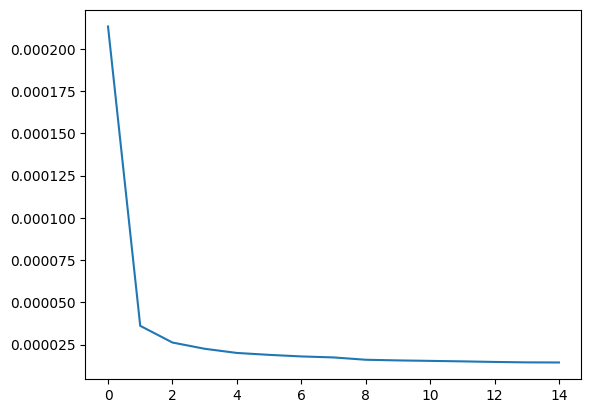

In [ ]:
vq_vae_5_embeddings = VQVAE_modified(in_channels=3, embedding_dim=2, num_embeddings=50)
train_three(vq_vae_5_embeddings, train_loader_colorful)


#Increase the number of dimention


##################################################


VAE-MLP Epoch [1/15], Loss: 0.0005470768105083455


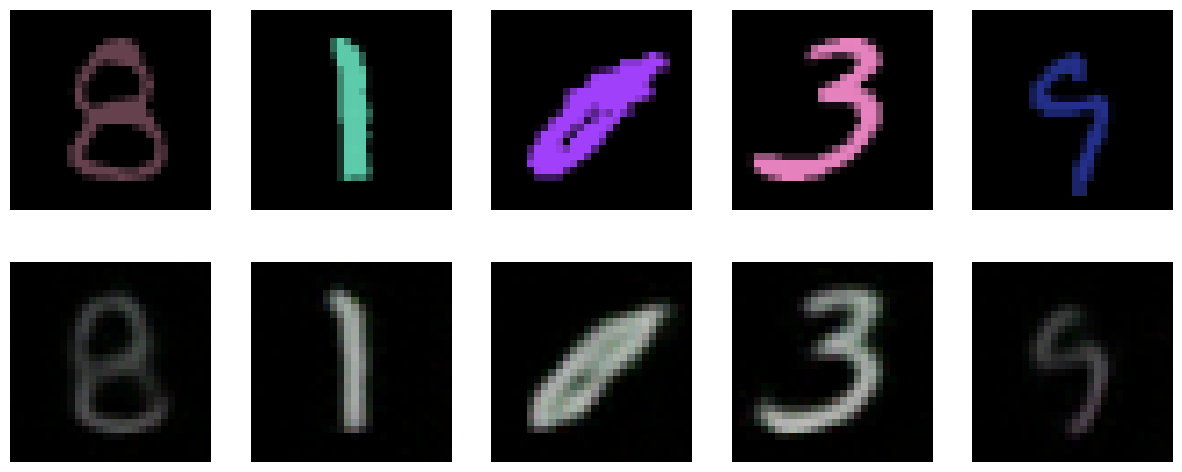


##################################################
VAE-MLP Epoch [2/15], Loss: 0.00029599464003307125


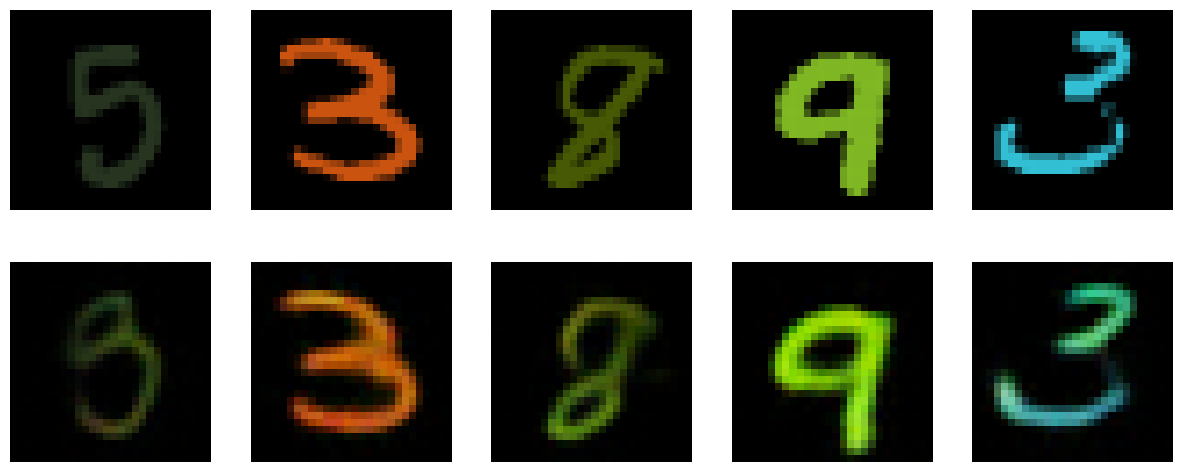


##################################################


VAE-MLP Epoch [3/15], Loss: 0.0002597698799489687


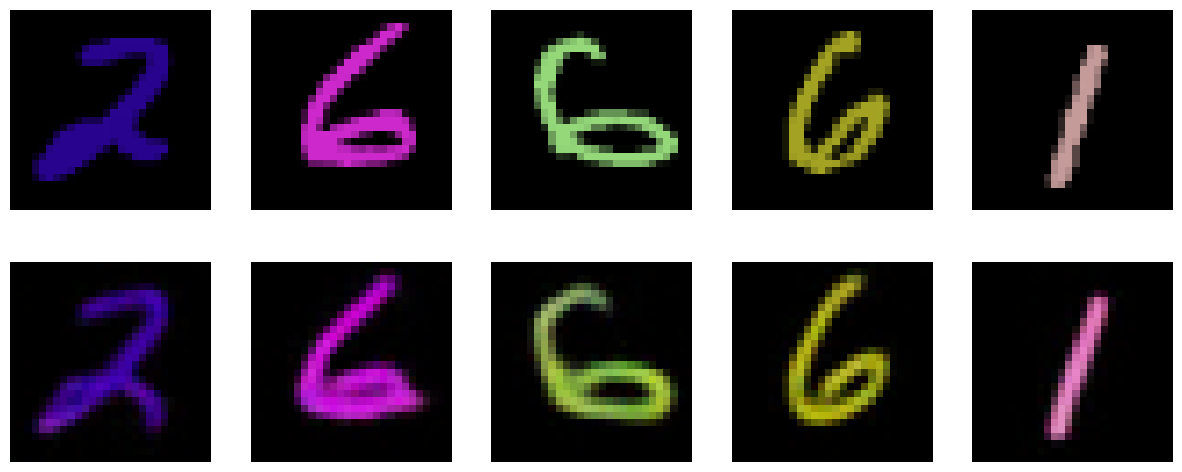


##################################################


VAE-MLP Epoch [4/15], Loss: 0.00024279691729073722


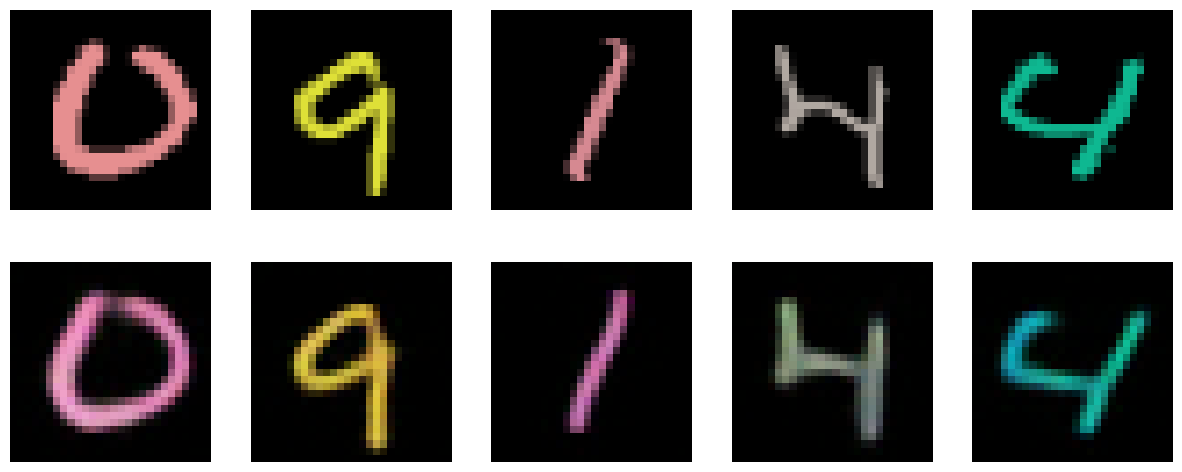


##################################################


VAE-MLP Epoch [5/15], Loss: 0.00023310094671323895


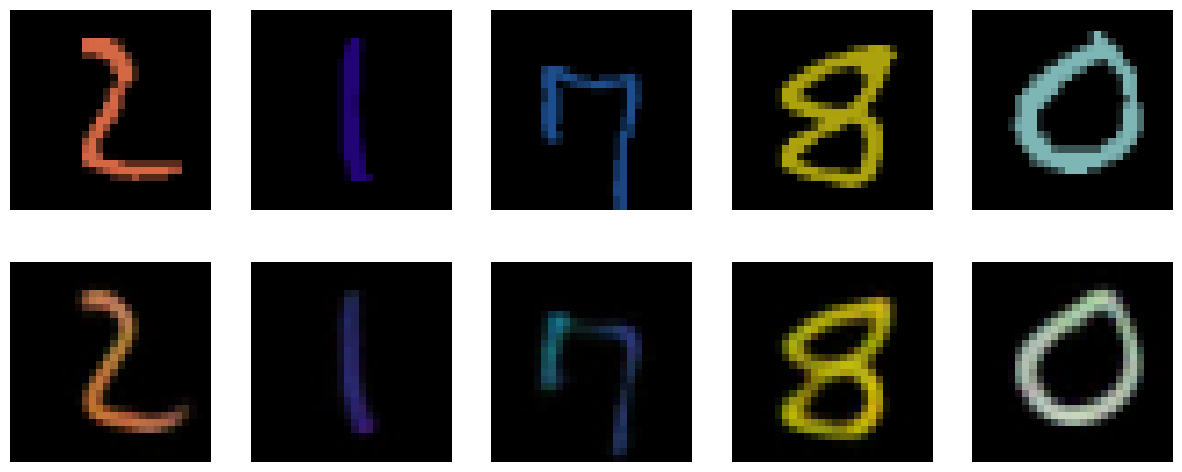


##################################################


VAE-MLP Epoch [6/15], Loss: 0.0002283172398650398


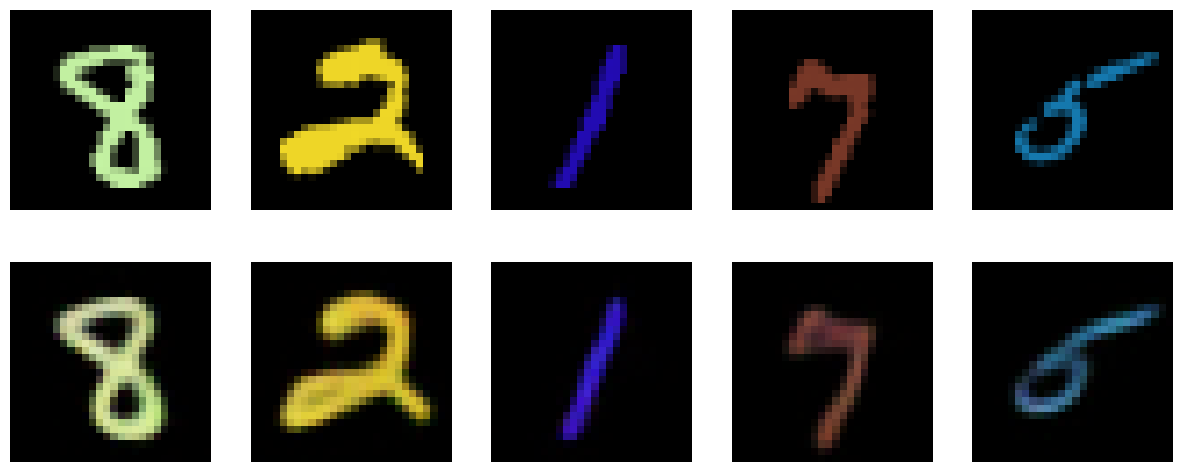


##################################################


VAE-MLP Epoch [7/15], Loss: 0.0002235496555455029


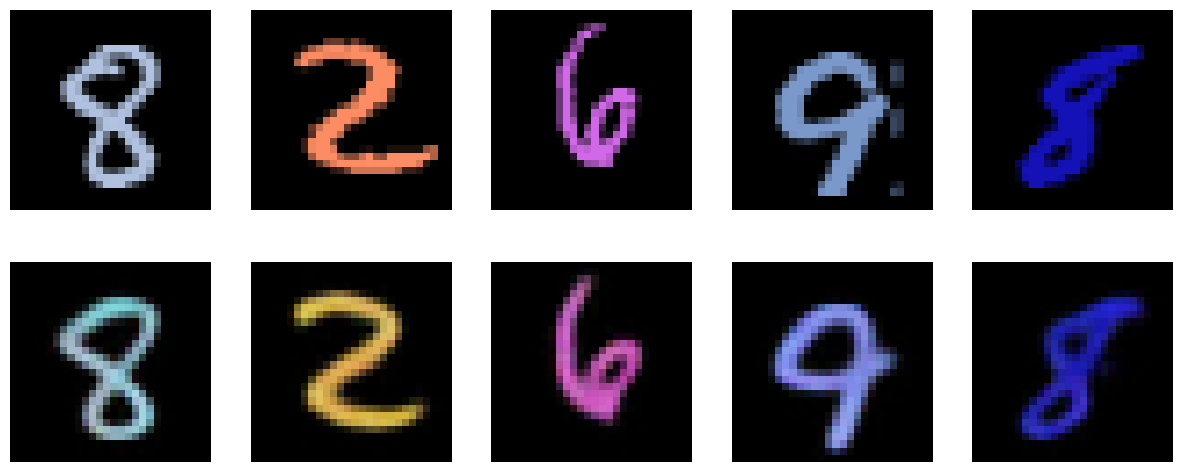


##################################################
VAE-MLP Epoch [8/15], Loss: 0.00022336596607541045


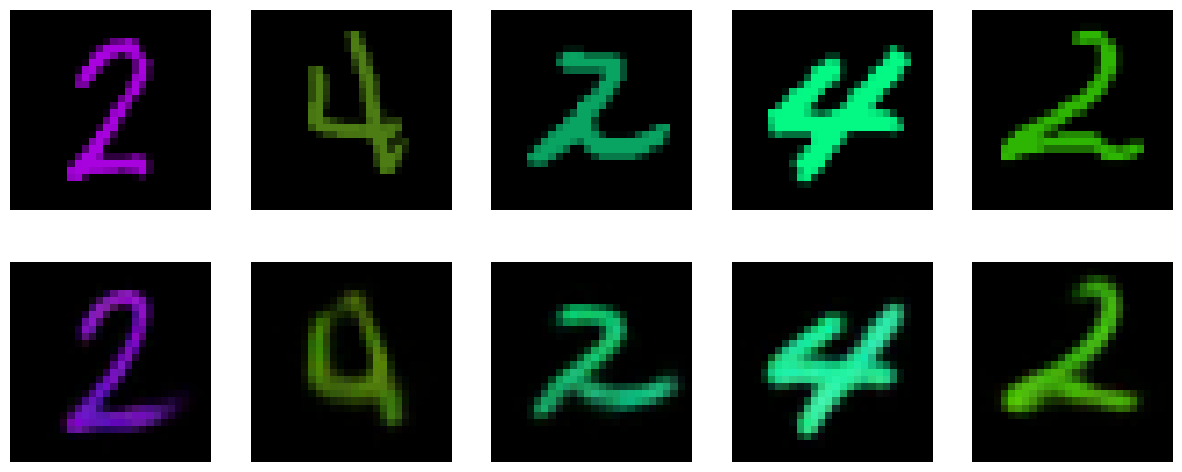


##################################################


VAE-MLP Epoch [9/15], Loss: 0.00021912789312191307


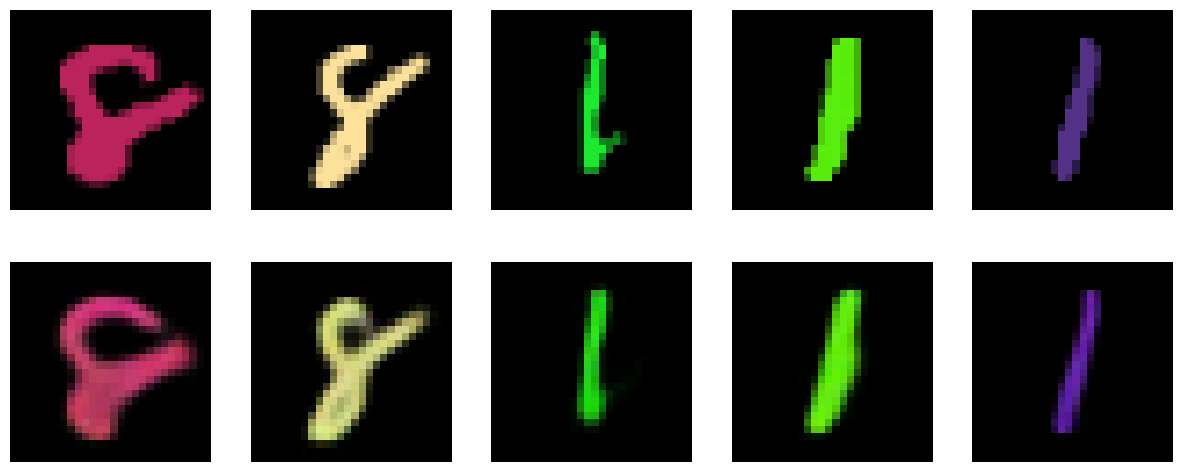


##################################################


VAE-MLP Epoch [10/15], Loss: 0.00021734596920820574


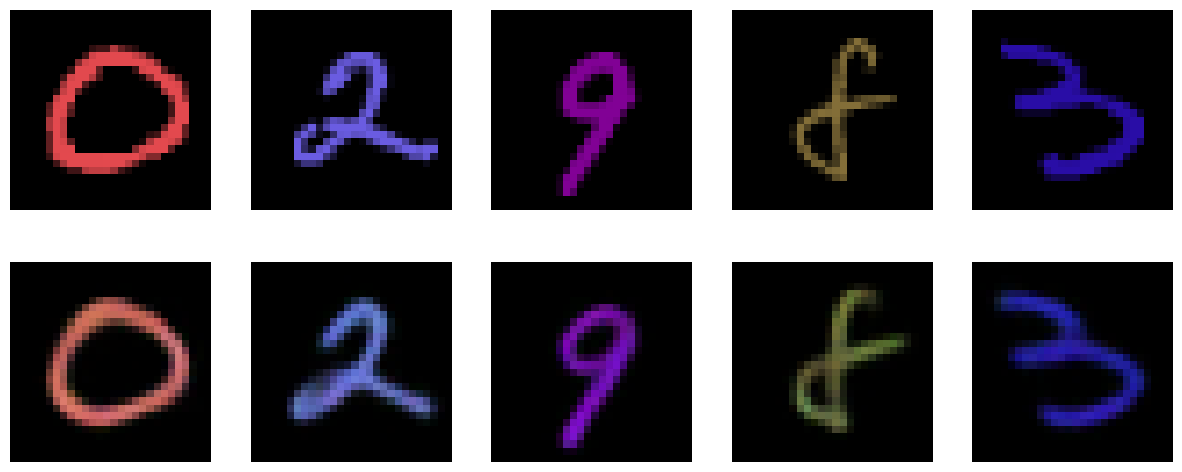


##################################################


VAE-MLP Epoch [11/15], Loss: 0.00021659661134084066


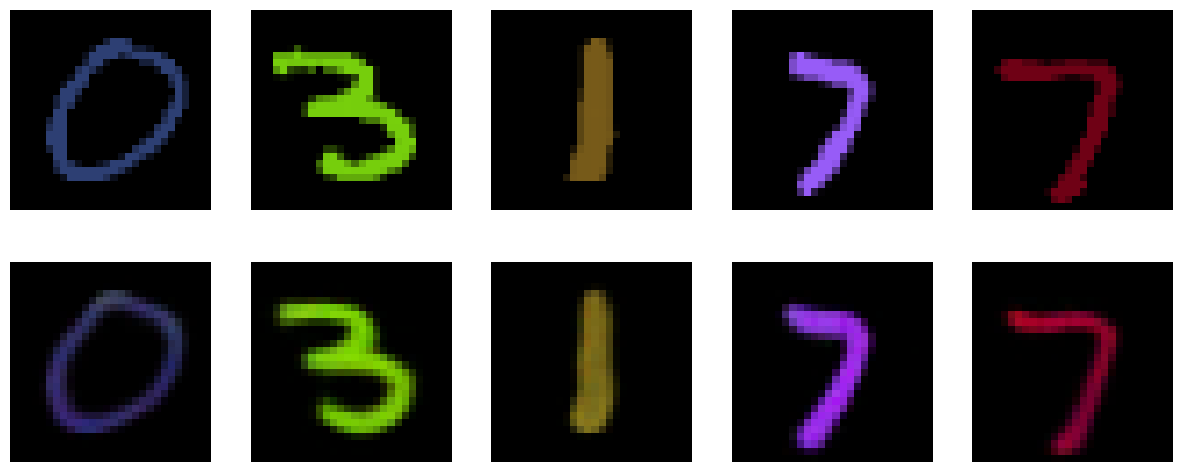


##################################################


VAE-MLP Epoch [12/15], Loss: 0.00021385209055927893


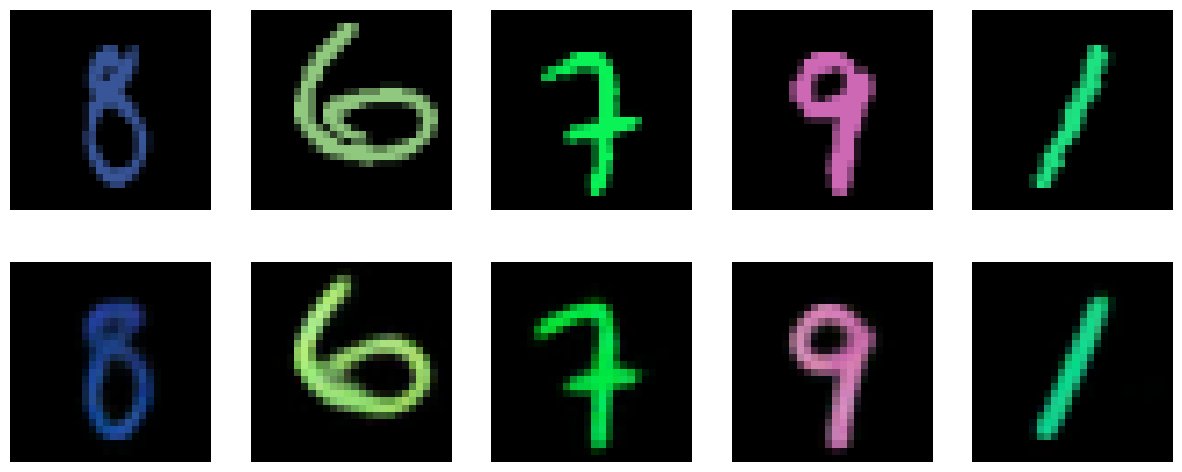


##################################################
VAE-MLP Epoch [13/15], Loss: 0.00021214637599575024


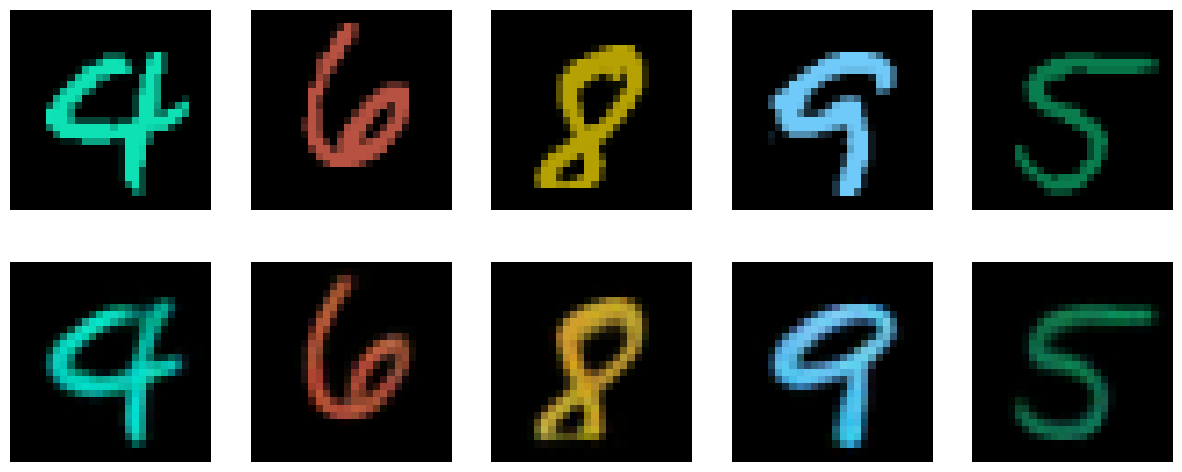


##################################################


VAE-MLP Epoch [14/15], Loss: 0.0002115328236327817


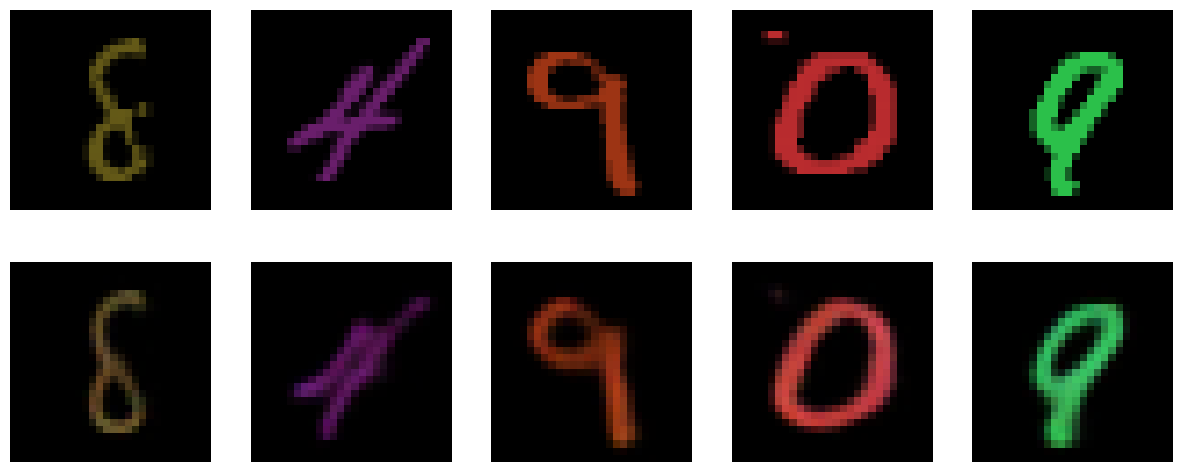


##################################################


VAE-MLP Epoch [15/15], Loss: 0.0002111536522085468


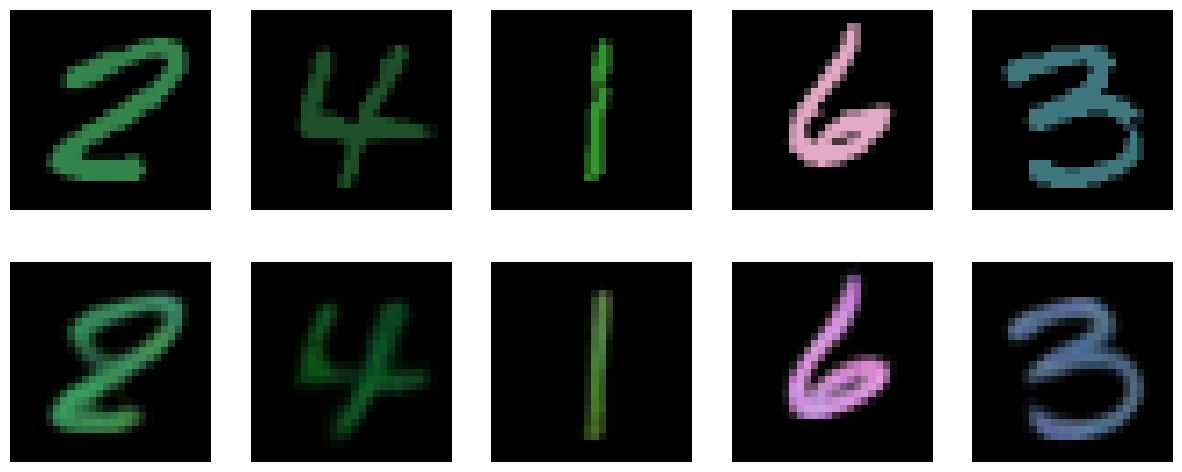

0.00025038183146984213


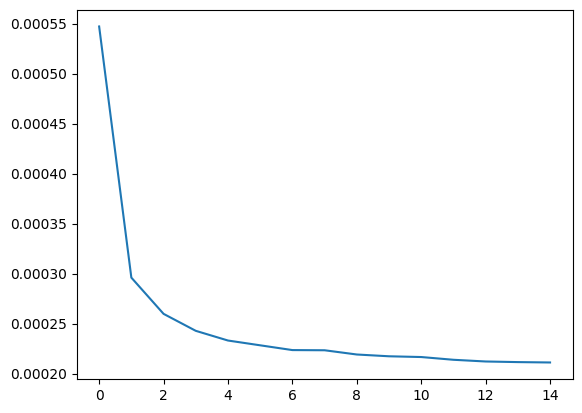

In [ ]:
vq_vae_higher_dimensions = VQVAE_modified(in_channels=3, embedding_dim=20, num_embeddings=3)
train_three(vq_vae_higher_dimensions, train_loader_colorful)



##################################################


VAE-MLP Epoch [1/15], Loss: 0.0012235861891880633


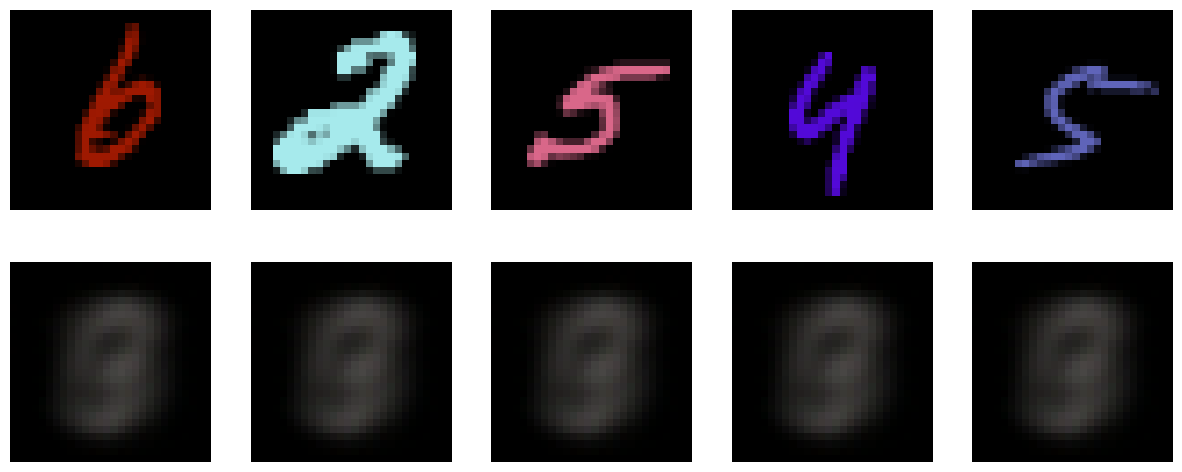


##################################################
VAE-MLP Epoch [2/15], Loss: 0.0009007011784861486


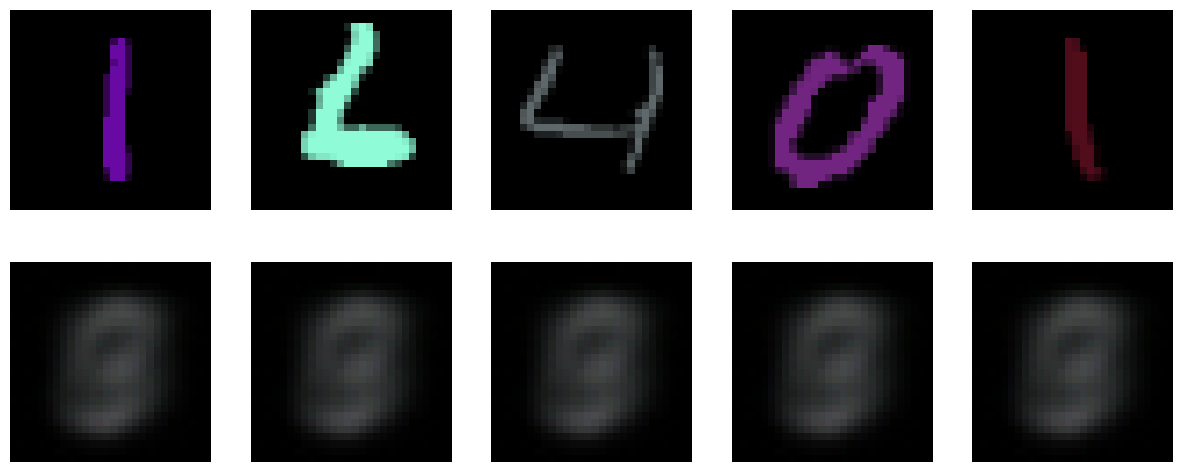


##################################################


VAE-MLP Epoch [3/15], Loss: 0.0007233598677441478


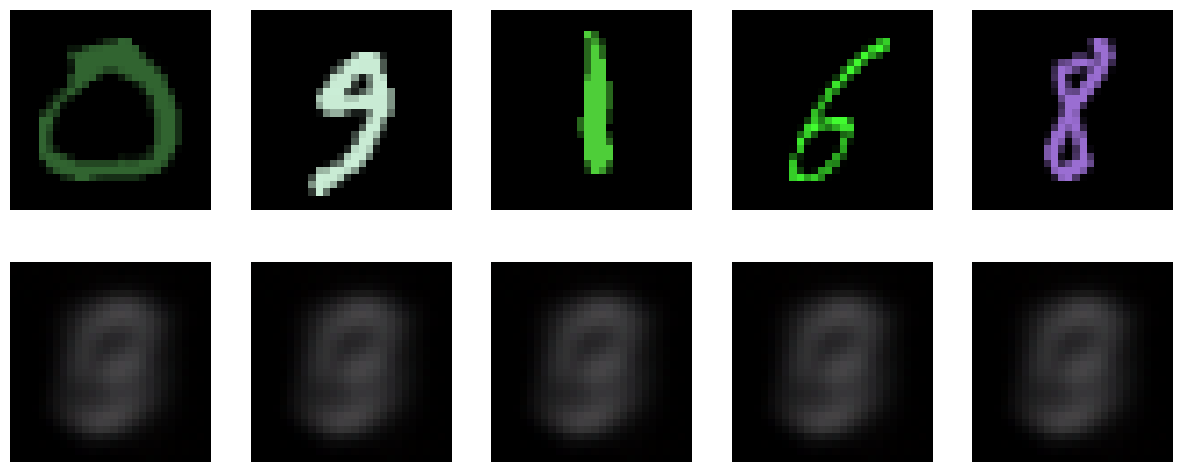


##################################################


VAE-MLP Epoch [4/15], Loss: 0.0005445773140527308


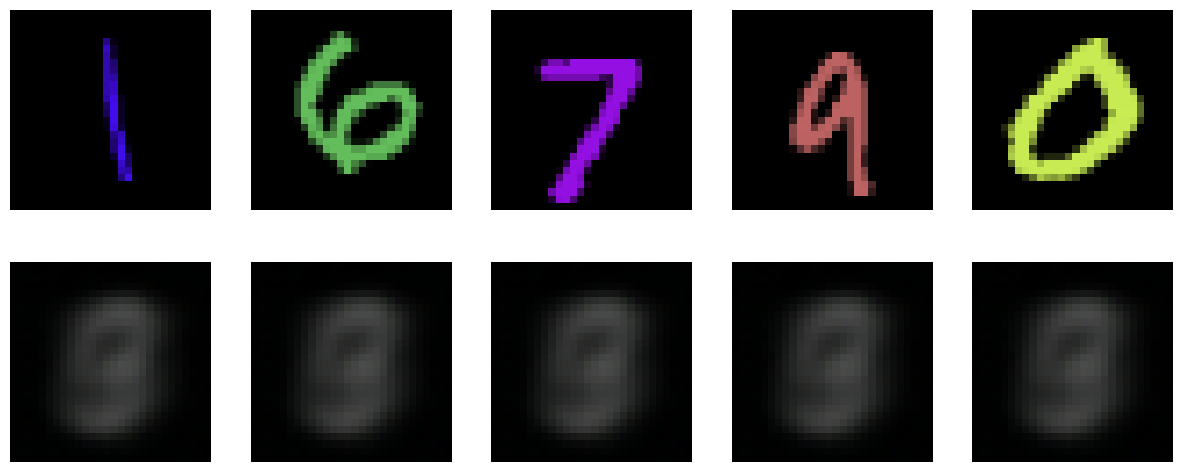


##################################################


VAE-MLP Epoch [5/15], Loss: 0.00047245979079355797


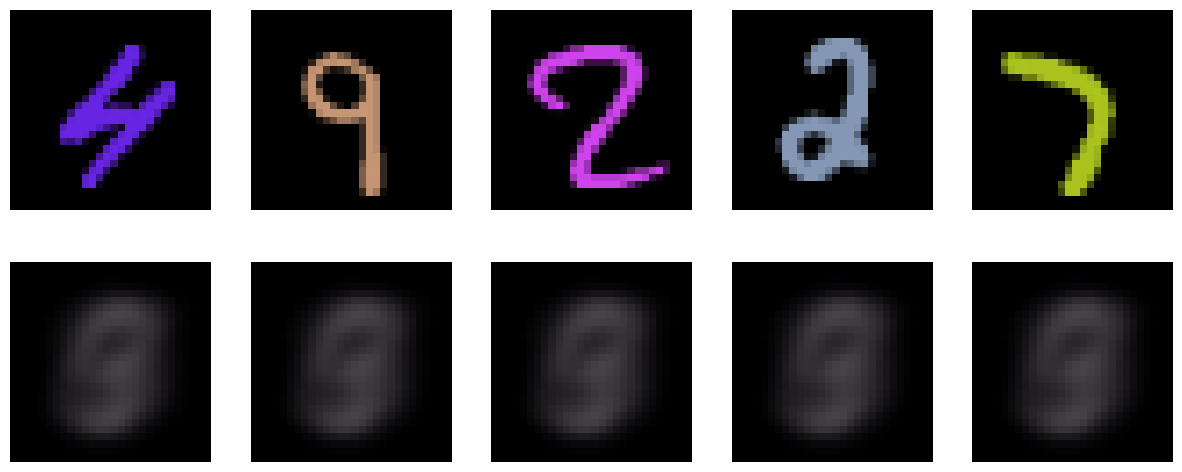


##################################################


VAE-MLP Epoch [6/15], Loss: 0.00045710799225295585


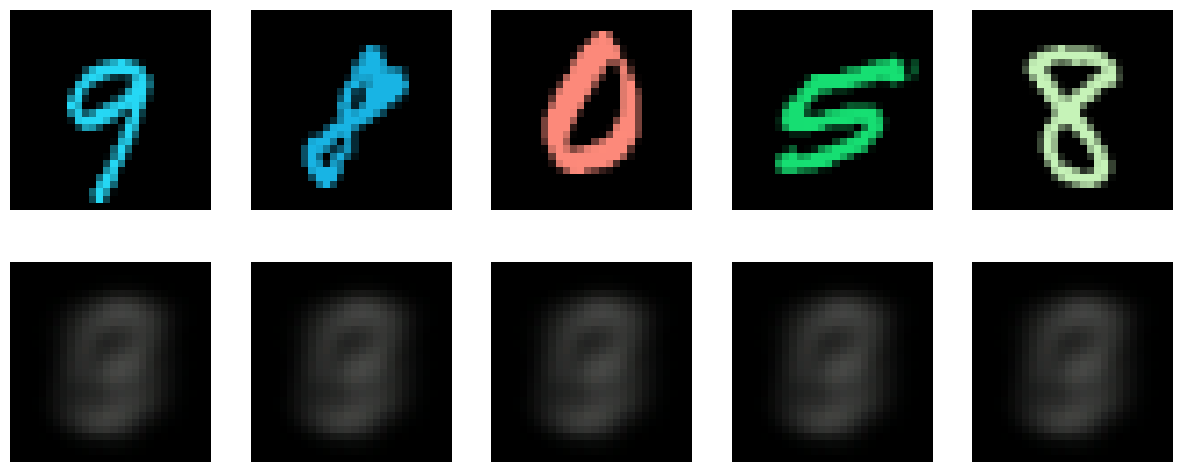


##################################################


VAE-MLP Epoch [7/15], Loss: 0.0004520209489700695


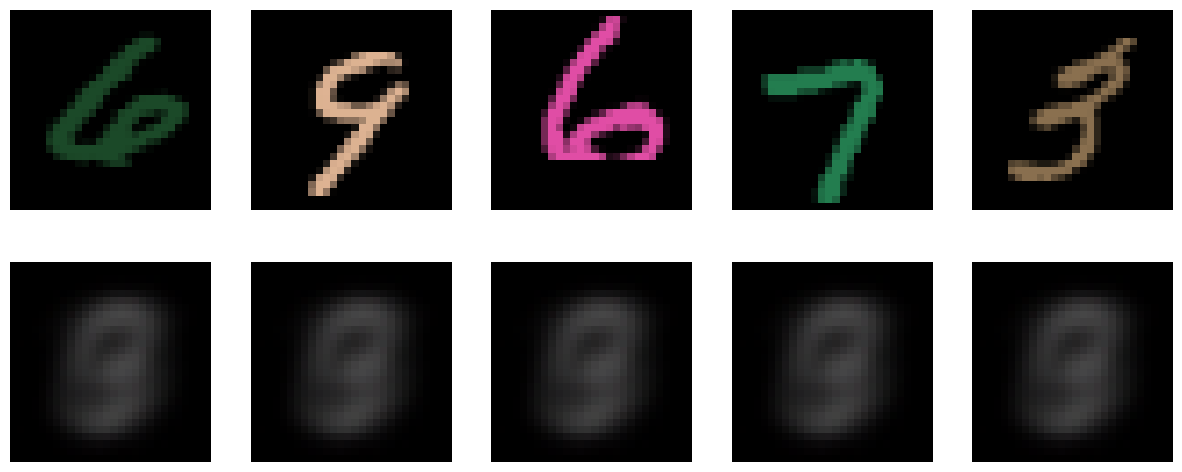


##################################################
VAE-MLP Epoch [8/15], Loss: 0.00044761387336378296


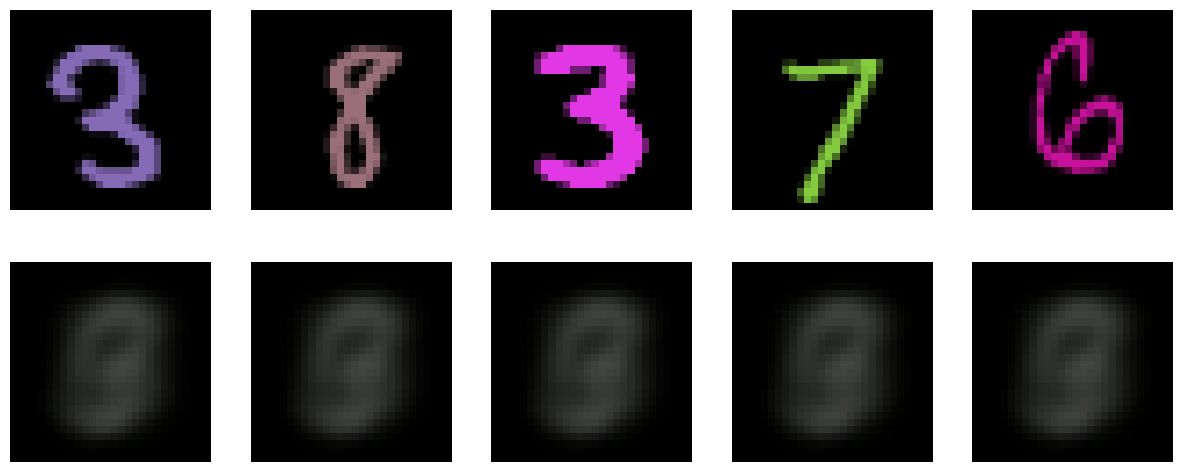


##################################################


VAE-MLP Epoch [9/15], Loss: 0.00044768072630589205


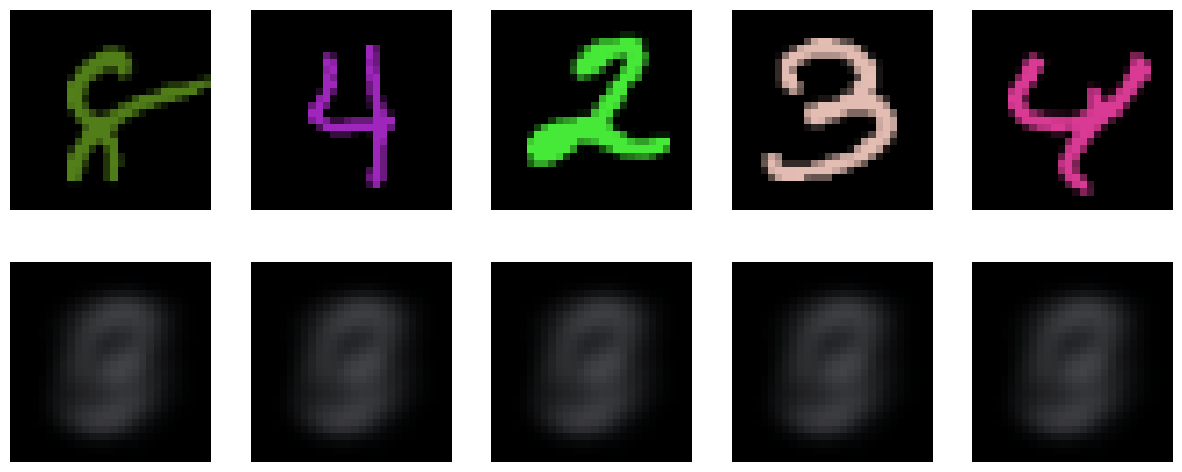


##################################################


VAE-MLP Epoch [10/15], Loss: 0.000440345191086332


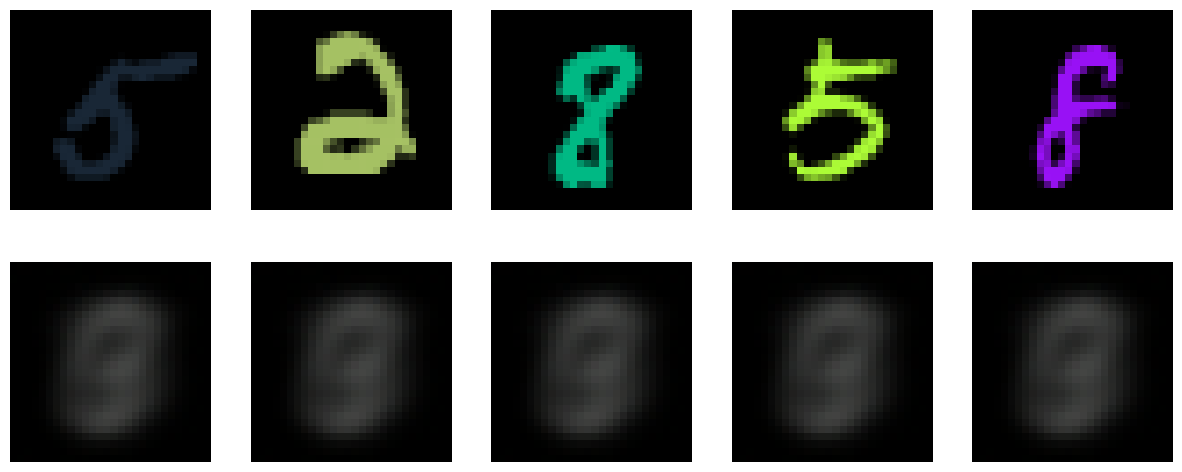


##################################################


VAE-MLP Epoch [11/15], Loss: 0.0004284591614889602


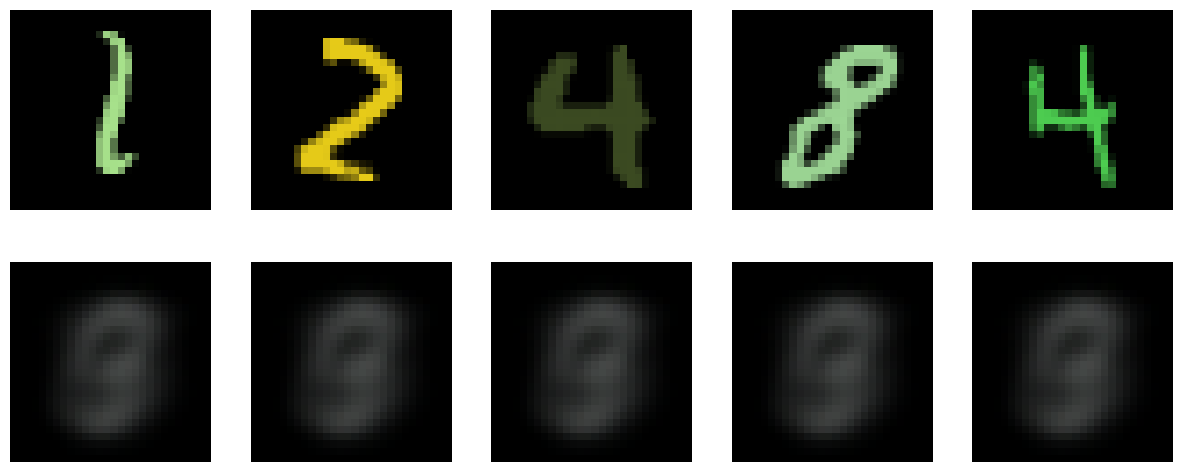


##################################################


VAE-MLP Epoch [12/15], Loss: 0.0004286790526472032


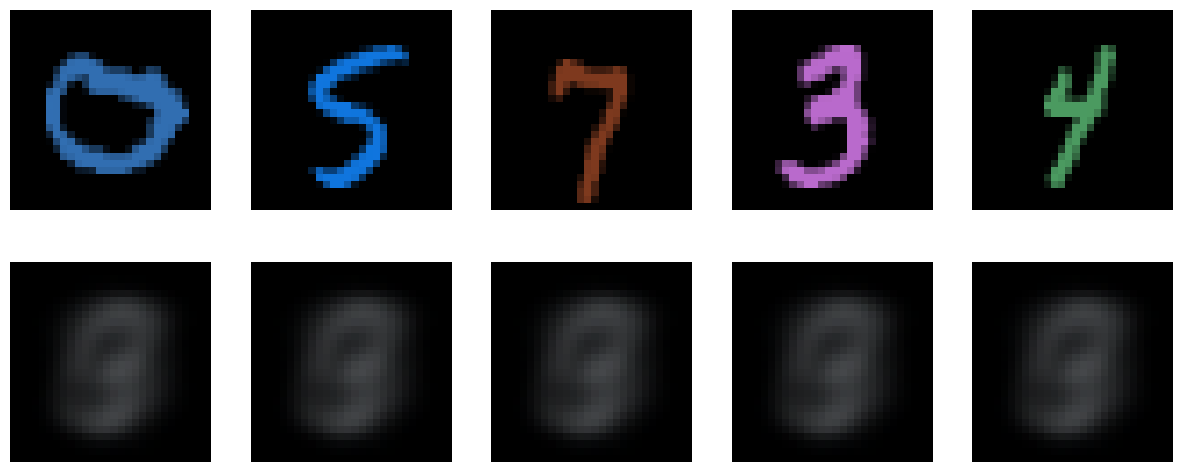


##################################################
VAE-MLP Epoch [13/15], Loss: 0.00042434915667399764


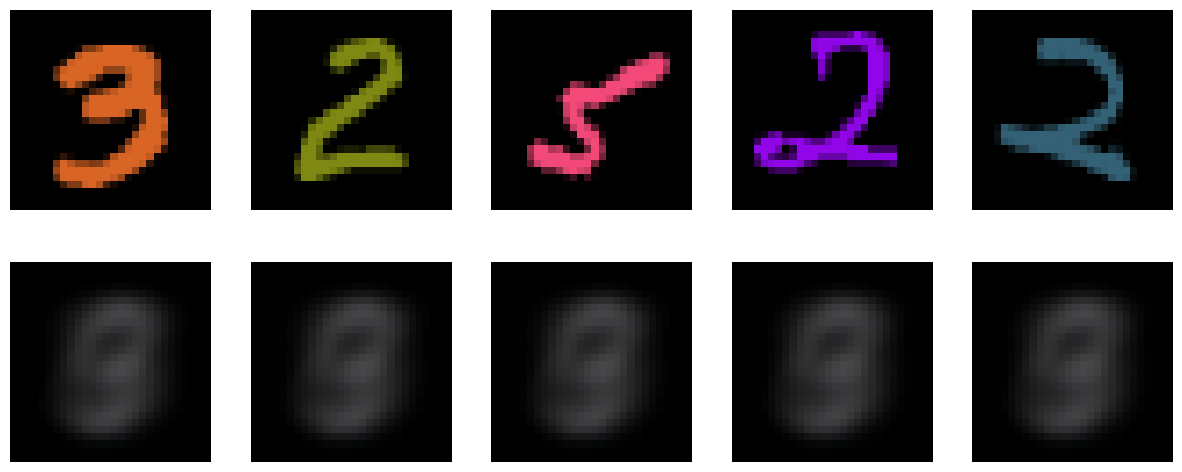


##################################################


VAE-MLP Epoch [14/15], Loss: 0.0004231510710592071


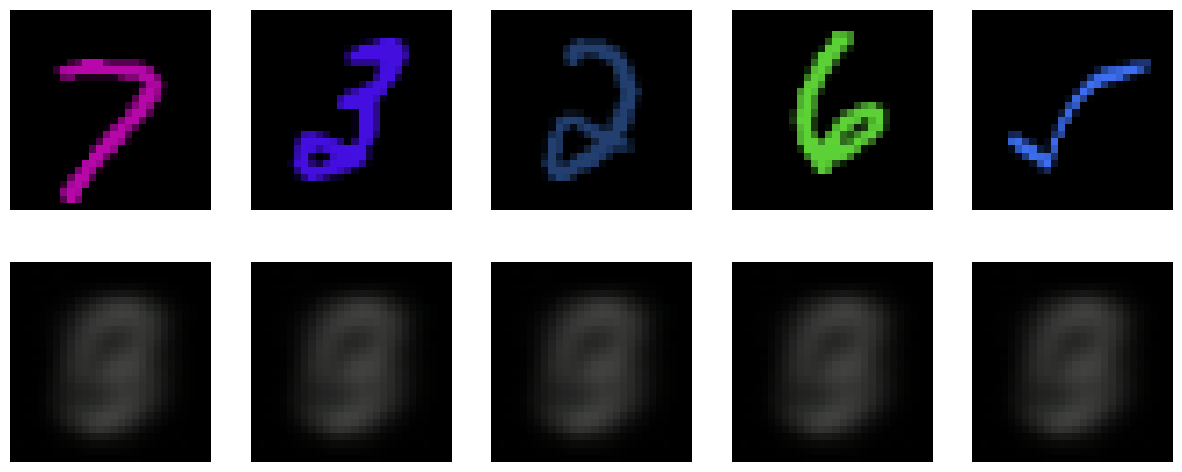


##################################################


VAE-MLP Epoch [15/15], Loss: 0.0004203358745202422


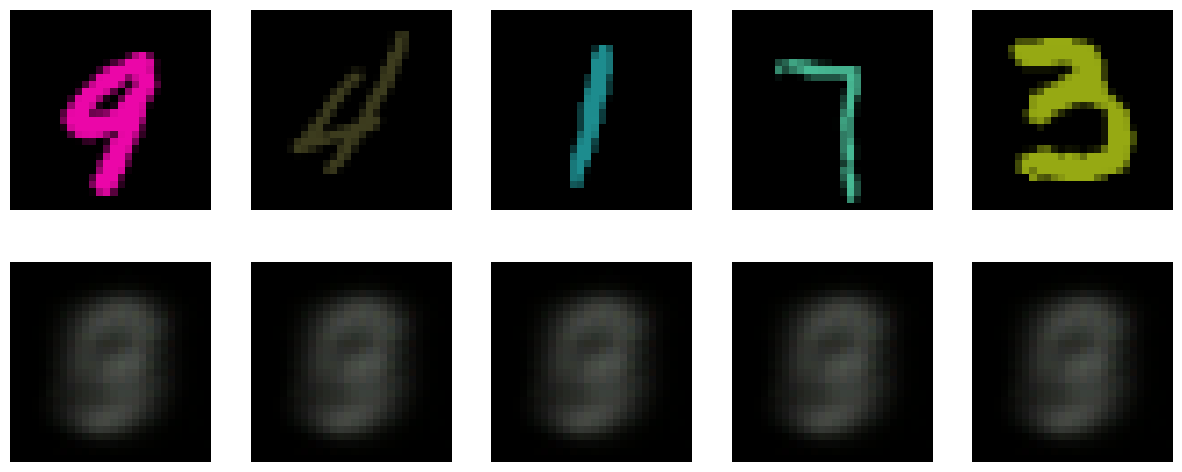

0.0005489618259088859


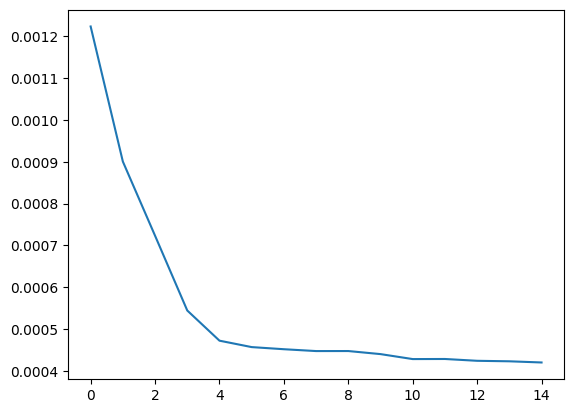

In [ ]:
vq_vae_higher_dimensions = VQVAE_modified(in_channels=3, embedding_dim=40, num_embeddings=3)
train_three(vq_vae_higher_dimensions, train_loader_colorful)



##################################################


VAE-MLP Epoch [1/15], Loss: 0.0006580173486998925


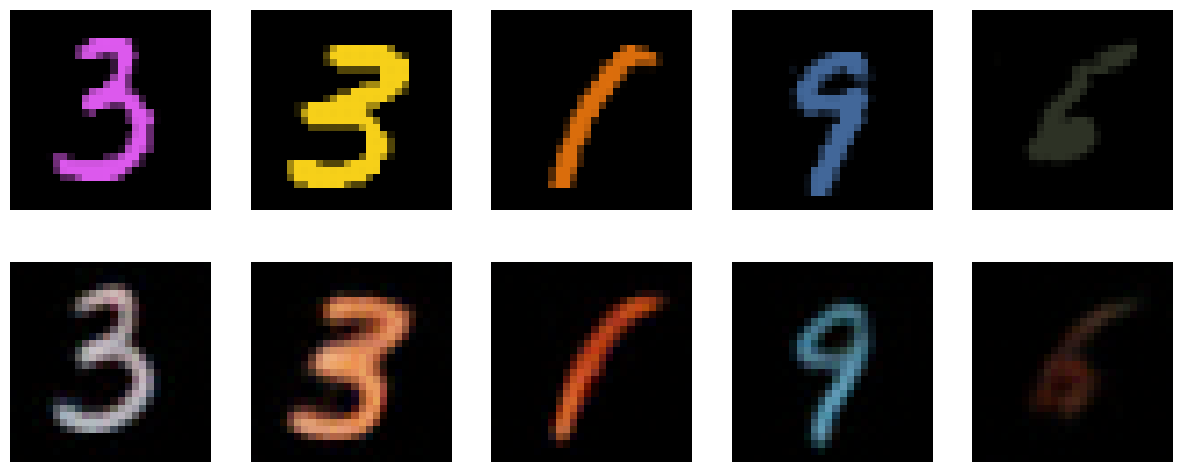


##################################################


VAE-MLP Epoch [2/15], Loss: 0.0003067927017187079


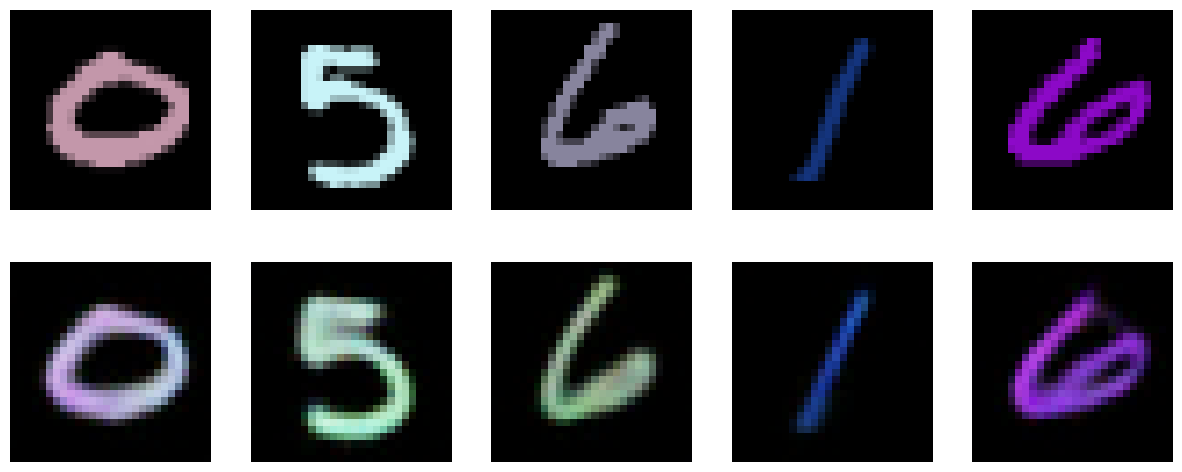


##################################################
VAE-MLP Epoch [3/15], Loss: 0.0002677414276637137


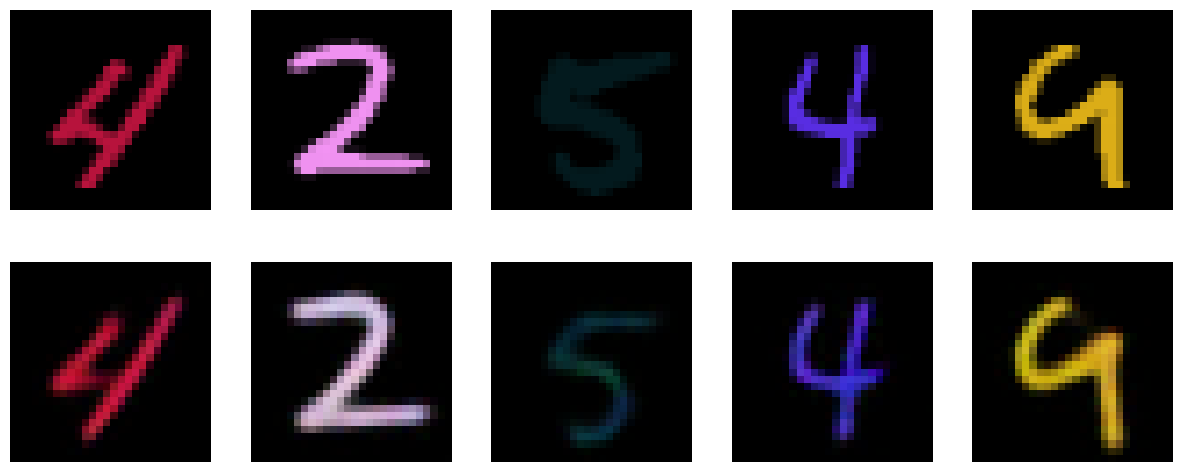


##################################################


VAE-MLP Epoch [4/15], Loss: 0.00025731970560736956


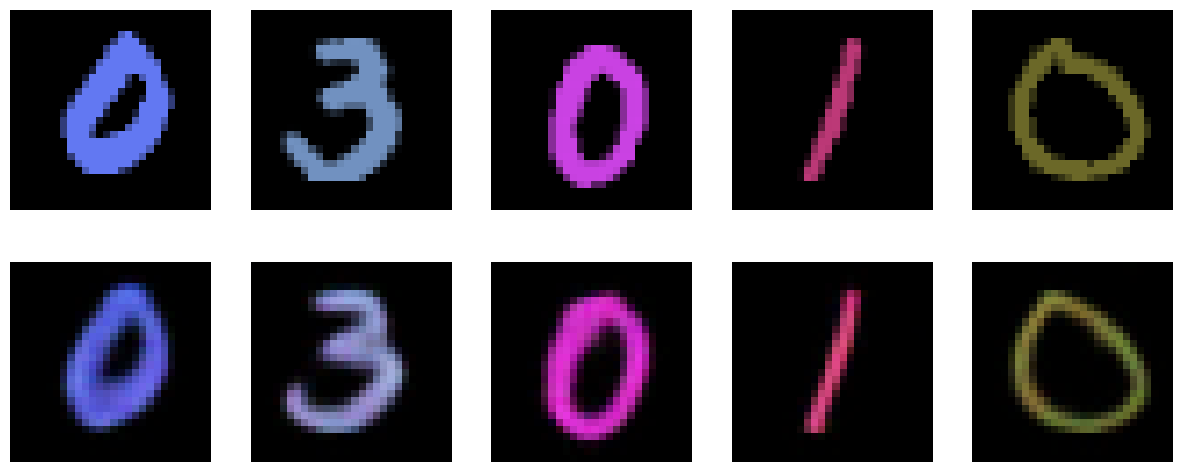


##################################################


VAE-MLP Epoch [5/15], Loss: 0.0002573108590363214


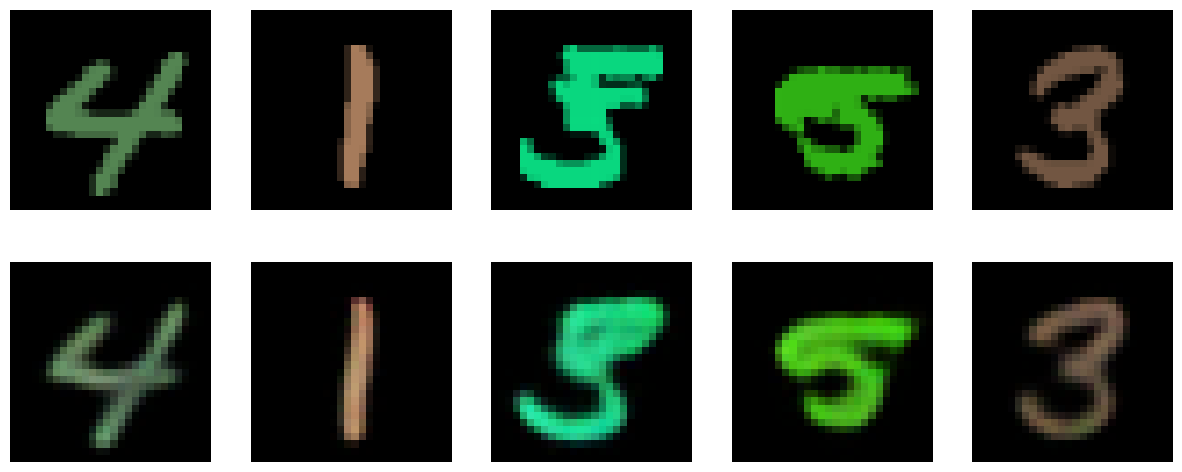


##################################################


VAE-MLP Epoch [6/15], Loss: 0.0002569939851295203


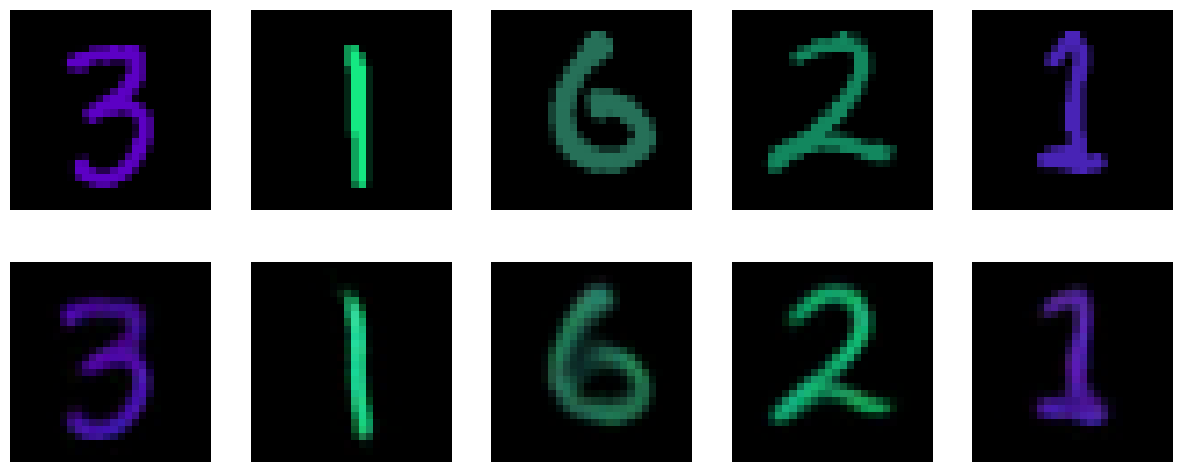


##################################################


VAE-MLP Epoch [7/15], Loss: 0.000260837379982695


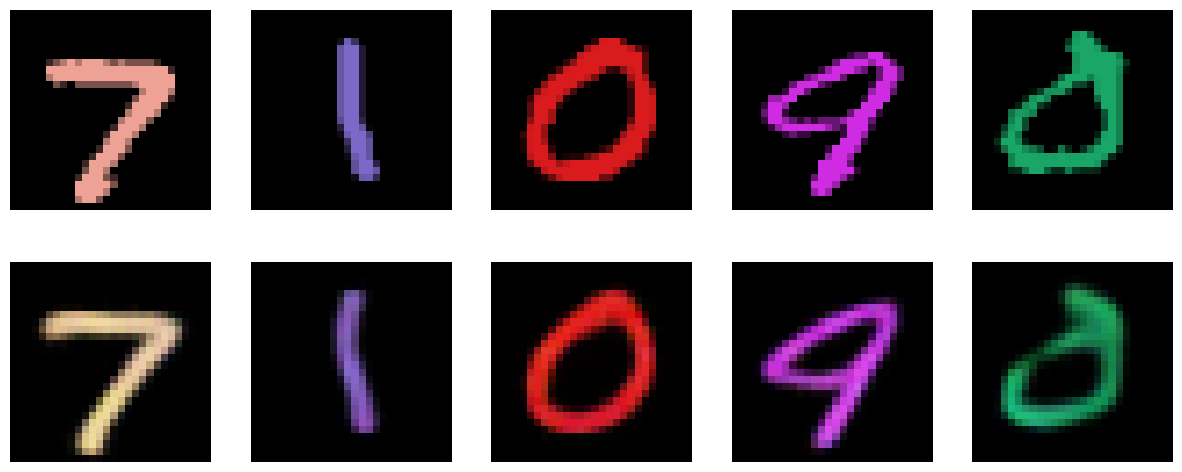


##################################################
VAE-MLP Epoch [8/15], Loss: 0.00026212836750783025


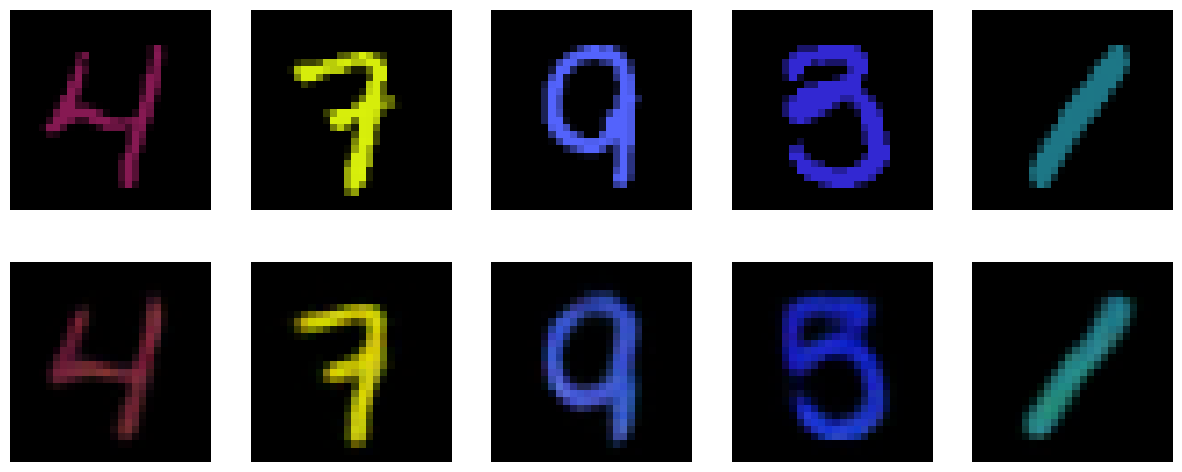


##################################################


VAE-MLP Epoch [9/15], Loss: 0.0002629908202992131


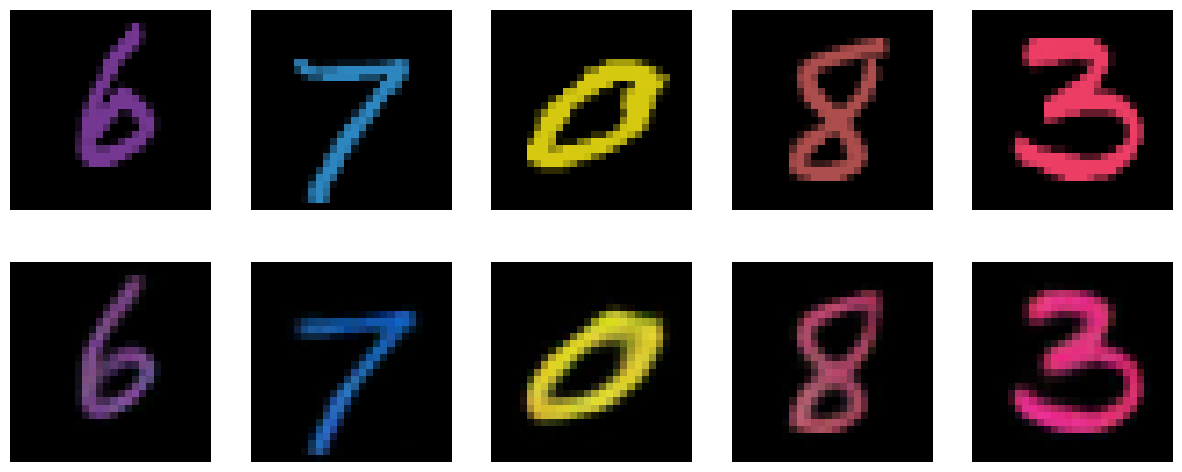


##################################################


VAE-MLP Epoch [10/15], Loss: 0.00026478831842541696


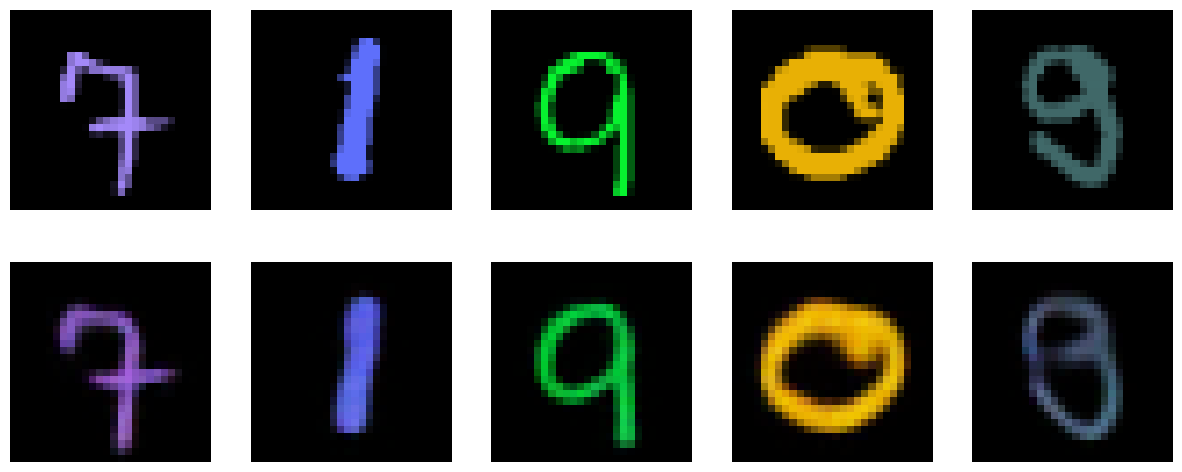


##################################################


VAE-MLP Epoch [11/15], Loss: 0.0002652666108837972


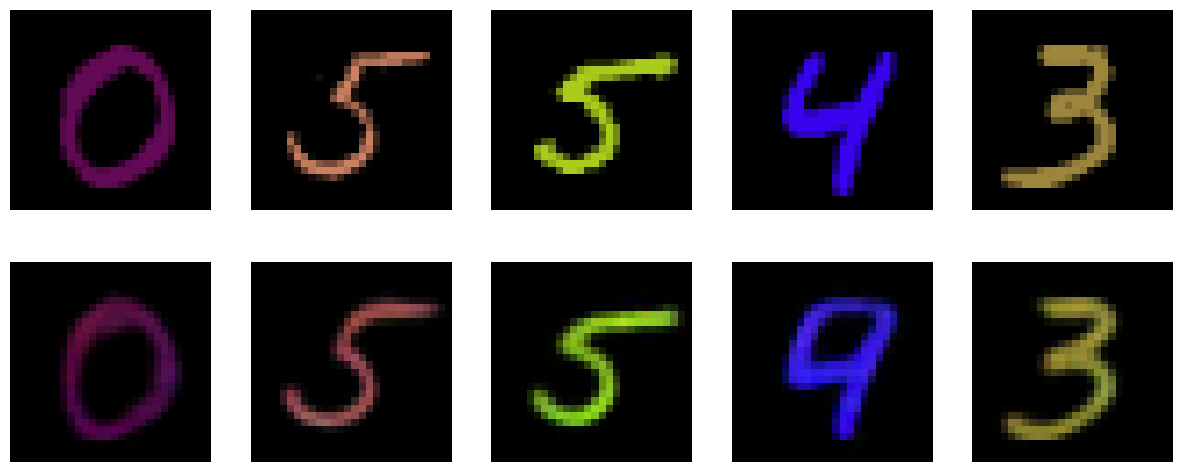


##################################################


VAE-MLP Epoch [12/15], Loss: 0.0002564358838523428


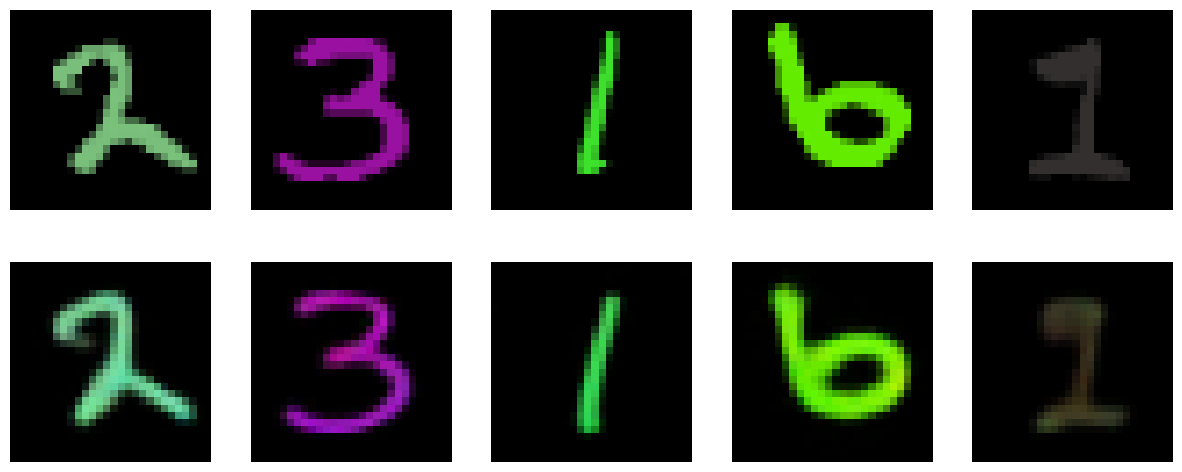


##################################################
VAE-MLP Epoch [13/15], Loss: 0.0002564592082674305


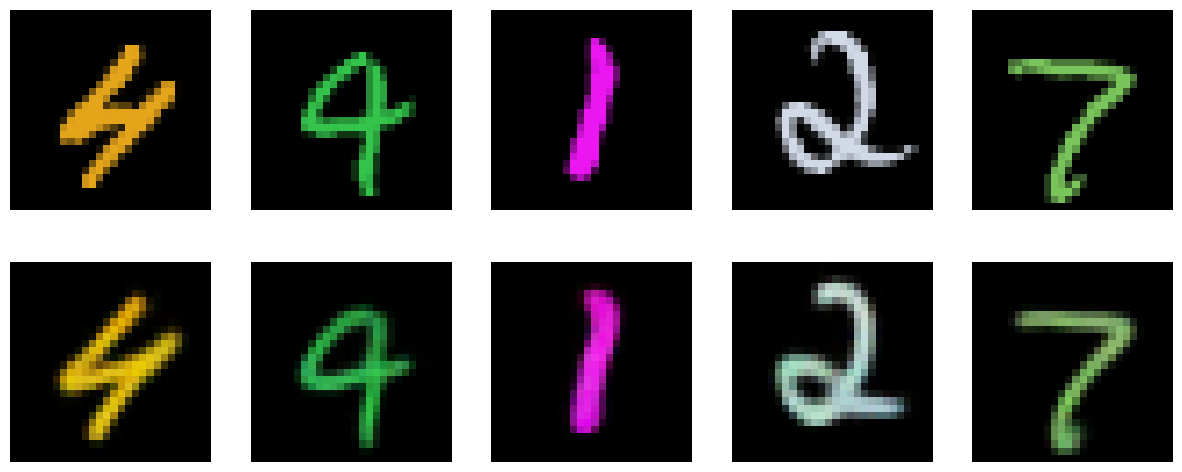


##################################################


VAE-MLP Epoch [14/15], Loss: 0.0002540813891682774


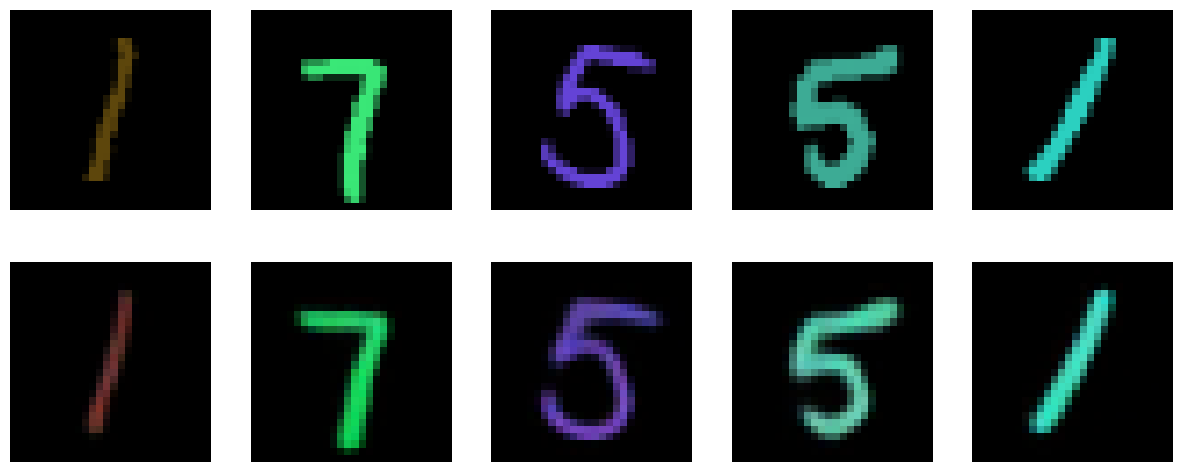


##################################################


VAE-MLP Epoch [15/15], Loss: 0.00025029336439135174


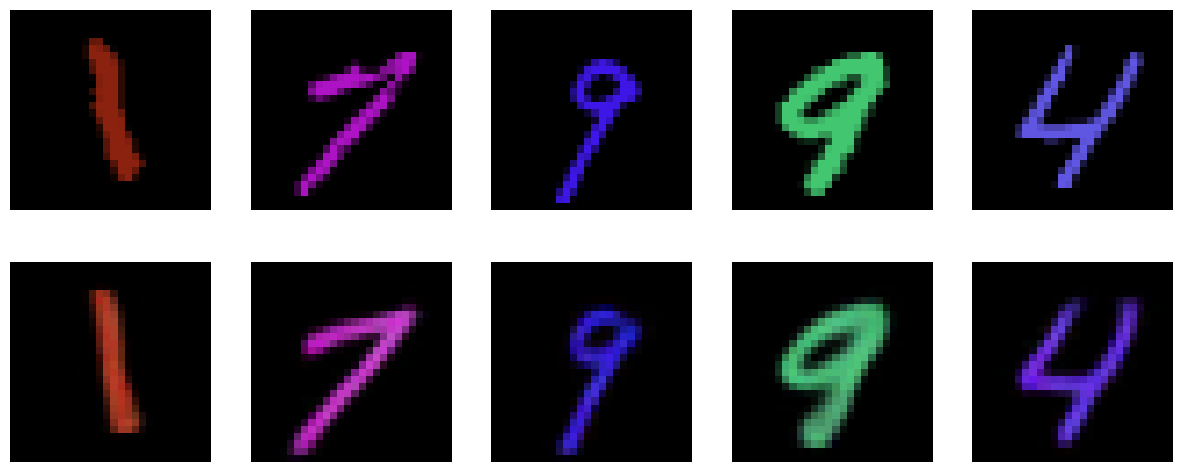

0.00028916382470892533


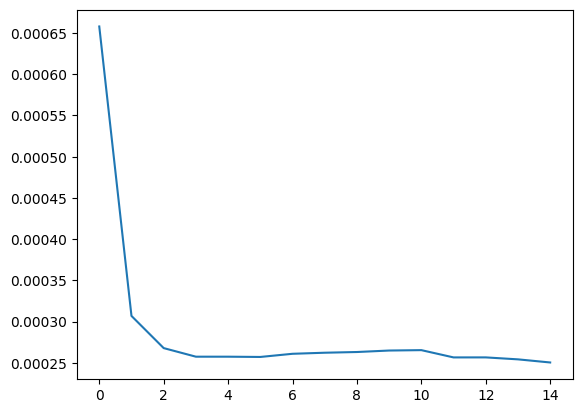

In [ ]:
vq_vae_higher_dimensions = VQVAE_modified(in_channels=3, embedding_dim=50, num_embeddings=3)
train_three(vq_vae_higher_dimensions, train_loader_colorful)


خب همانطور که مشاهده می شود با افزایش تعداد

codebook

مظابق انتظار عکس های تولیدی بهتر می شوند و لاس کمتری نیز خواهیم داشت


اما با افزایش بعد آنها همانطور که دیدید بعد از زیاد کردن از بعد 20 به بعد رسما عکس های تولیدی کیفیت خاصی نداشتند و این هم نتیجه این می تواند باشد که با زیاد کردن بعد الکی طرفیت شبکه را زیاد می کنیم  و به همین دلیل یادگیری مناسبی نداریم.